In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set directory to location of OULAD dataset in google drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [4]:
ls

anonymisedOUDataSet/  Deadline/  StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [5]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# Module EEE

## Setup

### Load dataset and remove column features that are not used in module

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_EEE_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # fail course = 0 | pass course = 1
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
df[0].head()

code_presentation  id_student gender  ... subpage  url mean_click
0             2013J       26915      M  ...     1.0  0.0   0.496296
1             2013J       35355      M  ...     1.0  1.0   0.972222
2             2013J       42638      M  ...     3.2  1.5   1.890856
3             2013J       43564      M  ...     2.0  1.0   0.955026
4             2013J       63112      M  ...     1.0  0.0   0.657407

[5 rows x 22 columns]

In [8]:
df[0].final_result.value_counts()

1    1400
0     348
Name: final_result, dtype: int64

In [9]:
df[0].code_presentation.value_counts()

2014J    705
2013J    612
2014B    431
Name: code_presentation, dtype: int64

## Helper functions

In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [11]:
def plot_confusion_matrix(result):
  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [12]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [13]:
def plot_days_compare(deadline_list,result,labels,title):
  for i in range(len(result)):
    result[i] = np.array(result[i])
    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=result[i][:,1],marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("F1 Score")
  plt_days.set_title(title)

In [14]:
def plot_days_compare_npv(deadline_list,result,labels,title):
 
  for i in range(len(result)):   
    npv = []

    for j in result[i][:,4]:
      tn, fp, fn, tp = j.ravel()

      # Prevent zero division error
      if fn == 0:
        npv.append(0)
      else:
        npv.append(tn/(tn+fn))

    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Negative Predictive Value")
  plt_days.set_title(title)

In [15]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [16]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [17]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [18]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [19]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [20]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [21]:
df[0].columns

Index(['code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'dualpane', 'forumng',
       'homepage', 'oucollaborate', 'oucontent', 'page', 'quiz', 'resource',
       'subpage', 'url', 'mean_click'],
      dtype='object')

In [22]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [24]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Feature correlation
 

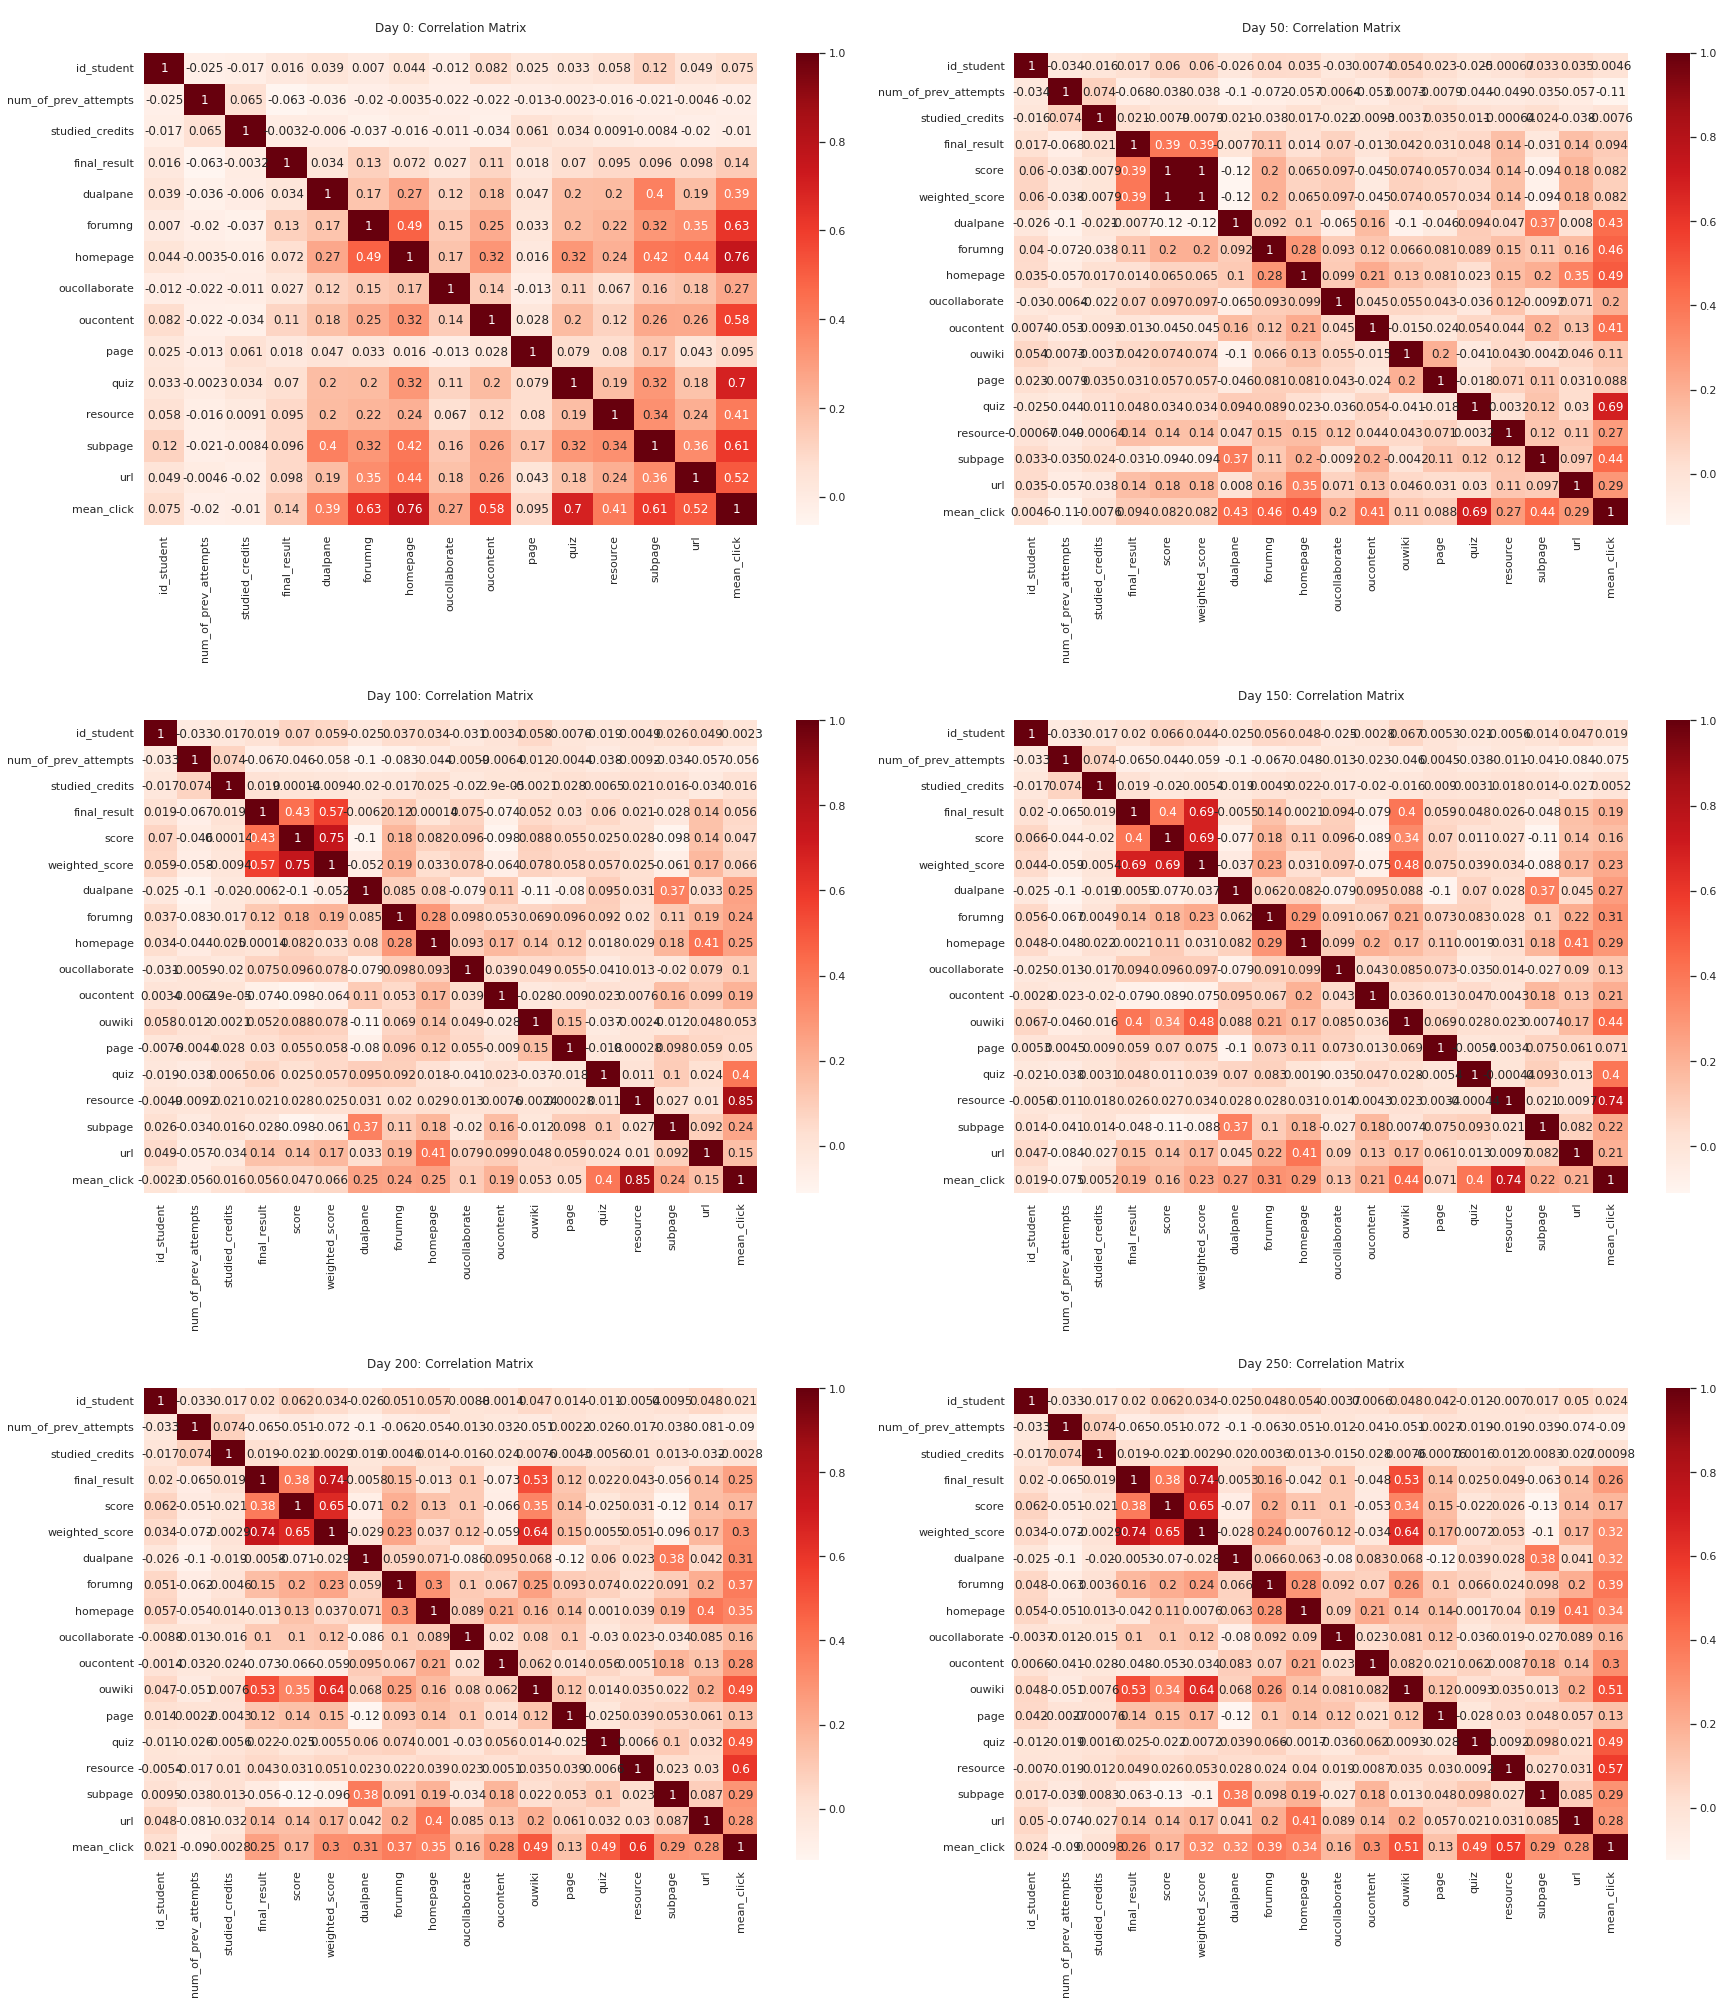

In [25]:
plot_correlation_matrix(df)

## Make predictions

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [27]:
demographic_df = {}
for i in df.keys():
  demographic_df[i] = split_dataframe_by_data_type(df[i], ['demographic'], include_final_result=True)

###### Encode data

In [28]:
X_train, X_test, Y_train, Y_test = encode_data(demographic_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')


In [29]:
X_train[0].shape

(612, 35)

###### Undersampling

In [30]:
Y_train[0].value_counts()

1    495
0    117
Name: final_result, dtype: int64

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 495, 0: 117})
Resample dataset shape Counter({0: 117, 1: 117})
Sampling for day 50
Original dataset shape: Counter({1: 567, 0: 140})
Resample dataset shape Counter({0: 140, 1: 140})
Sampling for day 100
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 150
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 200
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 250
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})


###### Feature selection

In [32]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [33]:
X_train[250]

0    1    2    3    4    5    6   ...   13   14   15   16   17   18   19
0    0.0  0.0  1.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
1    0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  1.0  0.0  1.0  0.0  0.0
2    0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0
3    0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4    0.0  1.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
704  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0
705  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  1.0  0.0  0.0  0.0
706  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
707  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
708  0.0  0.0  1.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0

[709 rows x 20 columns]

##### DummyClassifier

In [34]:
from sklearn.dummy import DummyClassifier

demographic_results_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_du.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.464
Best parameters set:
Accuracy: 0.524822695035461, F1 Score: 0.6484784889821615, Precision: 0.8373983739837398, Recall: 0.5291095890410958


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.468
Best parameters set:
Accuracy: 0.4802547770700637, F1 Score: 0.614366729678639, Precision: 0.7946210268948656, Recall: 0.5007704160246533


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best parameters set:
Accuracy: 0.5120405576679341, F1 Score: 0.6378174976481655, Precision: 0.8248175182481752, Recall: 0.5199386503067485


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best p

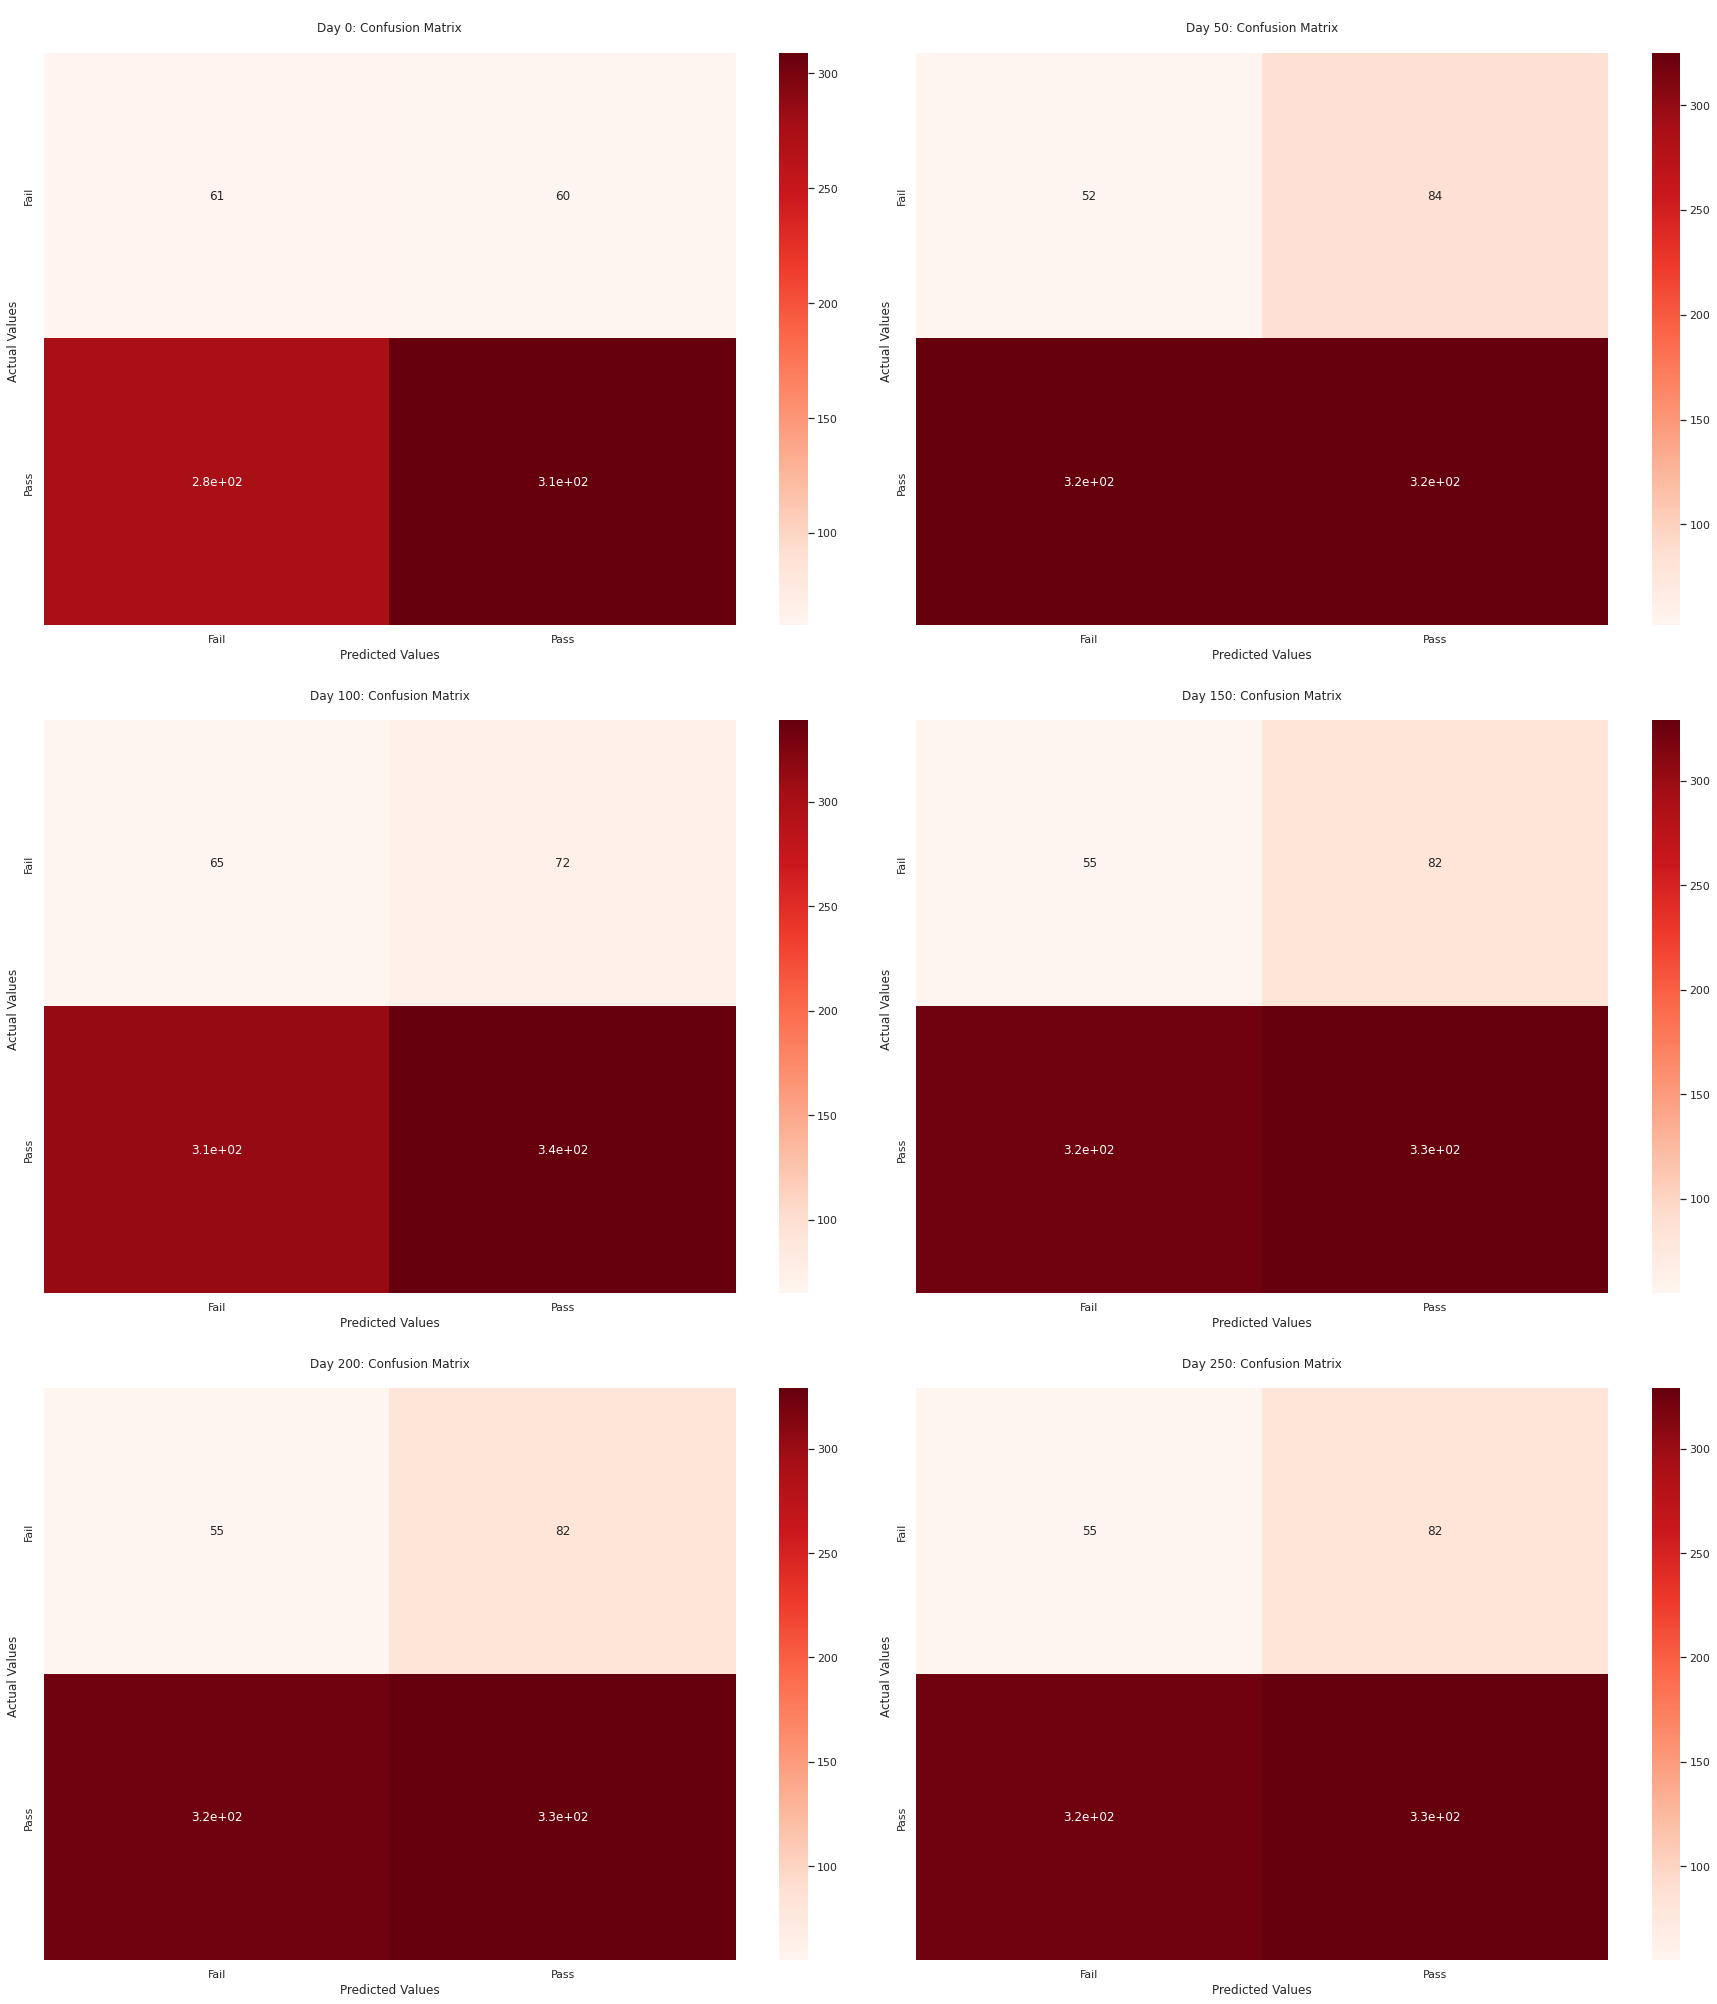

In [35]:
plot_confusion_matrix(demographic_results_du)

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [36]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

demographic_results_nb = []

pipeline = Pipeline([
    ('clf', BernoulliNB(binarize=None)),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_nb.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.484
Best parameters set:
Accuracy: 0.8141843971631205, F1 Score: 0.8972549019607843, Precision: 0.8277858176555717, Recall: 0.9794520547945206


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.482
Best parameters set:
Accuracy: 0.8203821656050956, F1 Score: 0.9006342494714586, Precision: 0.8298701298701299, Recall: 0.9845916795069337


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.475
Best parameters set:
Accuracy: 0.8212927756653993, F1 Score: 0.901329601119664, Precision: 0.8288288288288288, Recall: 0.9877300613496932


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.475
Best 

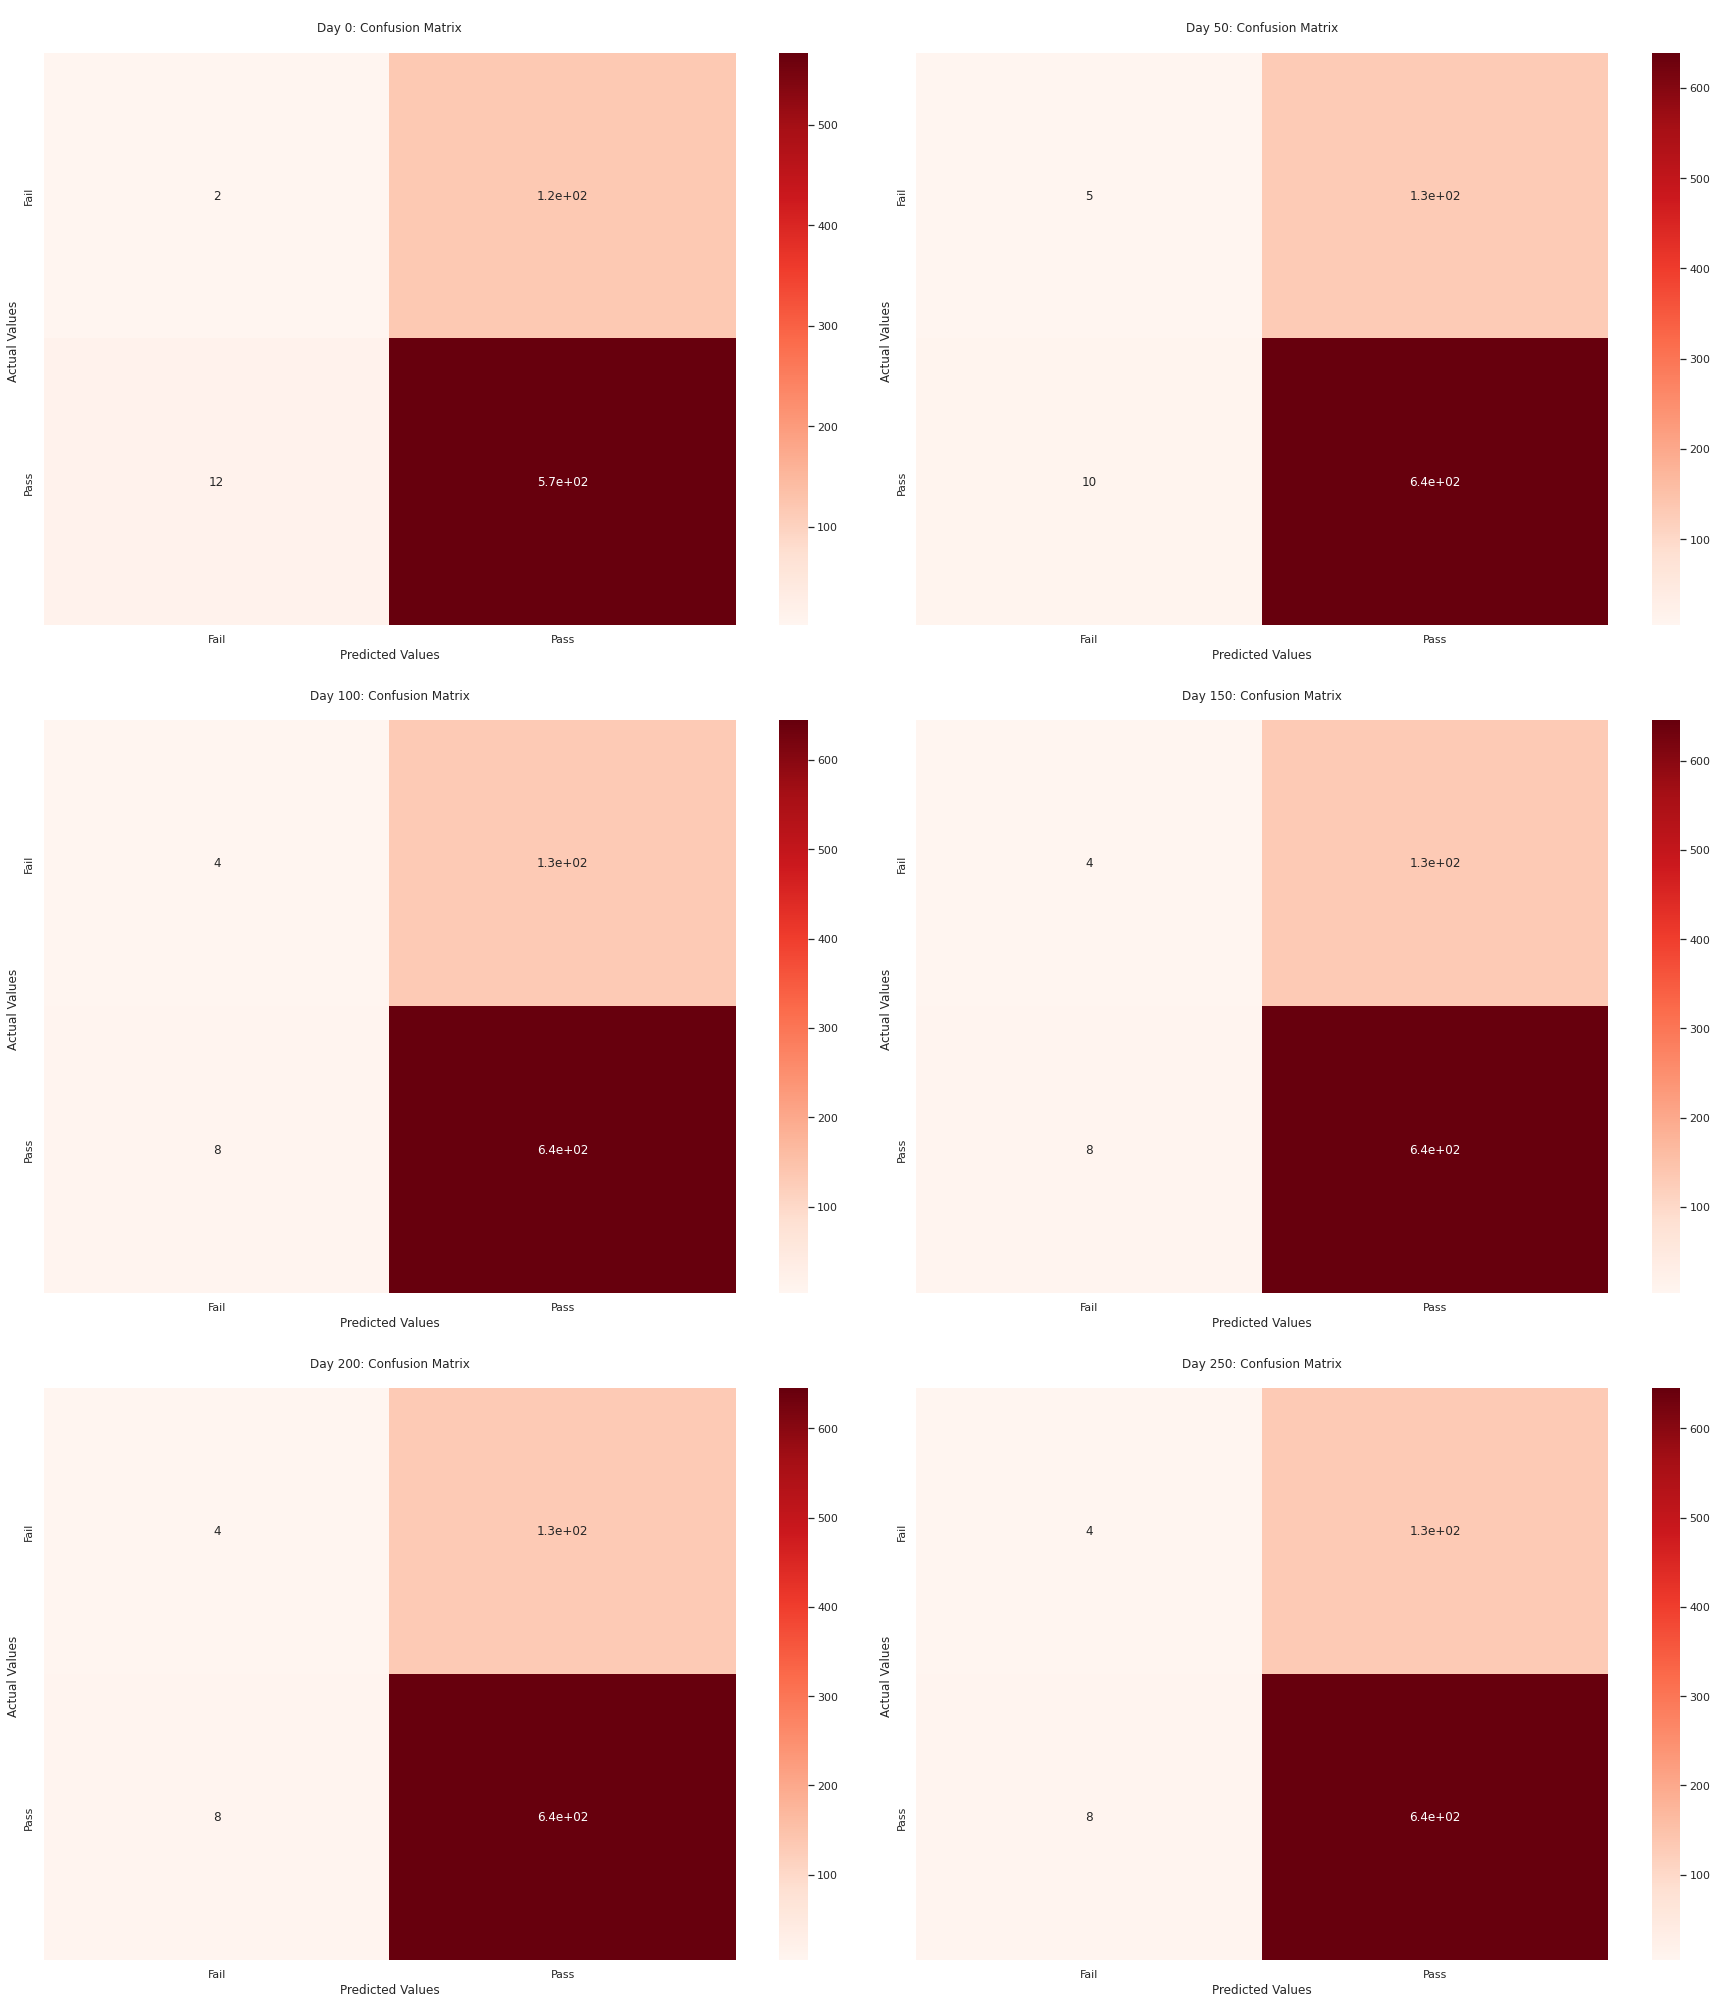

In [37]:
plot_confusion_matrix(demographic_results_nb)

##### LogisticRegression

ovr is used for binary problems

In [38]:
from sklearn.linear_model import LogisticRegression

demographic_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr')),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lr.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.463
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8283687943262411, F1 Score: 0.9061287820015517, Precision: 0.8283687943262411, Recall: 1.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.459
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.824203821656051, F1 Score: 0.9034965034965036, Precision: 0.8271446862996159, Recall: 0.9953775038520801


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.458
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8250950570342205, F1 Score: 0.9040333796940195, Precision: 0.8269720101781171, Recall: 0.9969325153374233


Day 150


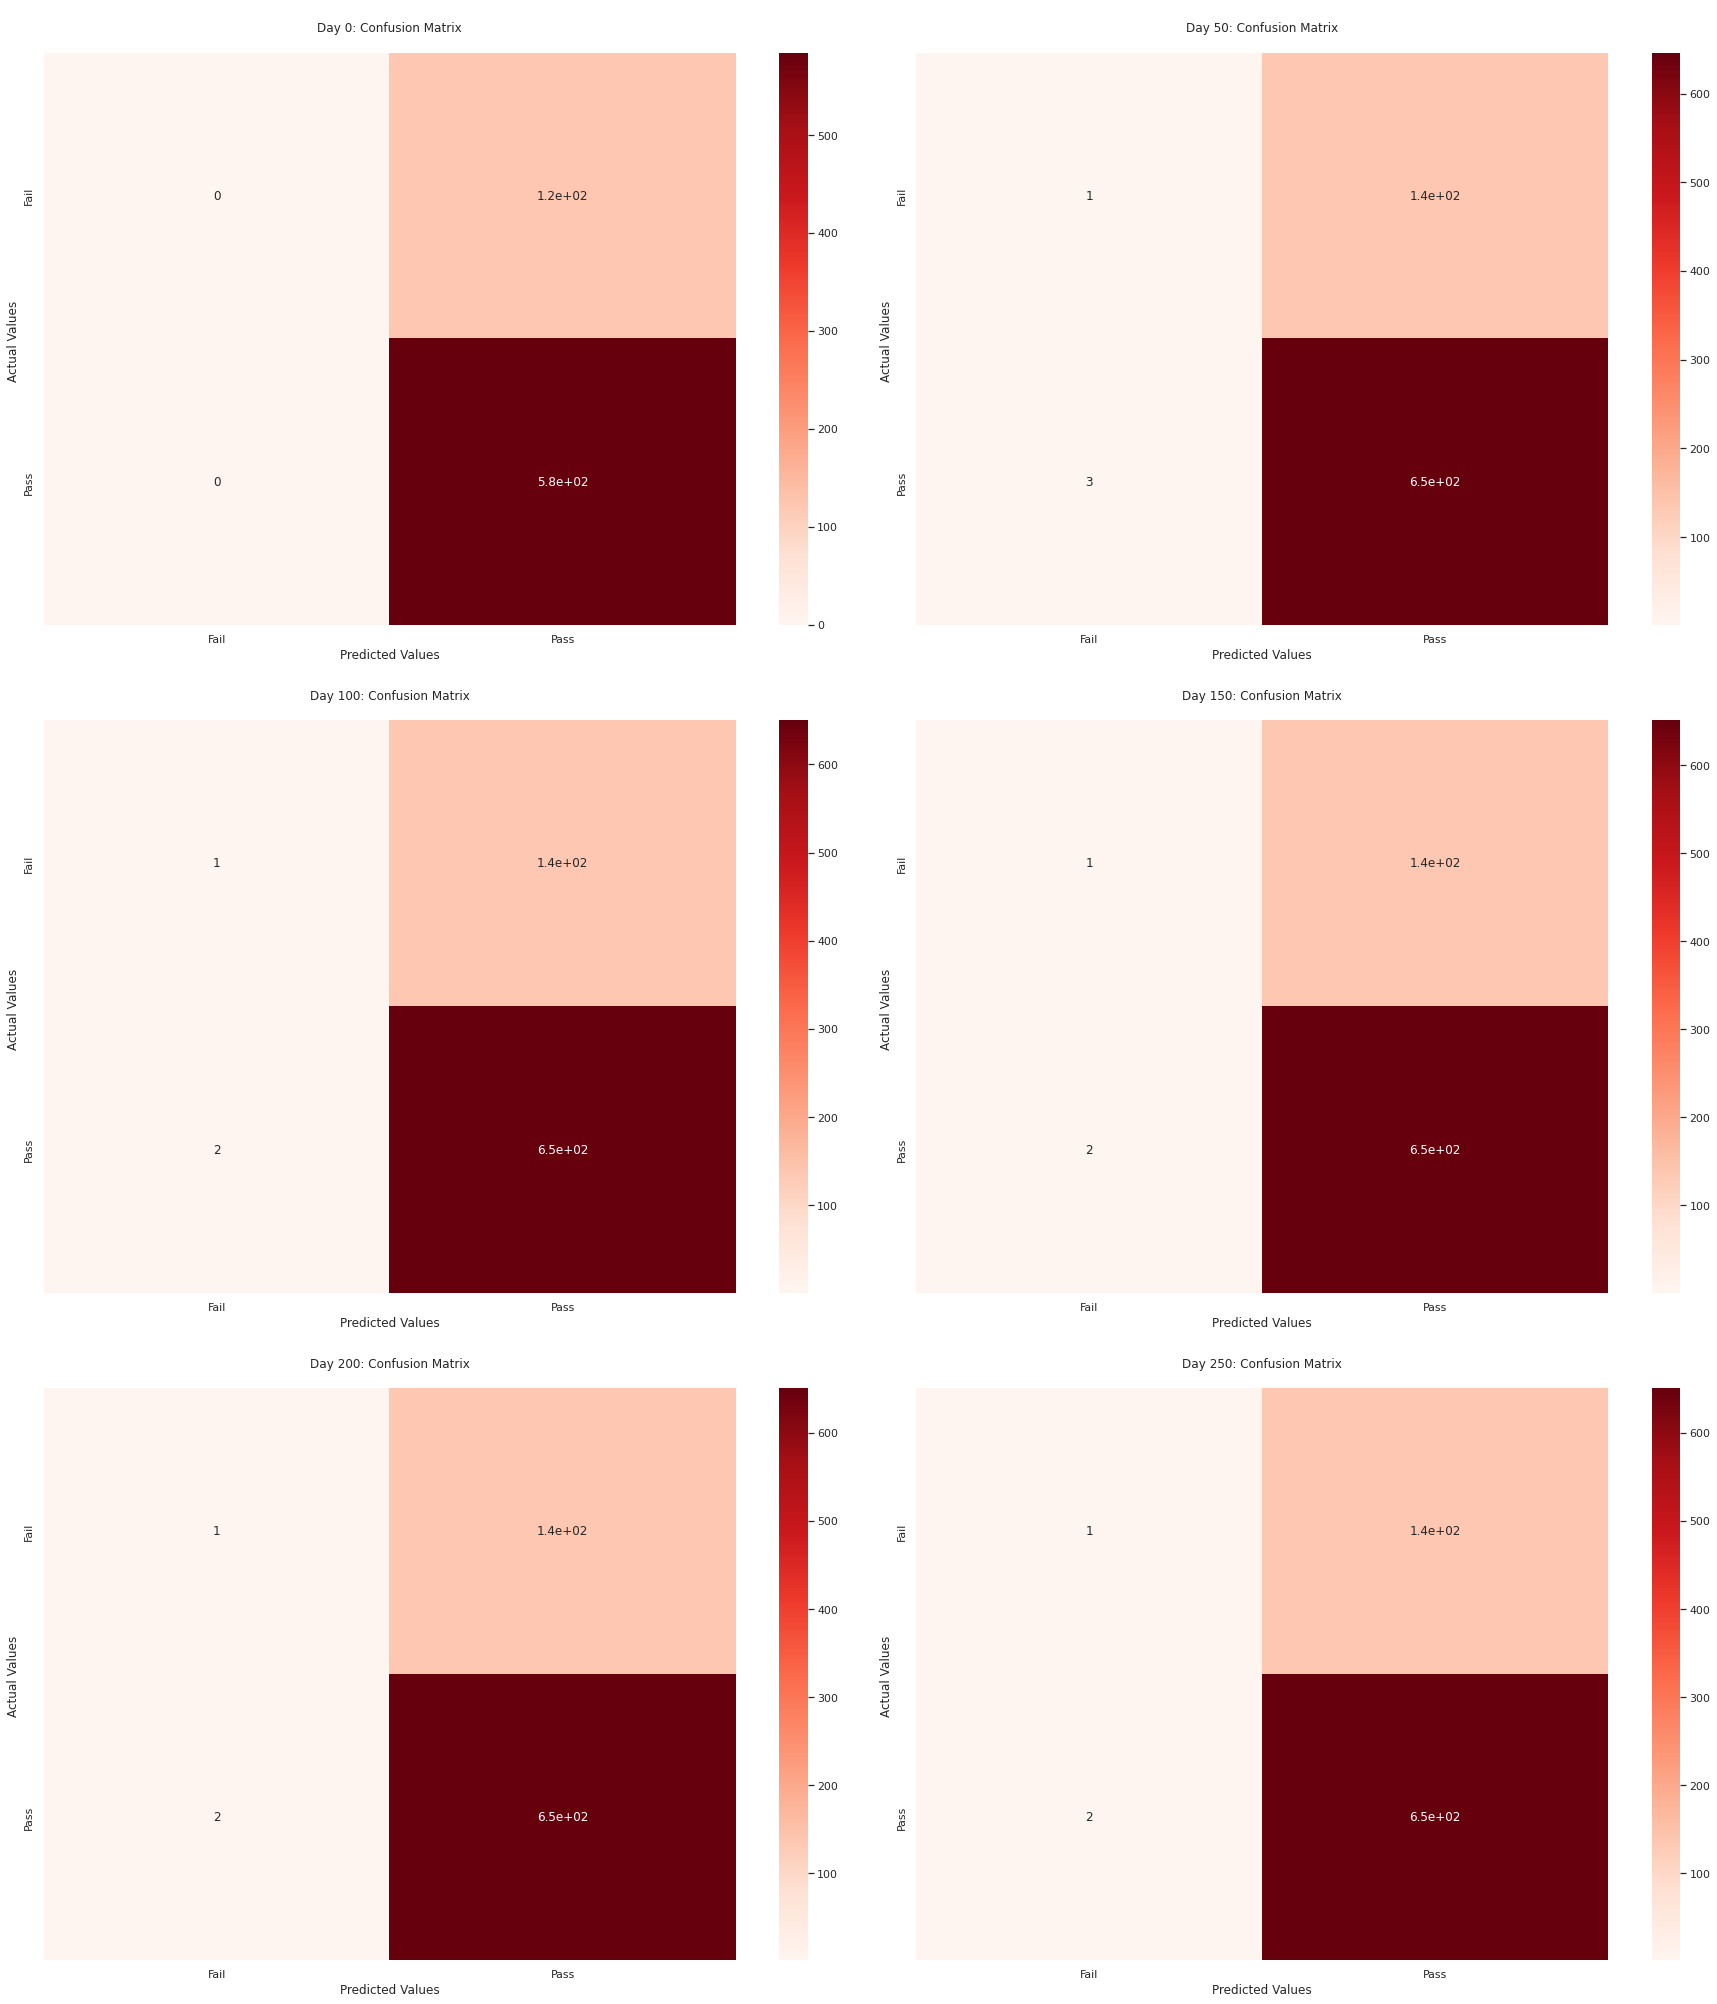

In [39]:
plot_confusion_matrix(demographic_results_lr)

##### WeightedLogisticRegression

In [40]:
demographic_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.508
Best parameters set:
Accuracy: 0.5673758865248227, F1 Score: 0.6858908341915552, Precision: 0.8604651162790697, Recall: 0.5702054794520548


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.518
Best parameters set:
Accuracy: 0.5732484076433121, F1 Score: 0.6968325791855203, Precision: 0.8442982456140351, Recall: 0.5932203389830508


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.509
Best parameters set:
Accuracy: 0.5868187579214195, F1 Score: 0.7078853046594983, Precision: 0.8512931034482759, Recall: 0.6058282208588958


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.509
Best

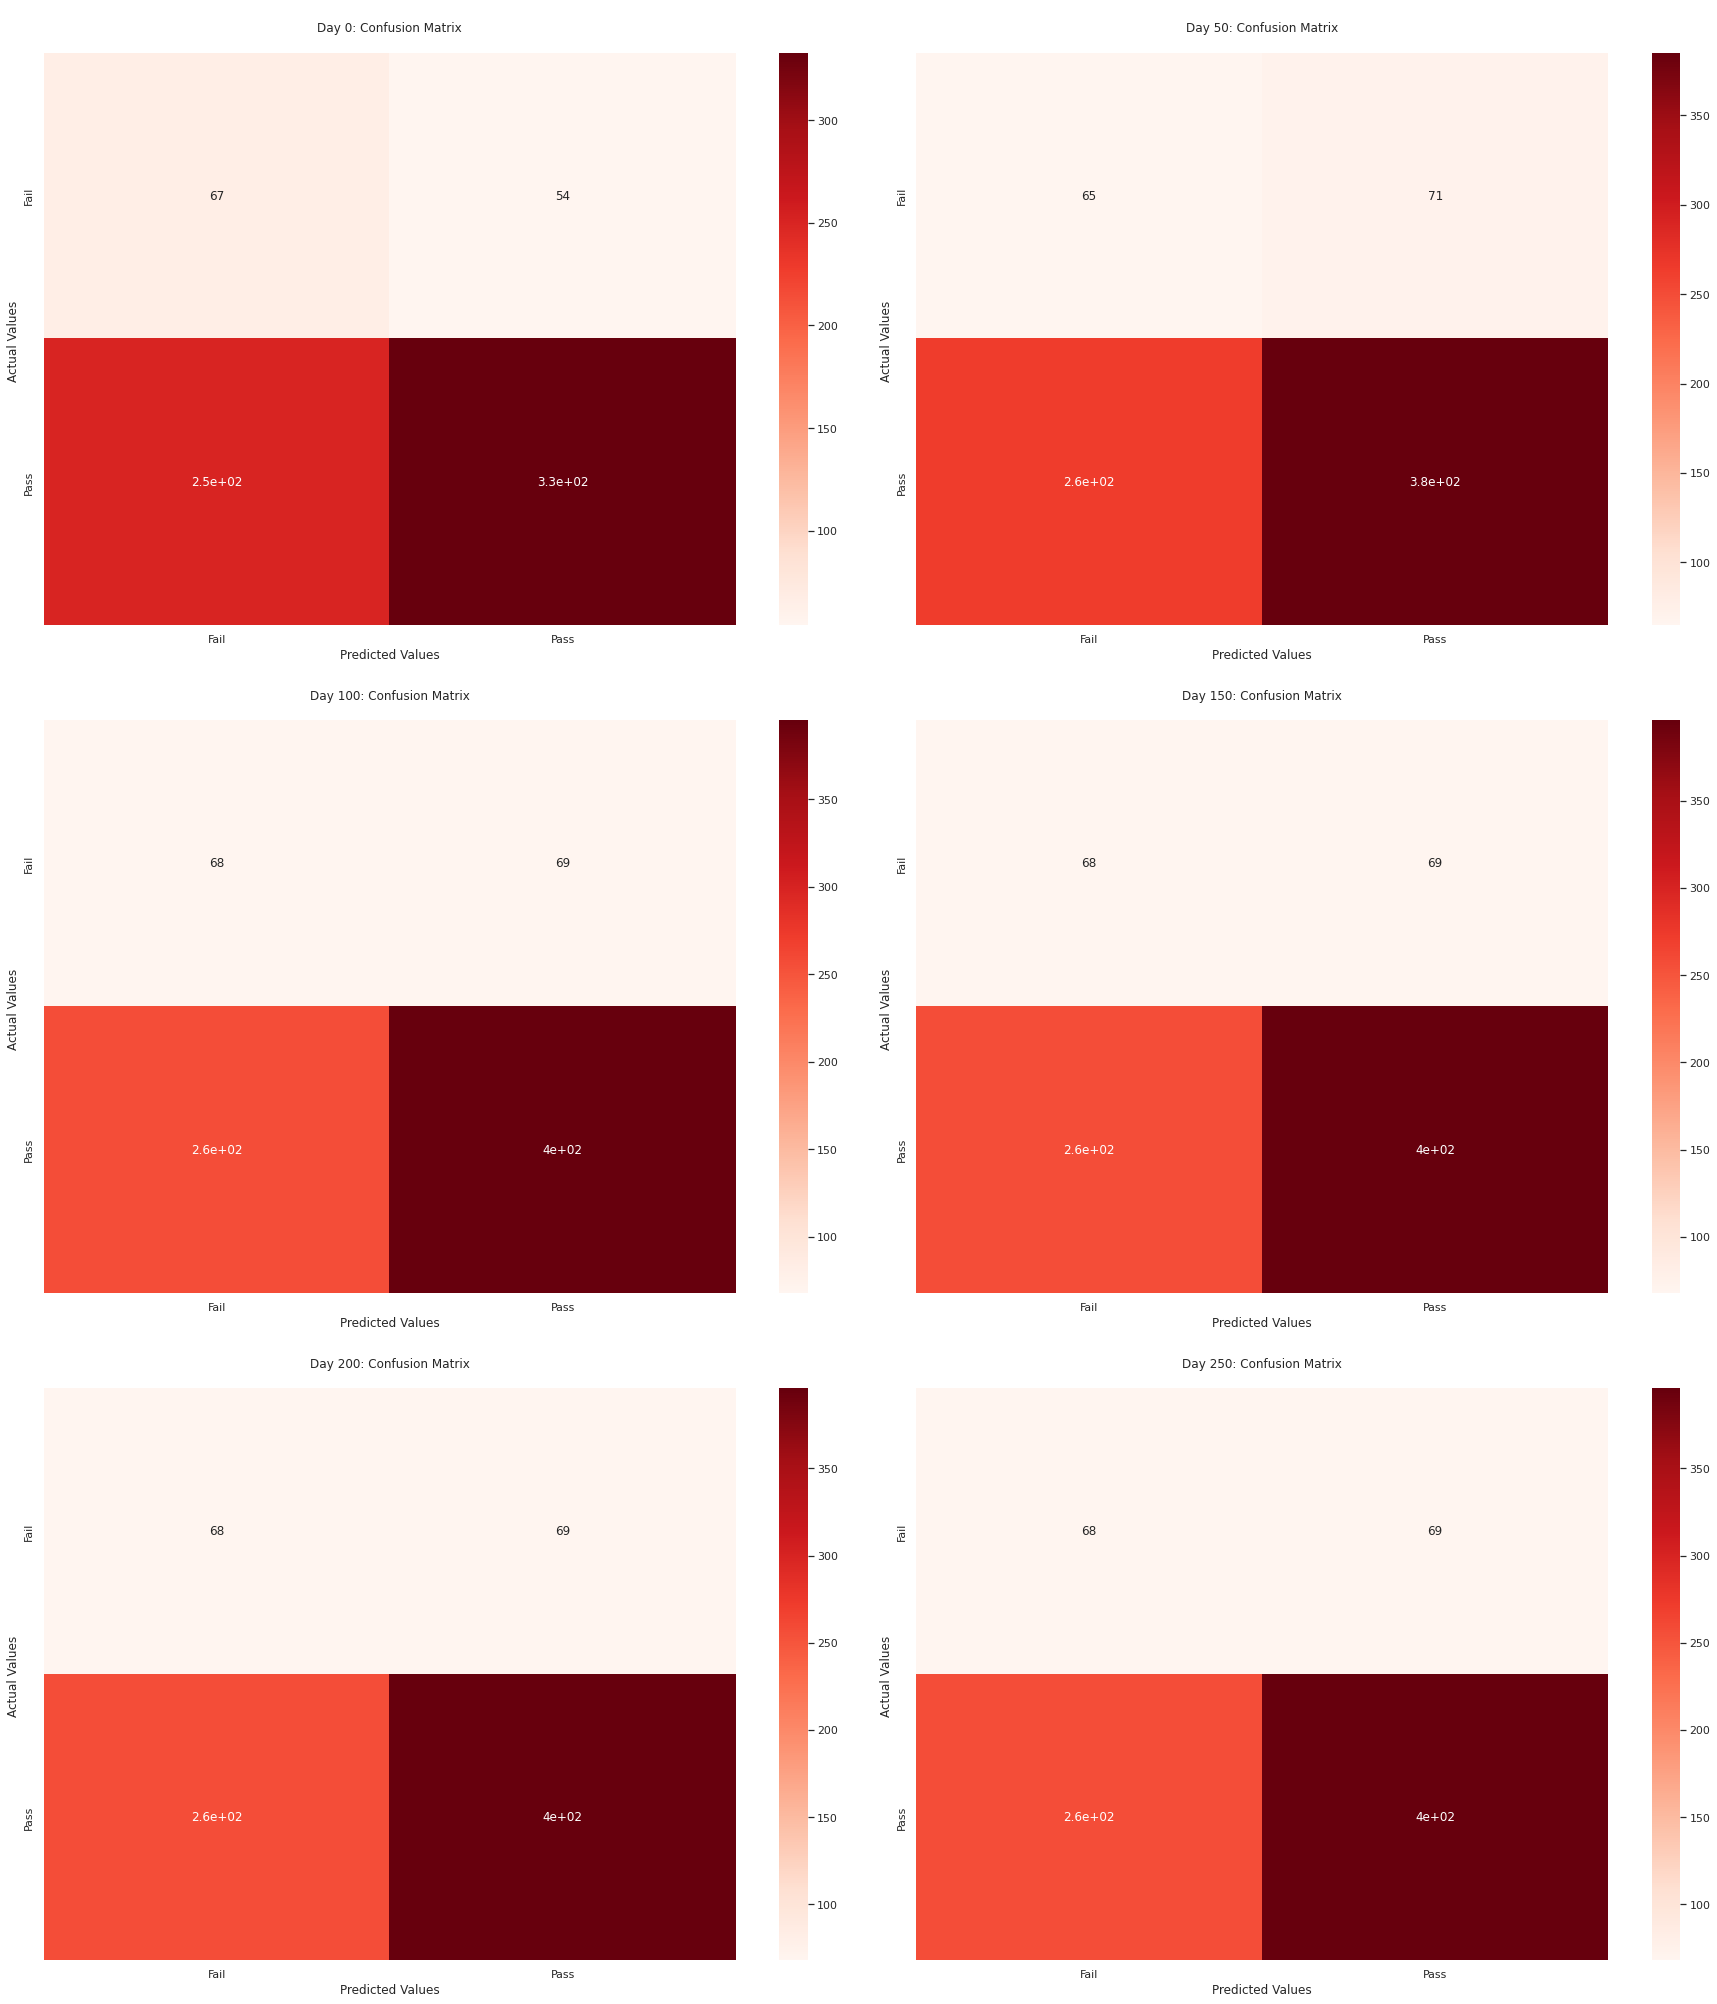

In [41]:
plot_confusion_matrix(demographic_results_lrw)

##### RandomForest

In [42]:
from sklearn.ensemble import RandomForestClassifier

demographic_results_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_rf.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.541
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.7730496453900709, F1 Score: 0.8709677419354839, Precision: 0.823170731707317, Recall: 0.9246575342465754


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.505
Best parameters set:
	clf__n_estimators: 120
Accuracy: 0.7732484076433122, F1 Score: 0.8710144927536233, Precision: 0.8221614227086184, Recall: 0.926040061633282


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.506
Best parameters set:
	clf__n_estimators:

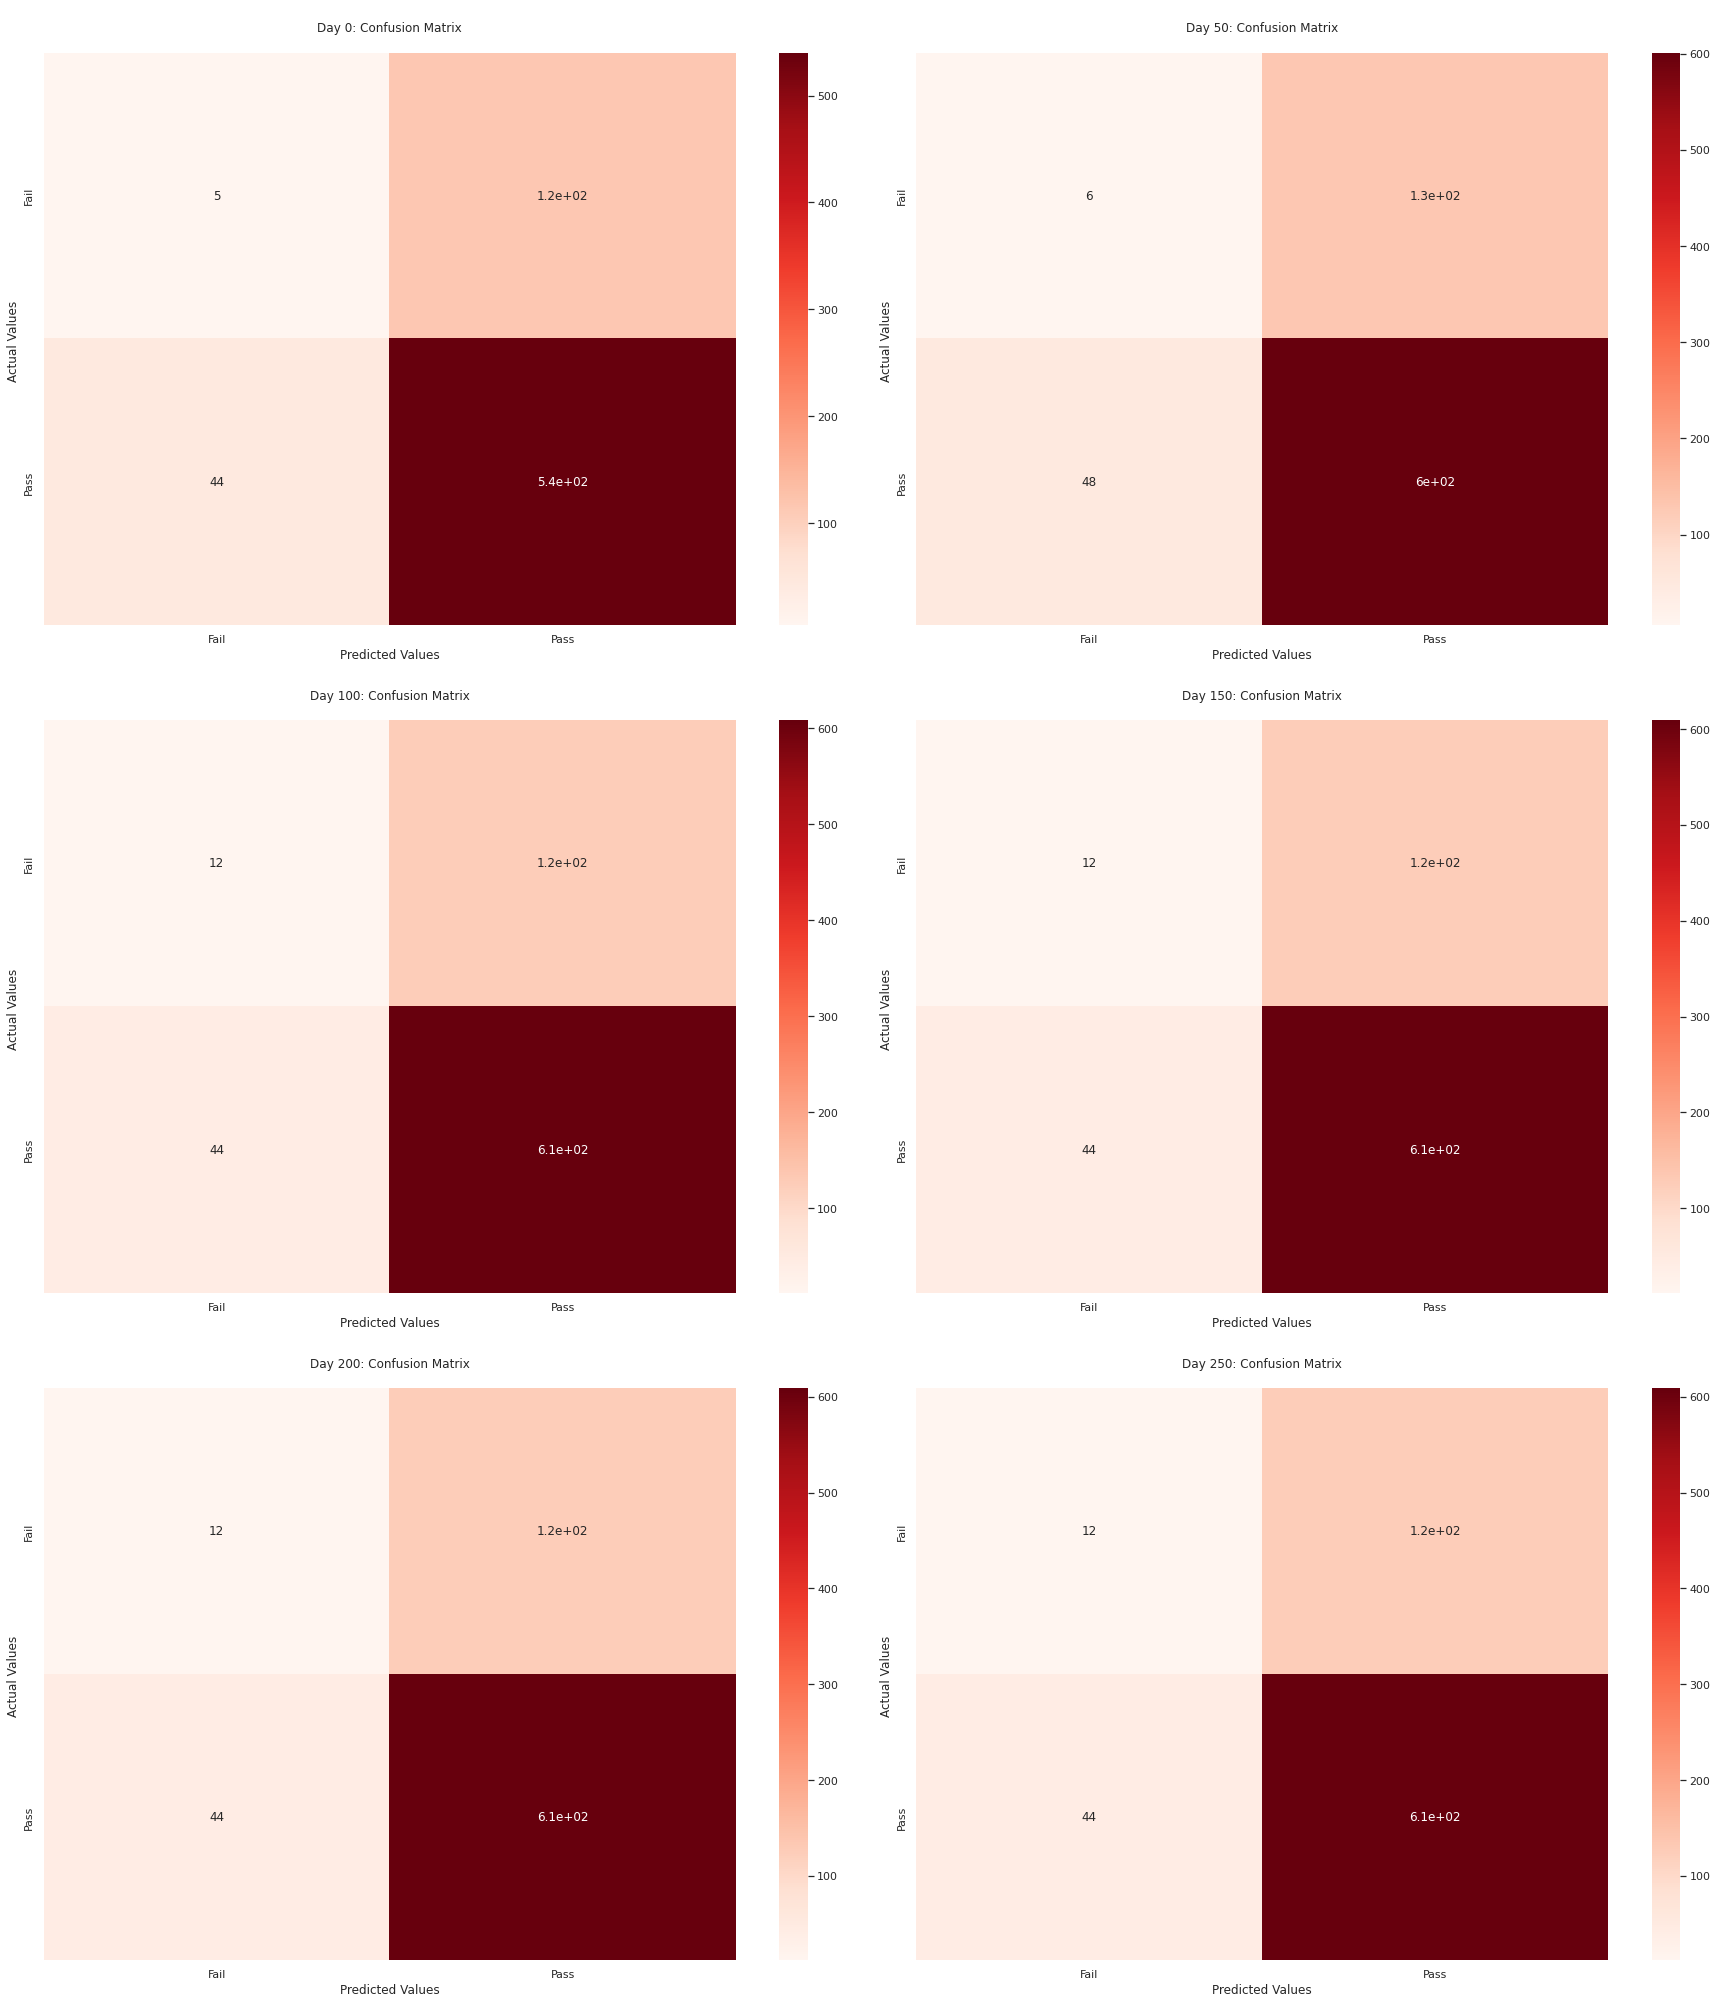

In [43]:
plot_confusion_matrix(demographic_results_rf)

##### AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier

demographic_results_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_ab.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.464
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.825531914893617, F1 Score: 0.9044289044289043, Precision: 0.8278805120910384, Recall: 0.9965753424657534


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.451
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.8254777070063695, F1 Score: 0.9042627533193571, Precision: 0.8273657289002557, Recall: 0.9969183359013868


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.464
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.8238276299112801, 

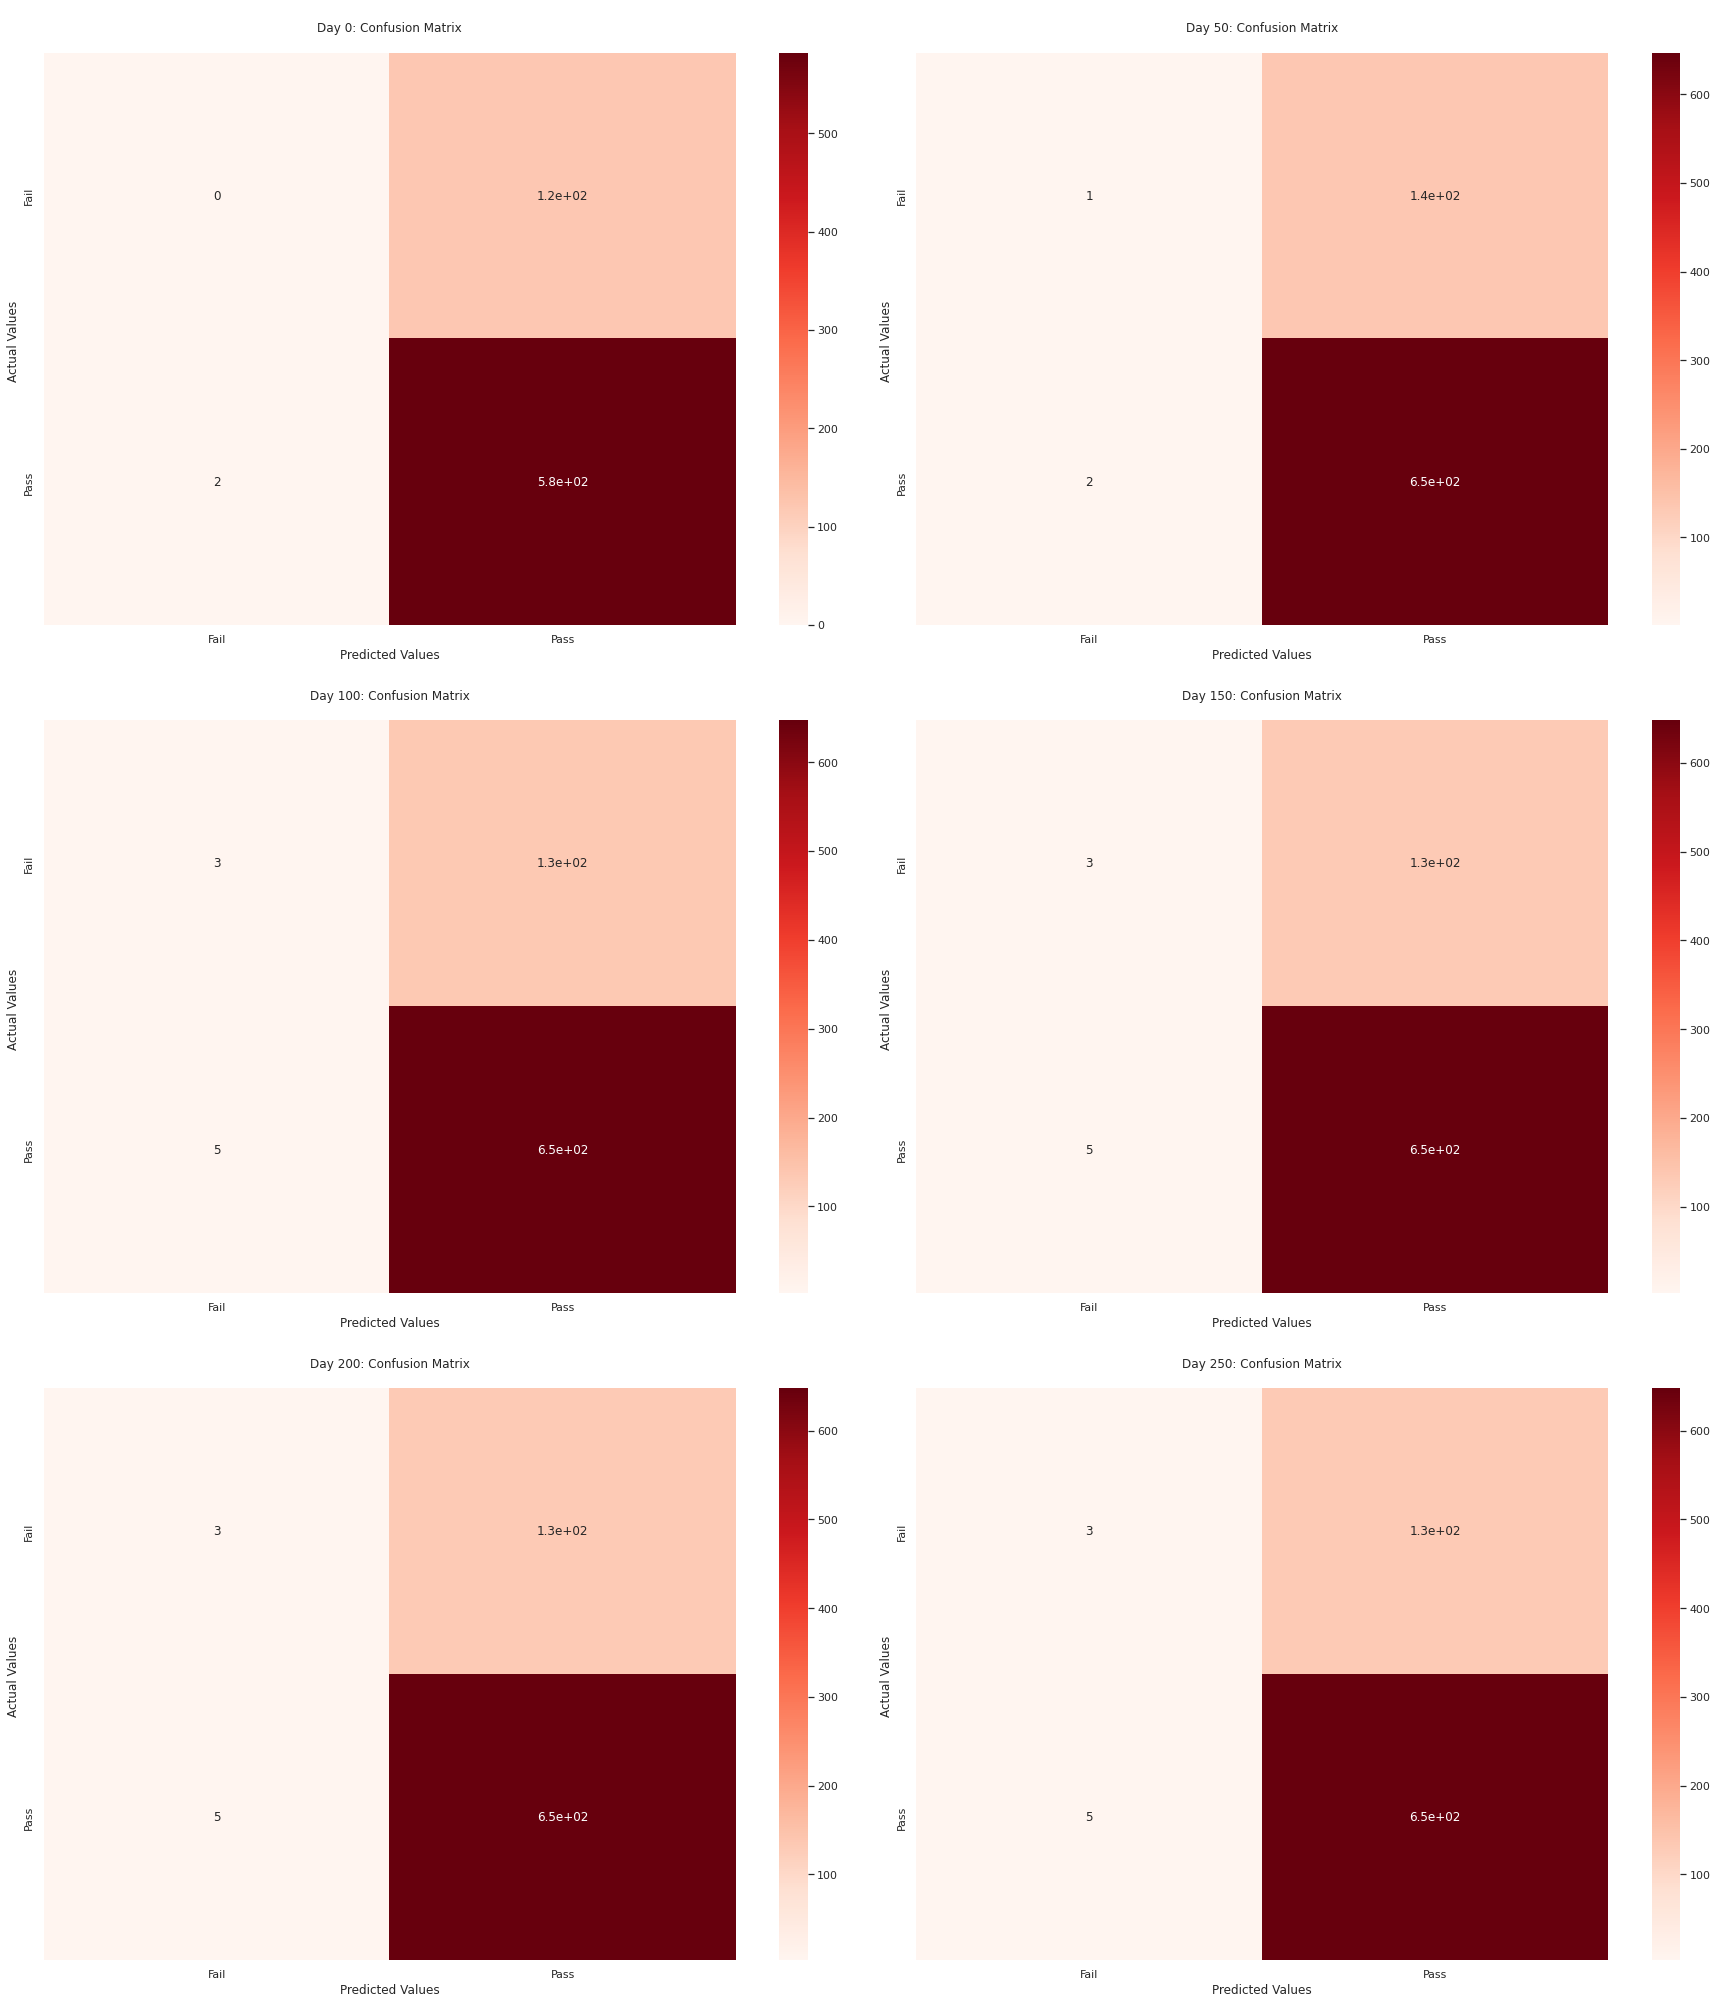

In [45]:
plot_confusion_matrix(demographic_results_ab)

##### Plot results overview

In [46]:
demographic_classifier_results = [demographic_results_du, demographic_results_nb, demographic_results_lr, demographic_results_lrw, demographic_results_rf, demographic_results_ab]
demographic_classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

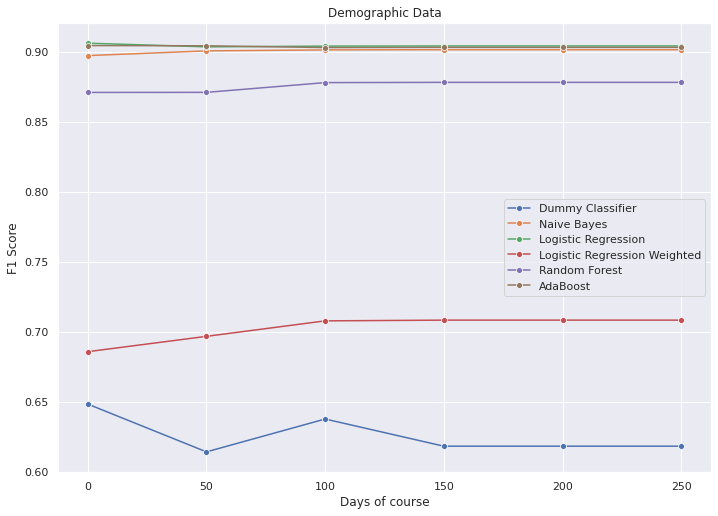

In [47]:
plot_days_compare(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

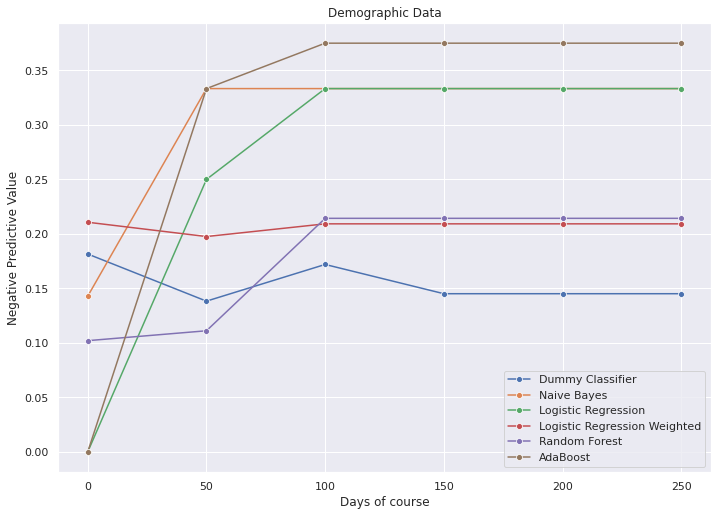

In [48]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

#### Learning behaviour data

##### Prepare data for prediction

In [49]:
learning_behaviour_df = {}
for i in df.keys():
  learning_behaviour_df[i] = split_dataframe_by_data_type(df[i], ['learning_behaviour'], include_final_result=True)

In [50]:
learning_behaviour_df[0]

code_presentation  id_student  oucontent  ...  mean_click  page  final_result
0                2013J       26915   3.000000  ...    0.496296   0.0             0
1                2013J       35355   5.500000  ...    0.972222   0.0             1
2                2013J       42638   7.866667  ...    1.890856   0.0             1
3                2013J       43564   6.714286  ...    0.955026   0.0             1
4                2013J       63112   4.833333  ...    0.657407   0.0             1
...                ...         ...        ...  ...         ...   ...           ...
1743             2014J     2644404   0.000000  ...    0.055556   0.0             1
1744             2014J     2654928   2.888889  ...    0.895062   0.0             1
1745             2014J     2663195   5.000000  ...    0.555556   0.0             1
1746             2014J     2686053   2.125000  ...    0.383333   0.0             1
1747             2014J     2686712   4.333333  ...    0.770988   0.0             0

[1748 rows x 14 columns]

###### Encode data

In [51]:
X_train, X_test, Y_train, Y_test = encode_data(learning_behaviour_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click'],
      dtype='object')
Index([], dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click'],
      dtype='object')
Index([], dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click'],
      dtype='object')
Index([], dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click', 'ouwiki'],
      dtype='object')
Index([], dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'page', 'quiz',
       'url', 'homepage', 'resource', 'forumng', 'mean_click', 'ouwiki'],
      dtype='object')
Index([], dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate

###### Undersampling

In [52]:
Y_train[0].value_counts()

1    495
0    117
Name: final_result, dtype: int64

In [53]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 495, 0: 117})
Resample dataset shape Counter({0: 117, 1: 117})
Sampling for day 50
Original dataset shape: Counter({1: 567, 0: 140})
Resample dataset shape Counter({0: 140, 1: 140})
Sampling for day 100
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 150
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 200
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 250
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})


###### Feature selection

In [54]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train[i].index)
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test[i].index)

In [55]:
X_train[250]

subpage      quiz   forumng  mean_click    ouwiki
0    0.103448  0.452830  0.282143    0.095676  0.277846
1    0.141659  0.237371  0.304085    0.121984  0.490201
2    0.121511  0.432704  0.344211    0.121009  0.469626
3    0.141762  0.312668  0.426316    0.108041  0.400959
4    0.136163  0.388970  0.710119    0.130542  0.291155
..        ...       ...       ...         ...       ...
704  0.098522  0.540881  0.166667    0.080185  0.000000
705  0.145096  0.303774  0.533582    0.154009  0.556047
706  0.110345  0.395655  0.458448    0.148508  0.400959
707  0.142380  0.522013  0.228571    0.116919  0.312298
708  0.081505  0.363636  0.618328    0.131996  0.672482

[709 rows x 5 columns]

##### DummyClassifier

In [56]:
from sklearn.dummy import DummyClassifier

learning_behaviour_results_du = []
learning_behaviour_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.464
Best parameters set:
Accuracy: 0.524822695035461, F1 Score: 0.6484784889821615, Precision: 0.8373983739837398, Recall: 0.5291095890410958


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.468
Best parameters set:
Accuracy: 0.4802547770700637, F1 Score: 0.614366729678639, Precision: 0.7946210268948656, Recall: 0.5007704160246533


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best parameters set:
Accuracy: 0.5120405576679341, F1 Score: 0.6378174976481655, Precision: 0.8248175182481752, Recall: 0.5199386503067485


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best p

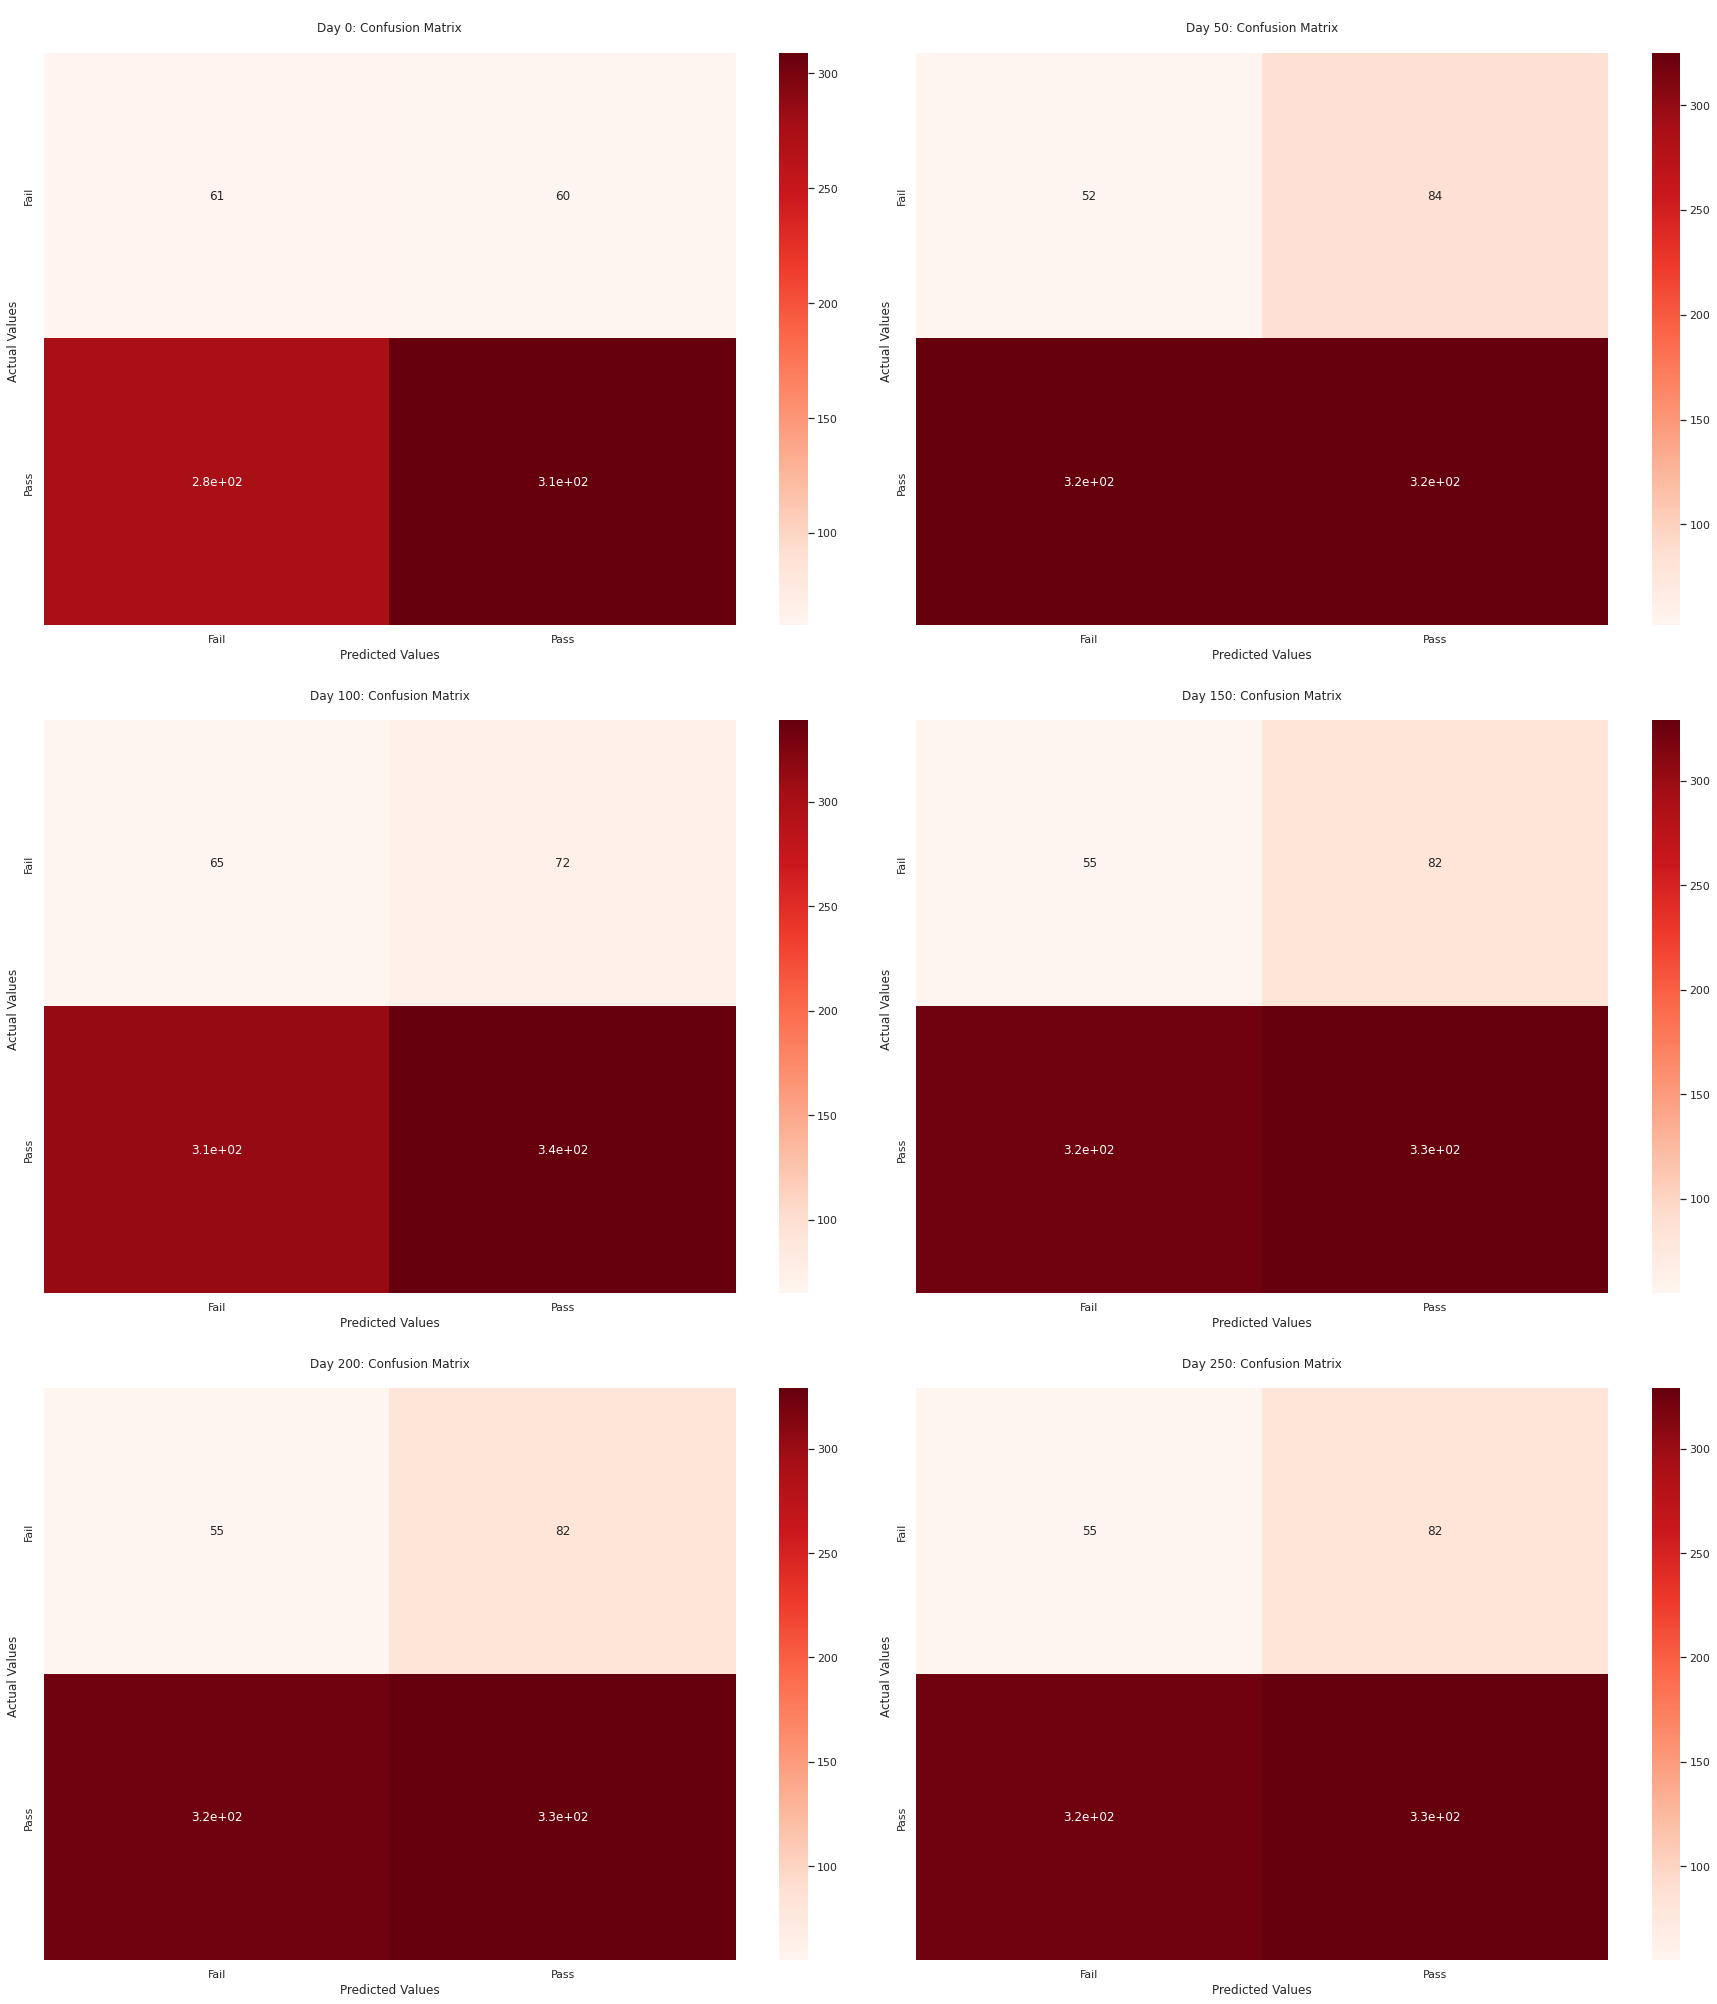

In [57]:
plot_confusion_matrix(learning_behaviour_results_du)

##### NaiveBayes

In [58]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

learning_behaviour_results_nb = []
learning_behaviour_features_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_nb.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.459
Best parameters set:
Accuracy: 0.5347517730496454, F1 Score: 0.6427015250544662, Precision: 0.8832335329341318, Recall: 0.5051369863013698


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.528
Best parameters set:
Accuracy: 0.7375796178343949, F1 Score: 0.8385579937304074, Precision: 0.8532695374800638, Recall: 0.8243451463790447


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.514
Best parameters set:
Accuracy: 0.6717363751584284, F1 Score: 0.7843463780183181, Precision: 0.8579234972677595, Recall: 0.7223926380368099


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.736
Best

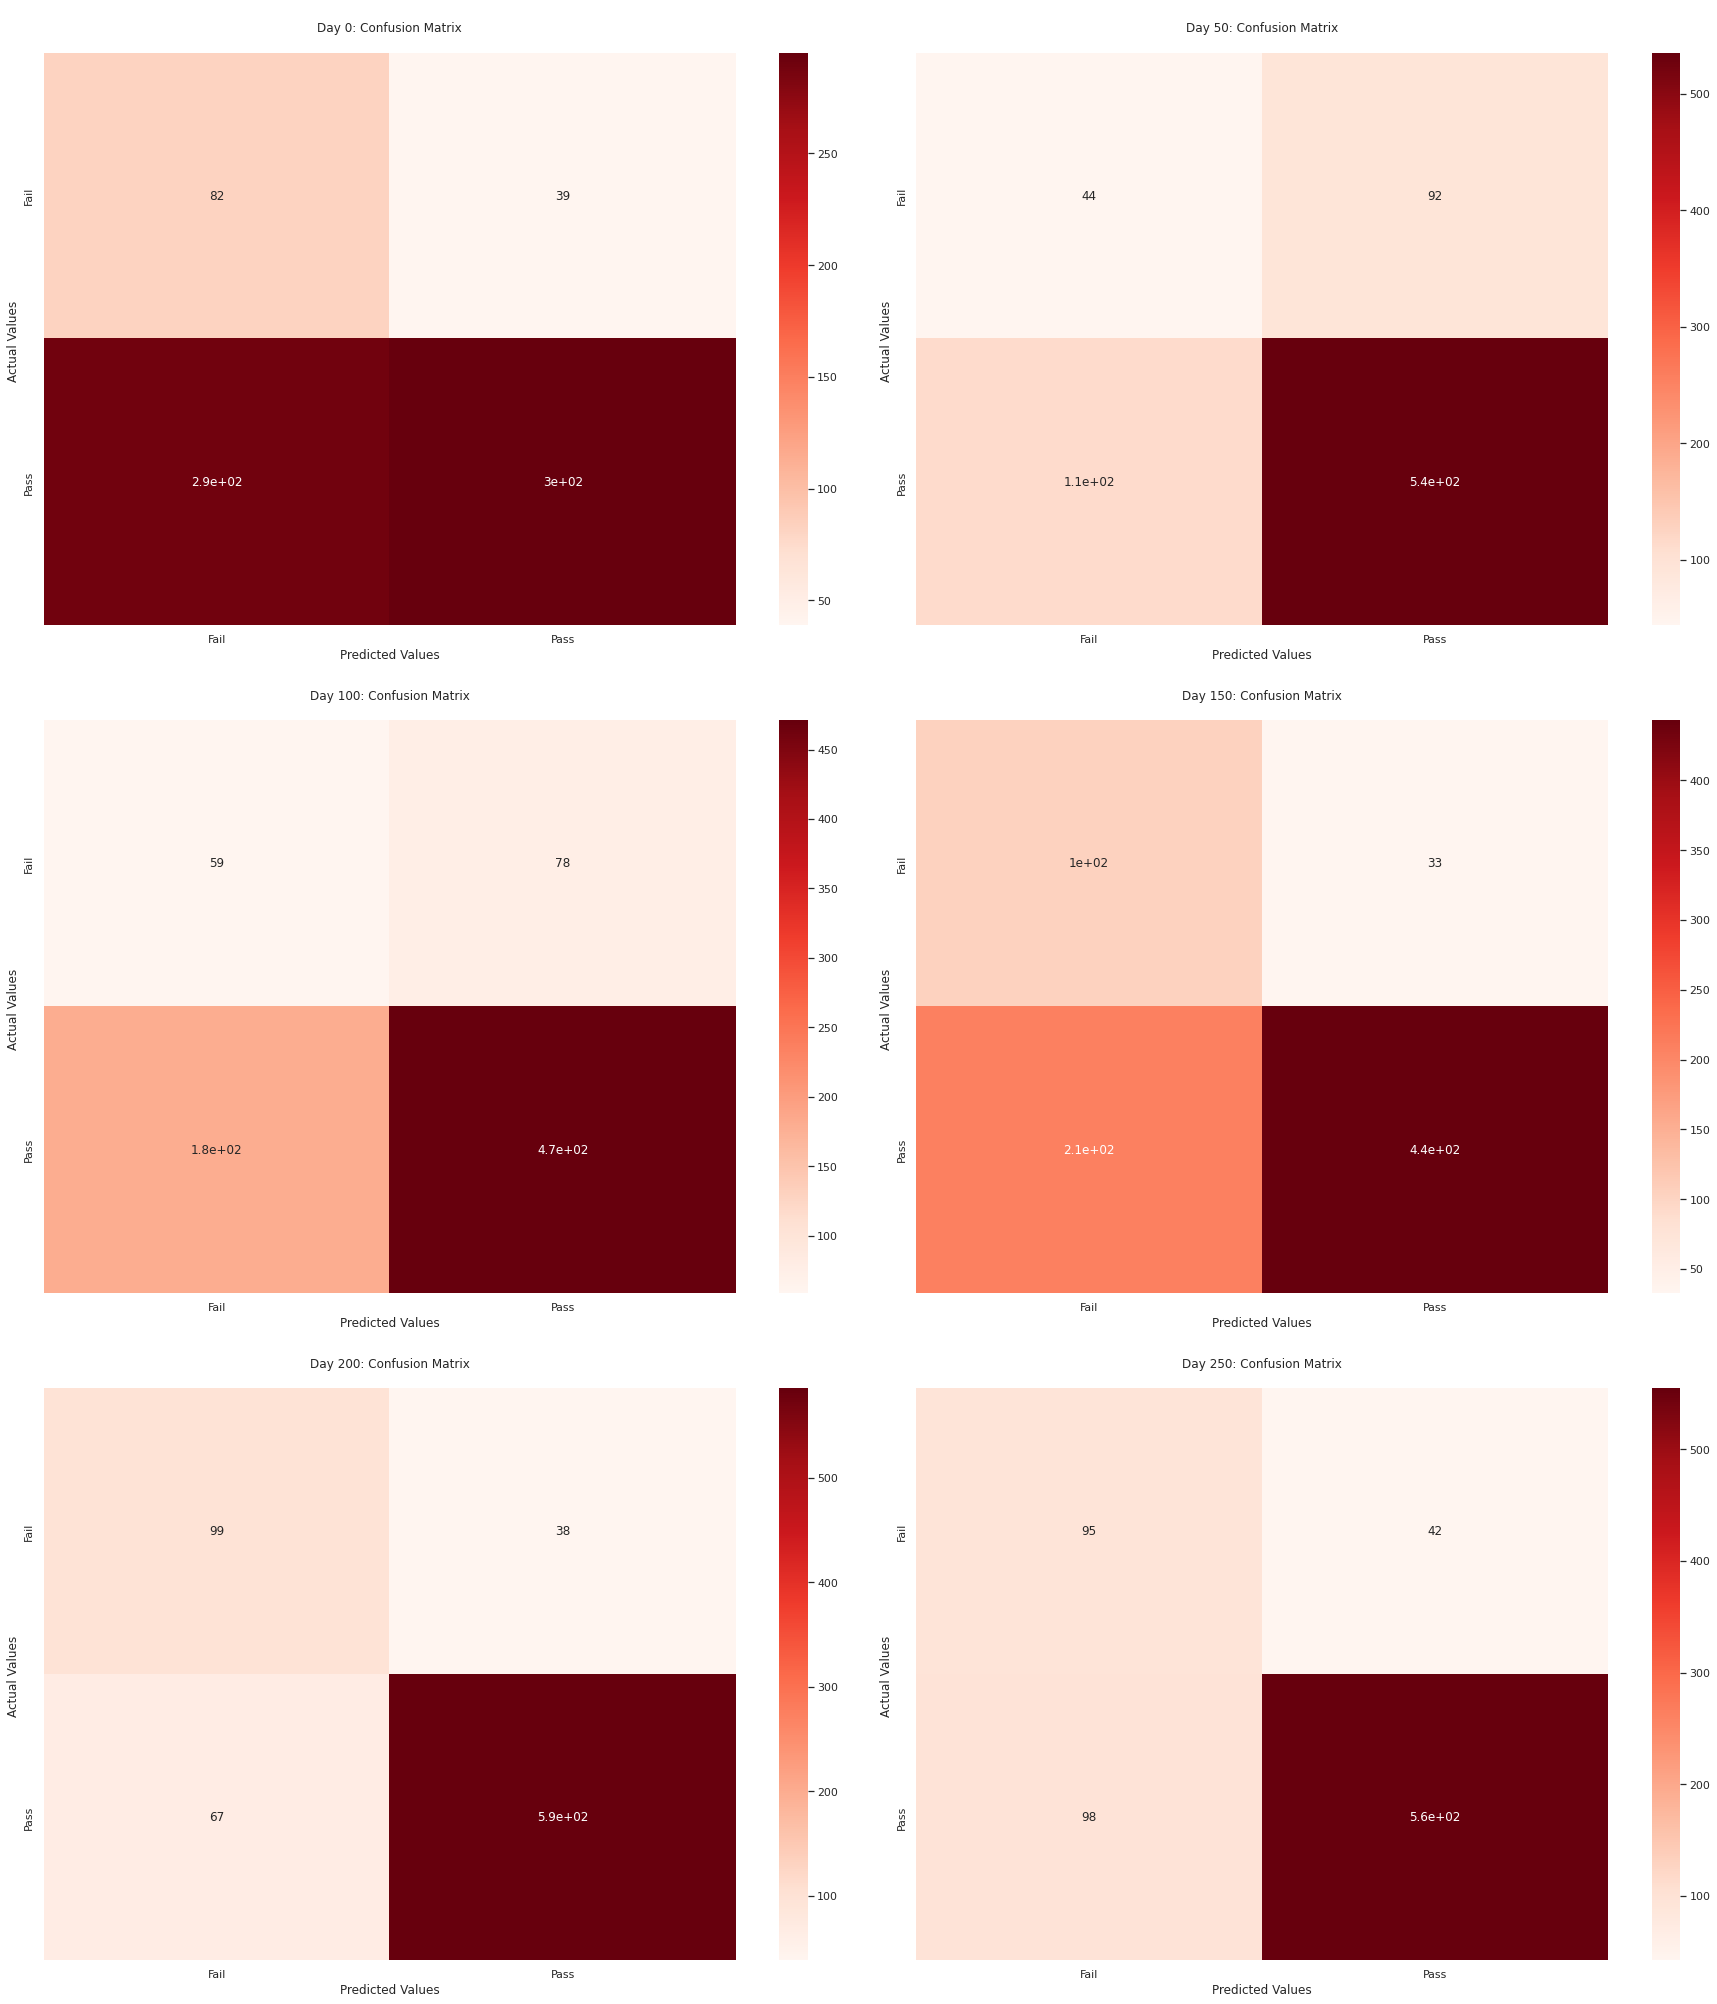

In [59]:
plot_confusion_matrix(learning_behaviour_results_nb)

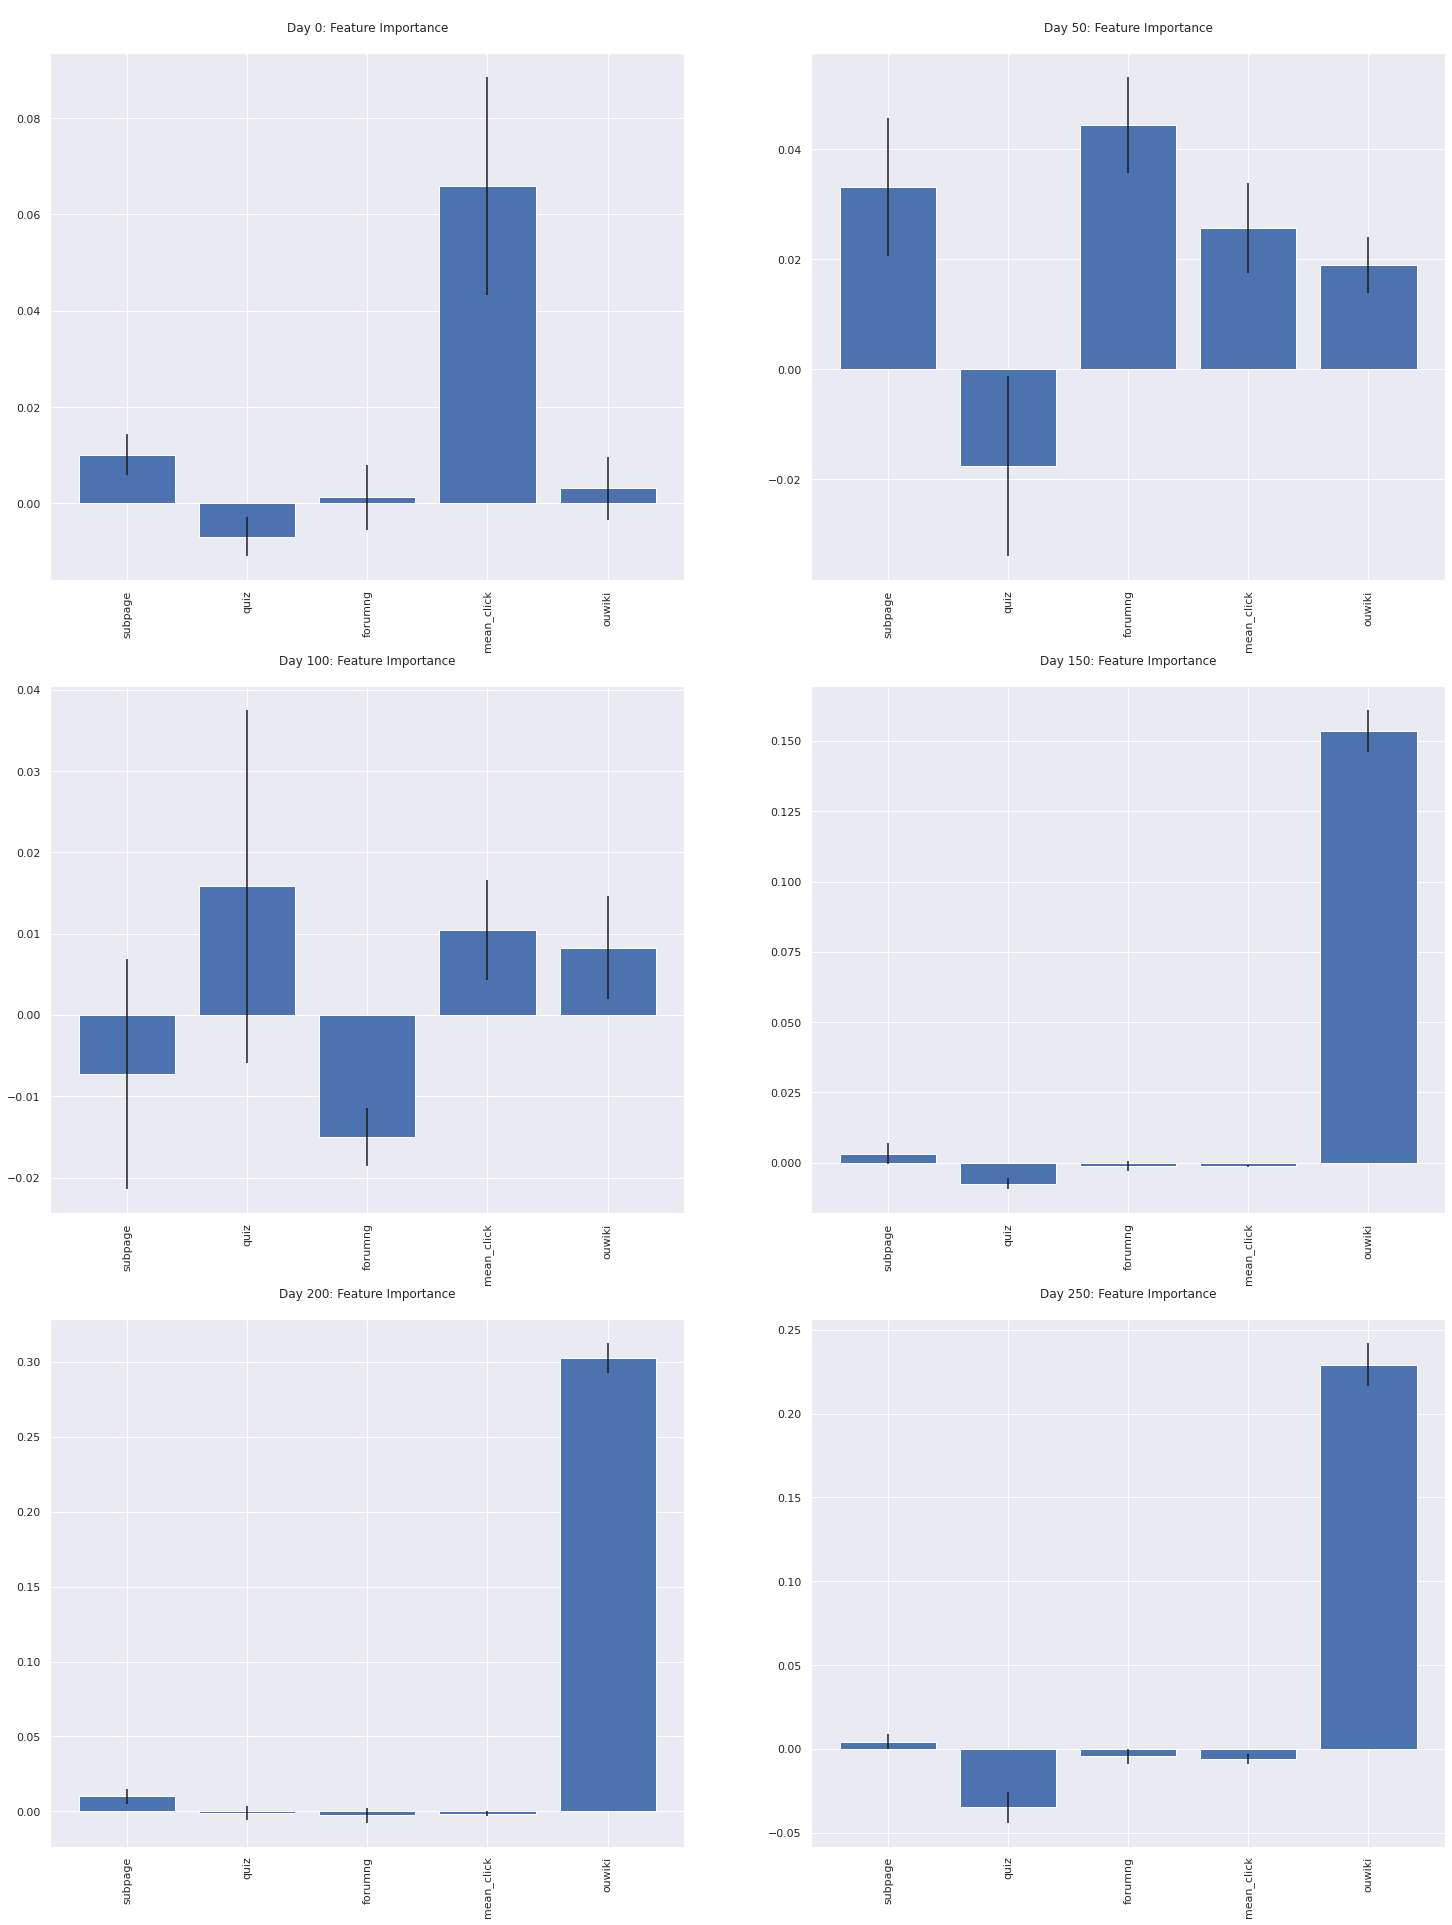

In [60]:
plot_feature_importance(learning_behaviour_features_nb)

##### LogisticRegression

In [61]:
from sklearn.linear_model import LogisticRegression

learning_behaviour_results_lr = []
learning_behiviour_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.447
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.8283687943262411, F1 Score: 0.9061287820015517, Precision: 0.8283687943262411, Recall: 1.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.494
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8267515923566879, F1 Score: 0.9047619047619048, Precision: 0.8292682926829268, Recall: 0.9953775038520801


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.491
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.826362484157161, F1 Score: 0.9041287613715886, Precision: 0.8314028314028314, Recall: 0.99079754601227


Day 150
Perf

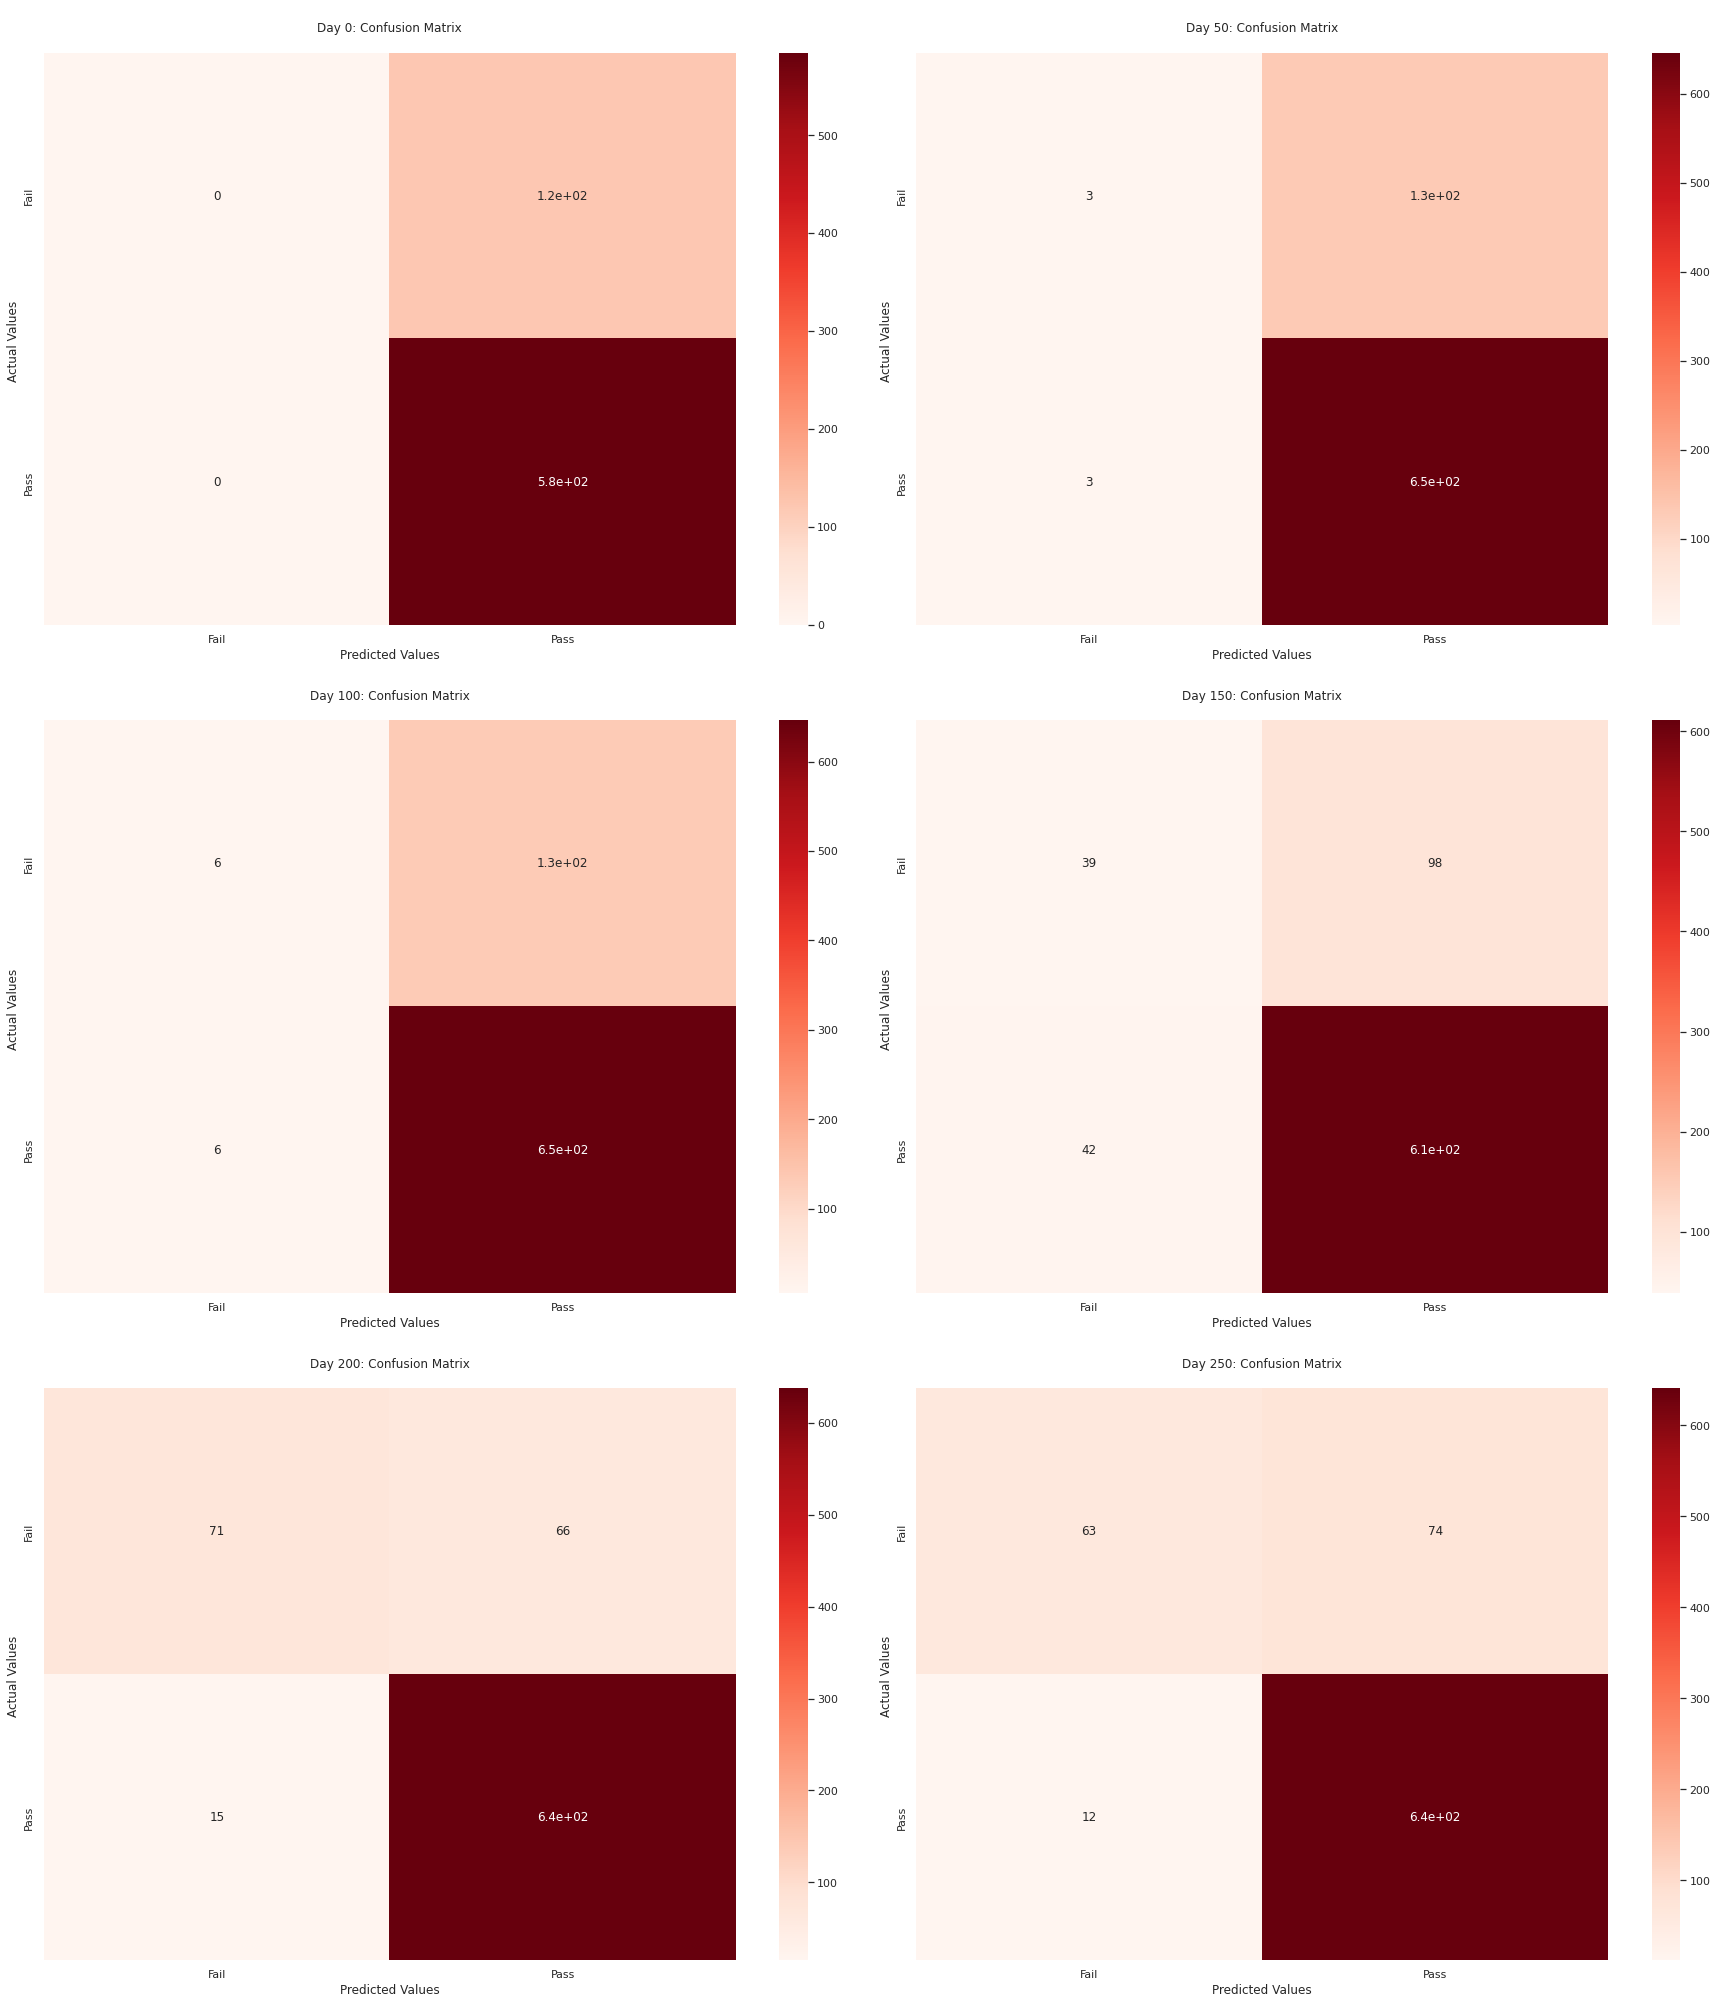

In [62]:
plot_confusion_matrix(learning_behaviour_results_lr)

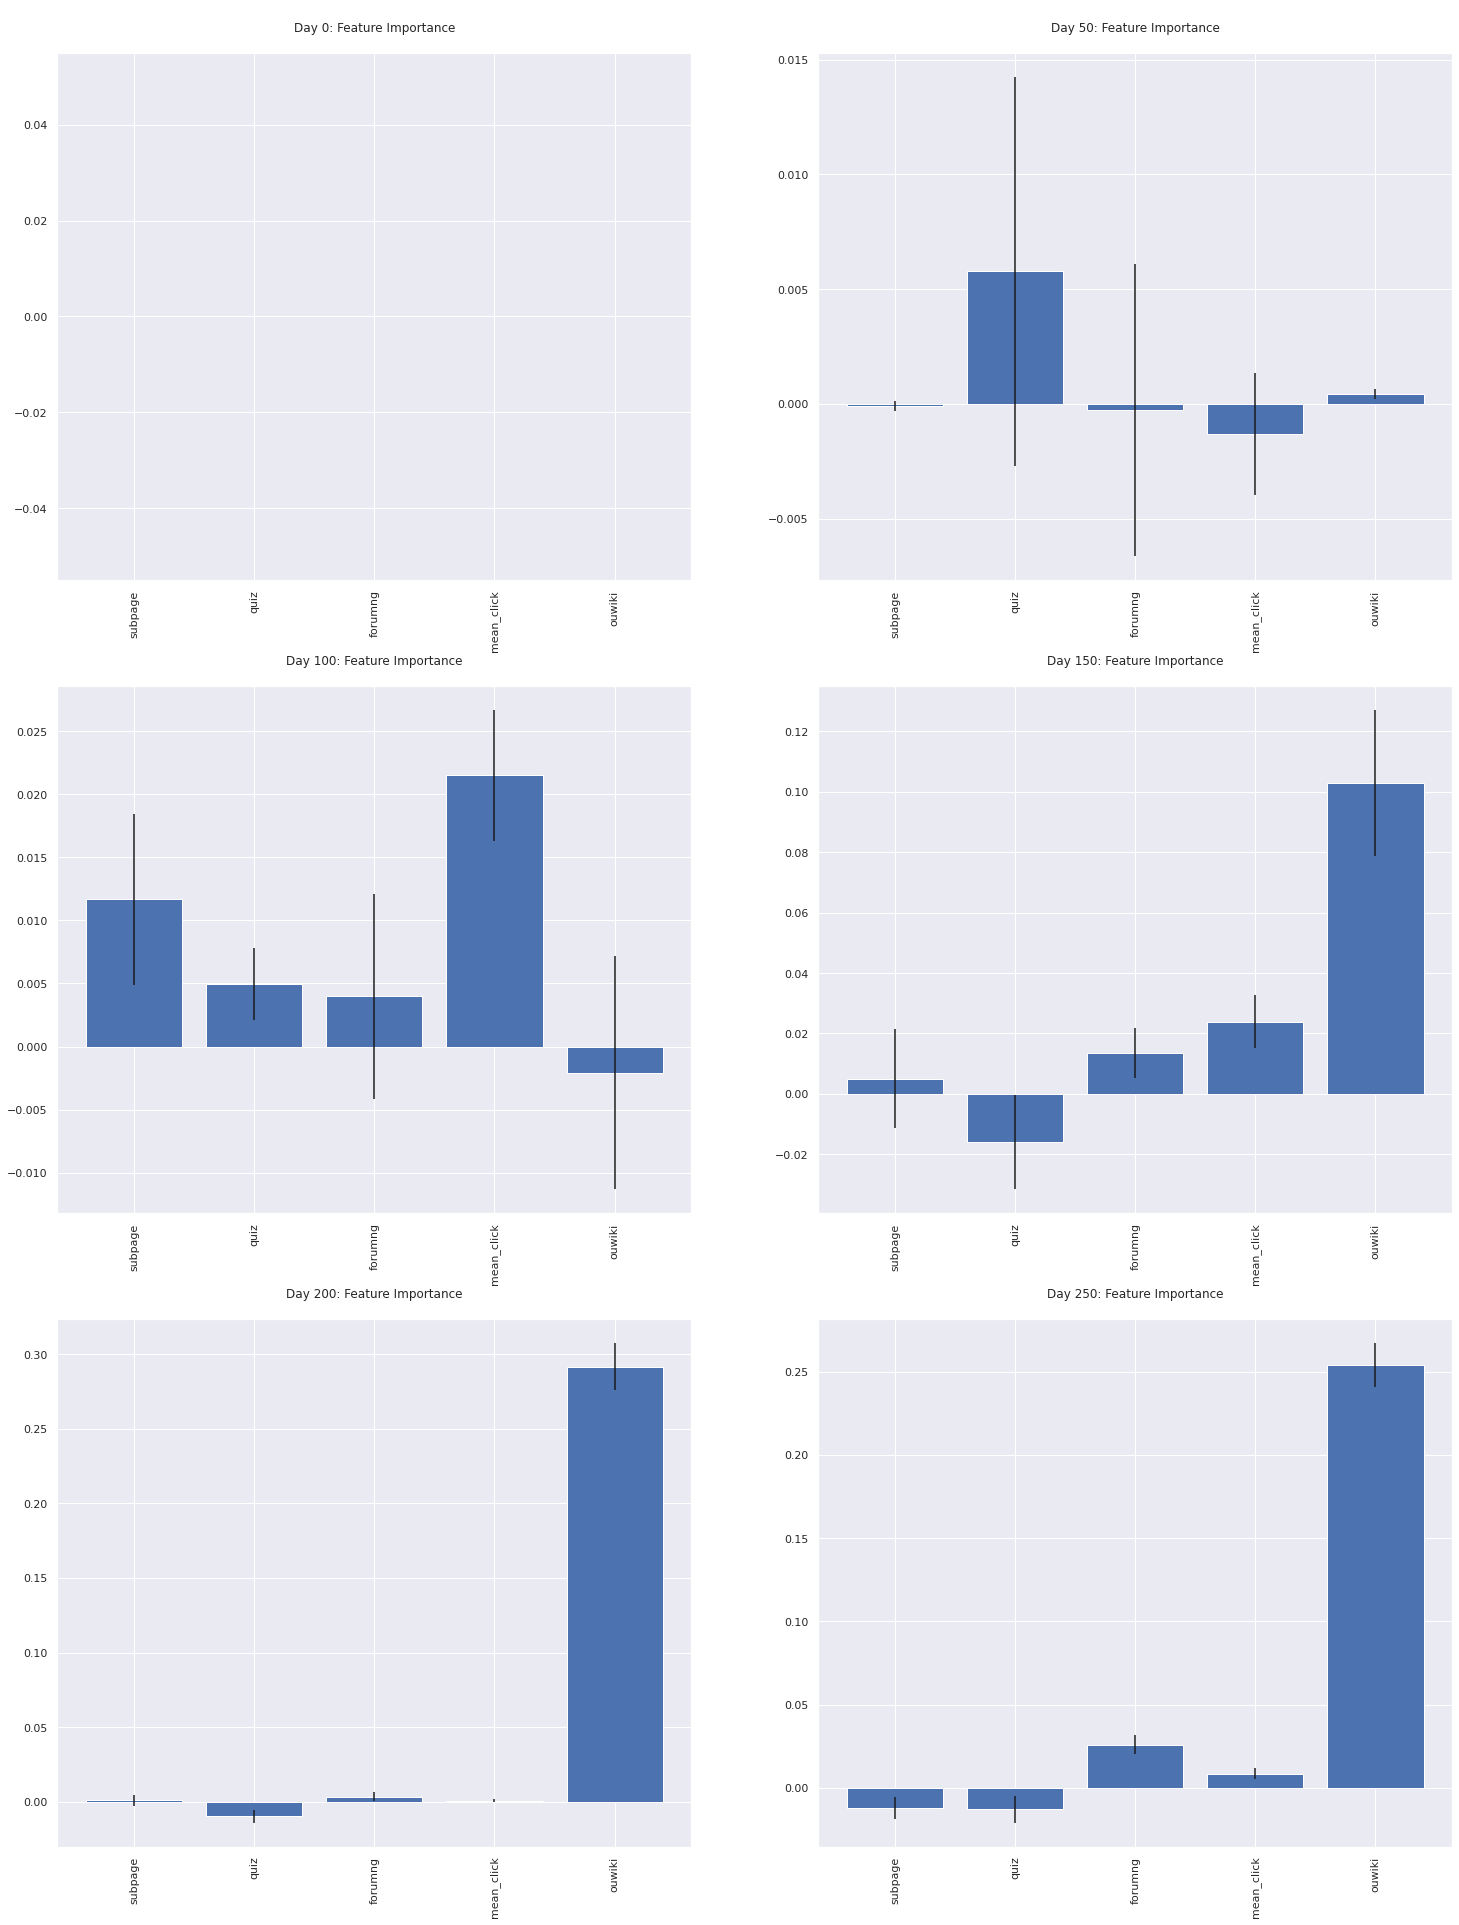

In [63]:
plot_feature_importance(learning_behiviour_features_lr)

##### WeightedLogisticRegression

In [64]:
learning_behaviour_results_lrw = []
learning_behaviour_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_lrw.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.4907801418439716, F1 Score: 0.5897142857142857, Precision: 0.8865979381443299, Recall: 0.4417808219178082


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.517
Best parameters set:
Accuracy: 0.7006369426751592, F1 Score: 0.802686817800168, Precision: 0.8819188191881919, Recall: 0.736517719568567


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.546
Best parameters set:
Accuracy: 0.6996197718631179, F1 Score: 0.8055783429040196, Precision: 0.8659611992945326, Recall: 0.7530674846625767


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.726
Best p

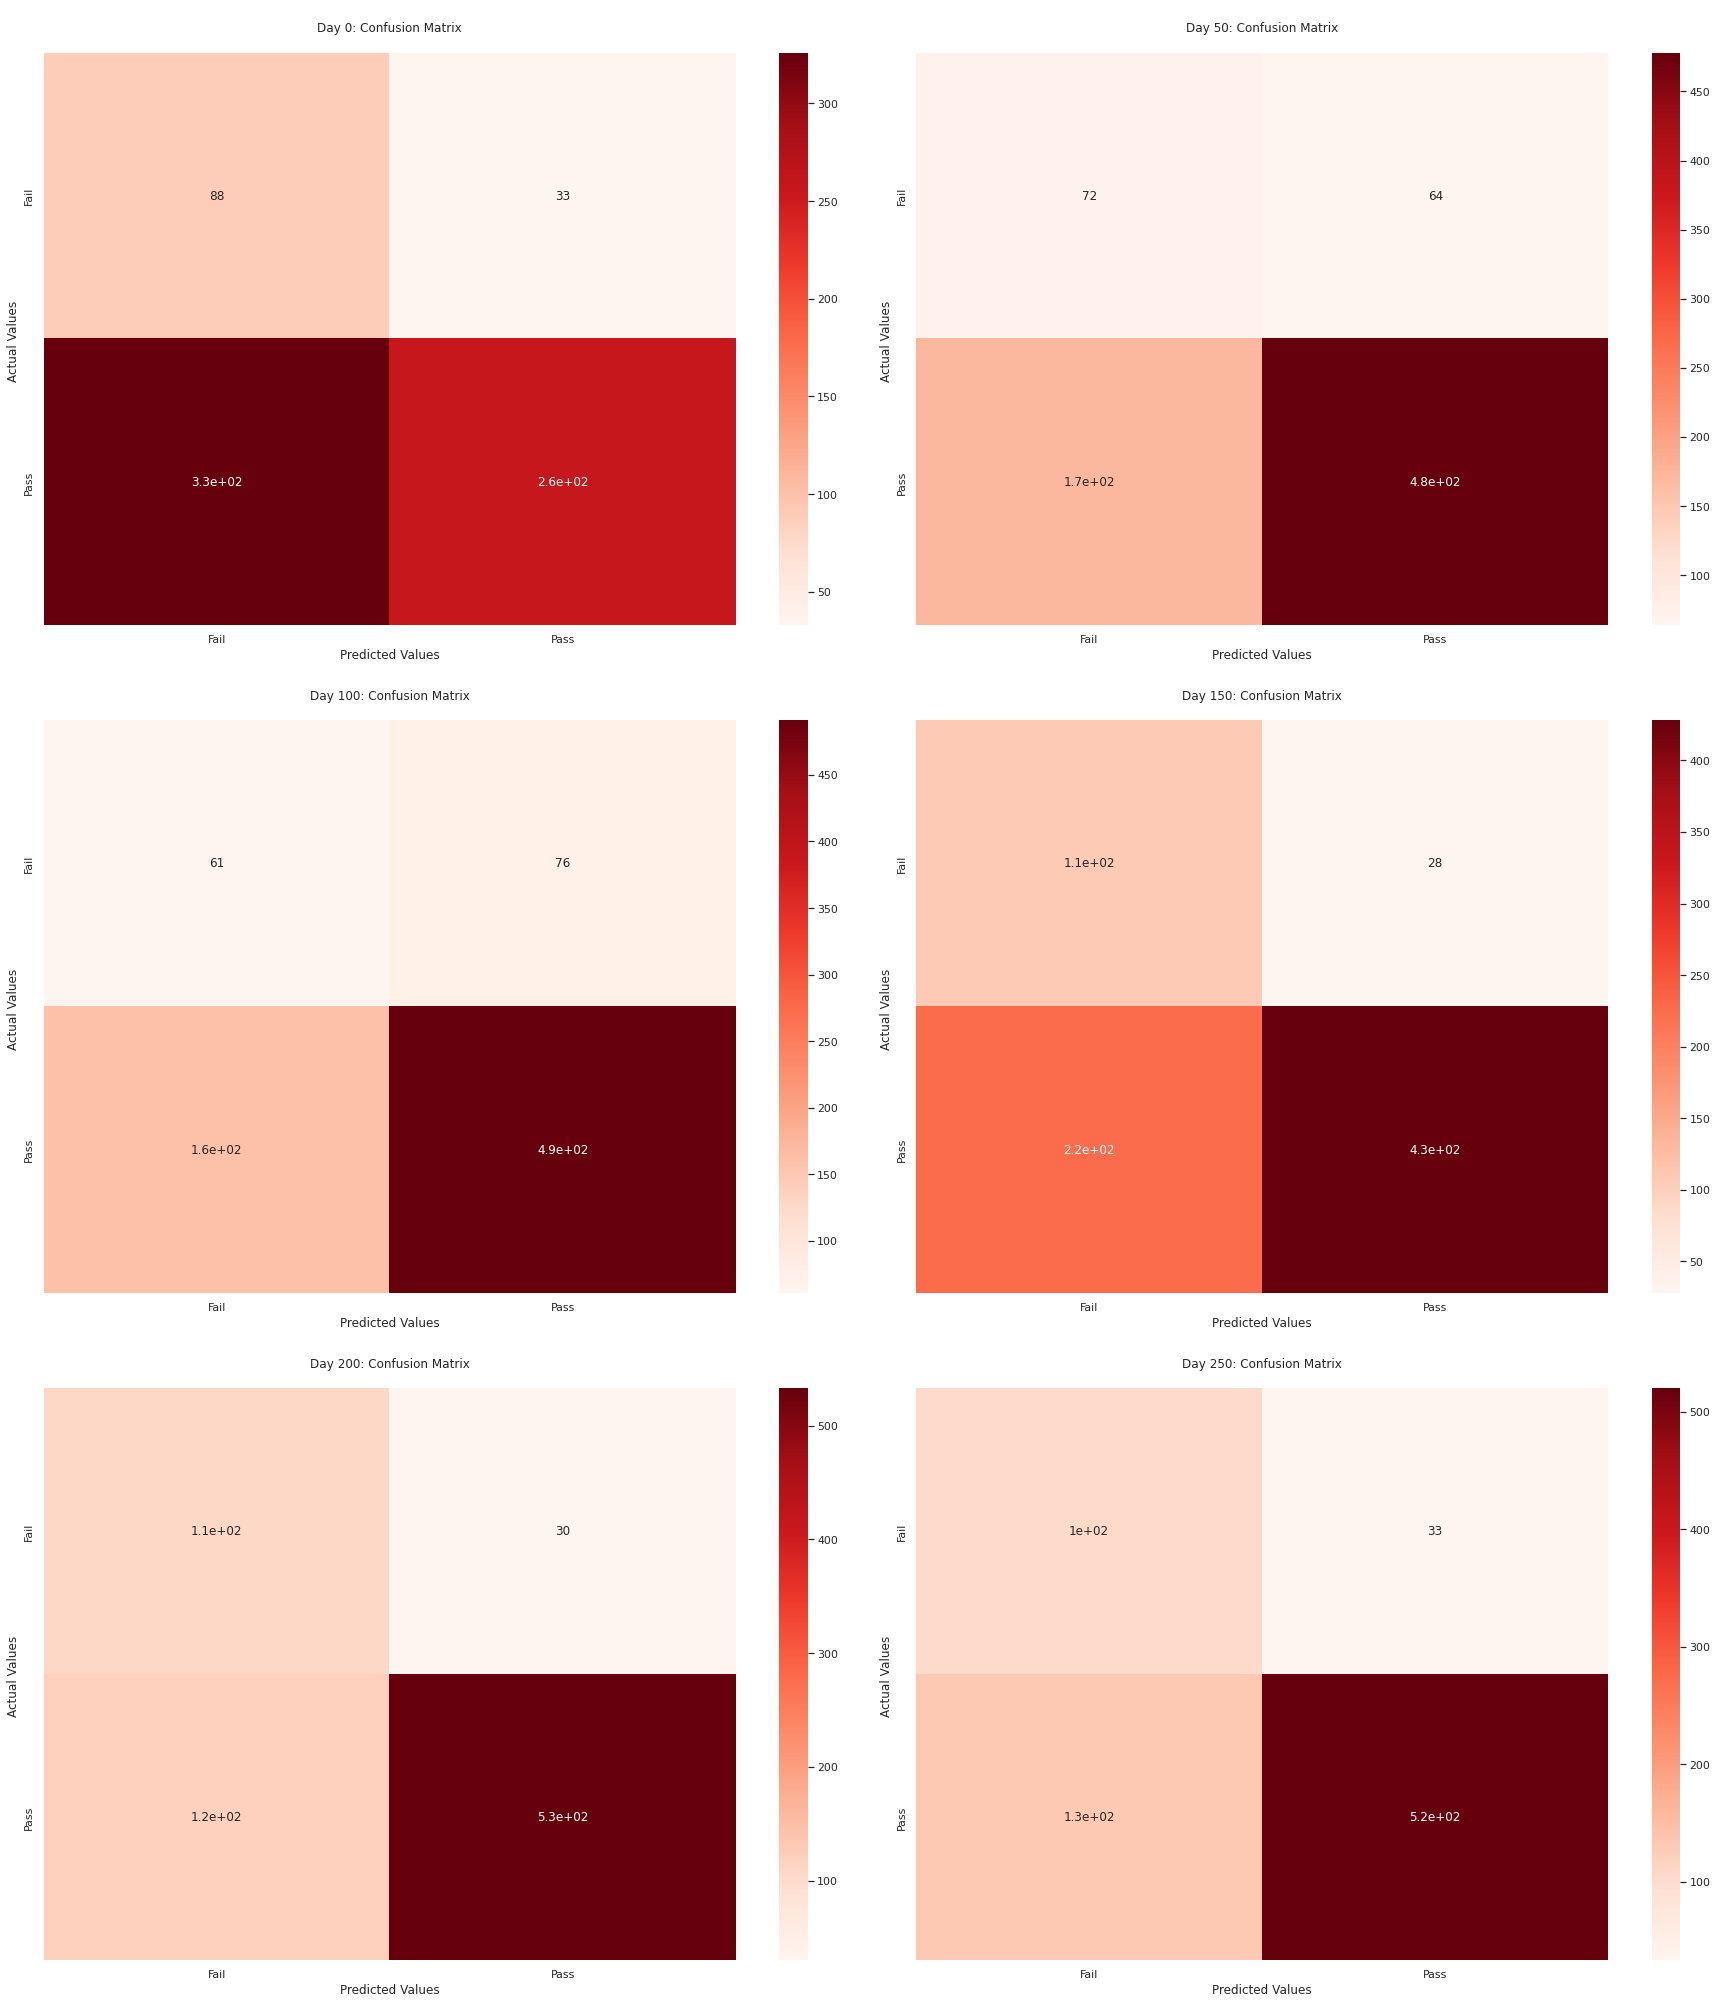

In [65]:
plot_confusion_matrix(learning_behaviour_results_lrw)

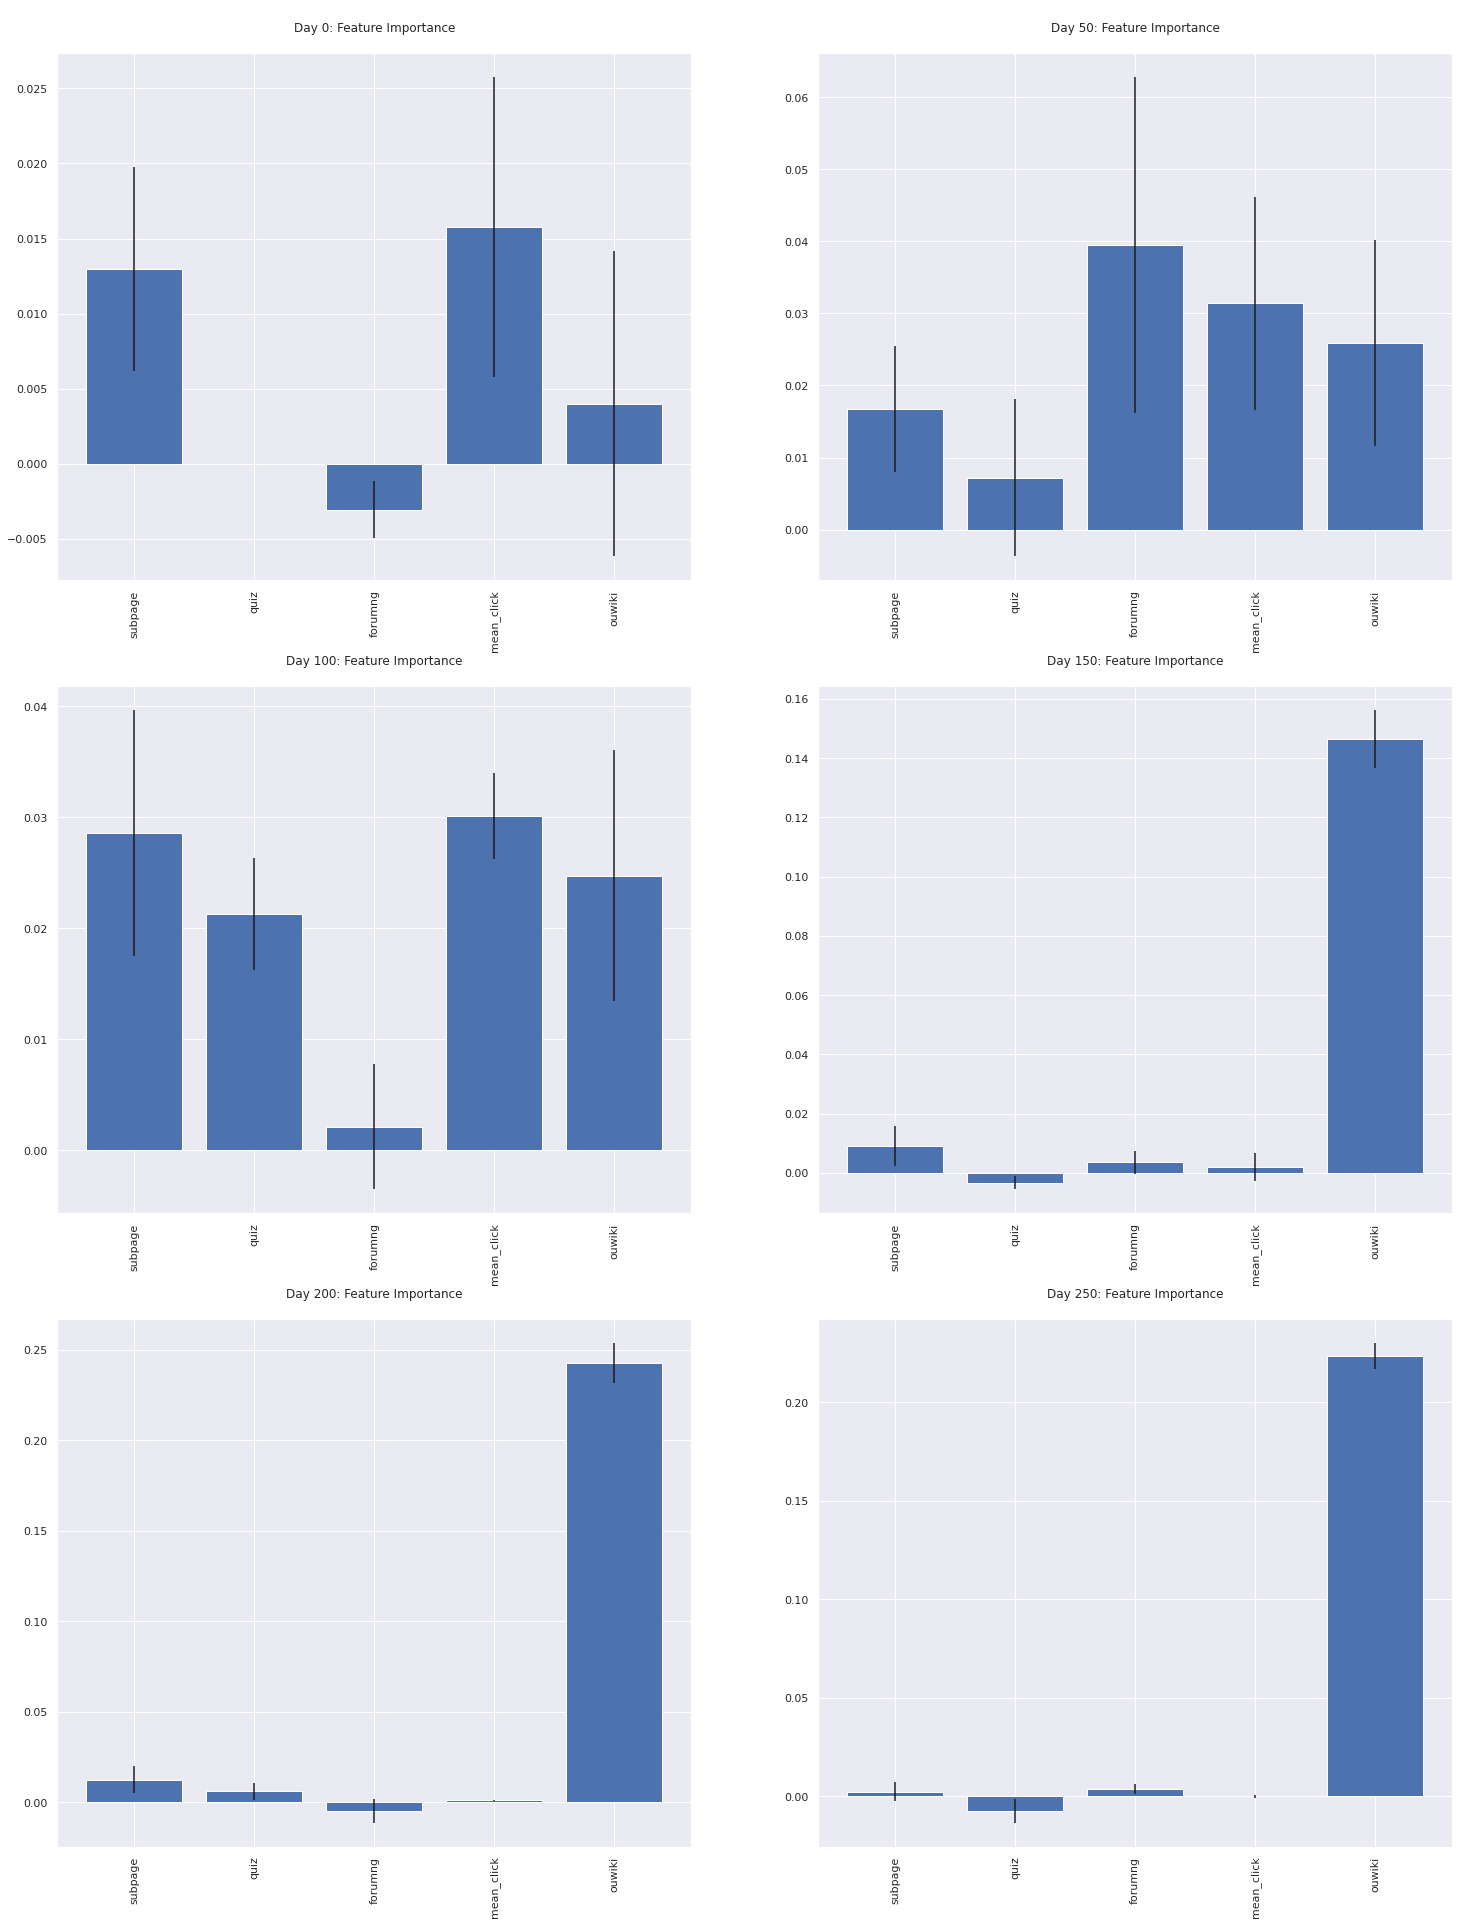

In [66]:
plot_feature_importance(learning_behaviour_features_lrw)

##### RandomForest

In [67]:
from sklearn.ensemble import RandomForestClassifier

learning_behaviour_results_rf = []
learning_behaviour_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.519
Best parameters set:
	clf__n_estimators: 80
Accuracy: 0.775886524822695, F1 Score: 0.8713355048859935, Precision: 0.8307453416149069, Recall: 0.916095890410959


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.534
Best parameters set:
	clf__n_estimators: 120
Accuracy: 0.8127388535031848, F1 Score: 0.8959660297239915, Precision: 0.8285340314136126, Recall: 0.975346687211094


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.547
Best parameters set:
	clf__n_estimators: 

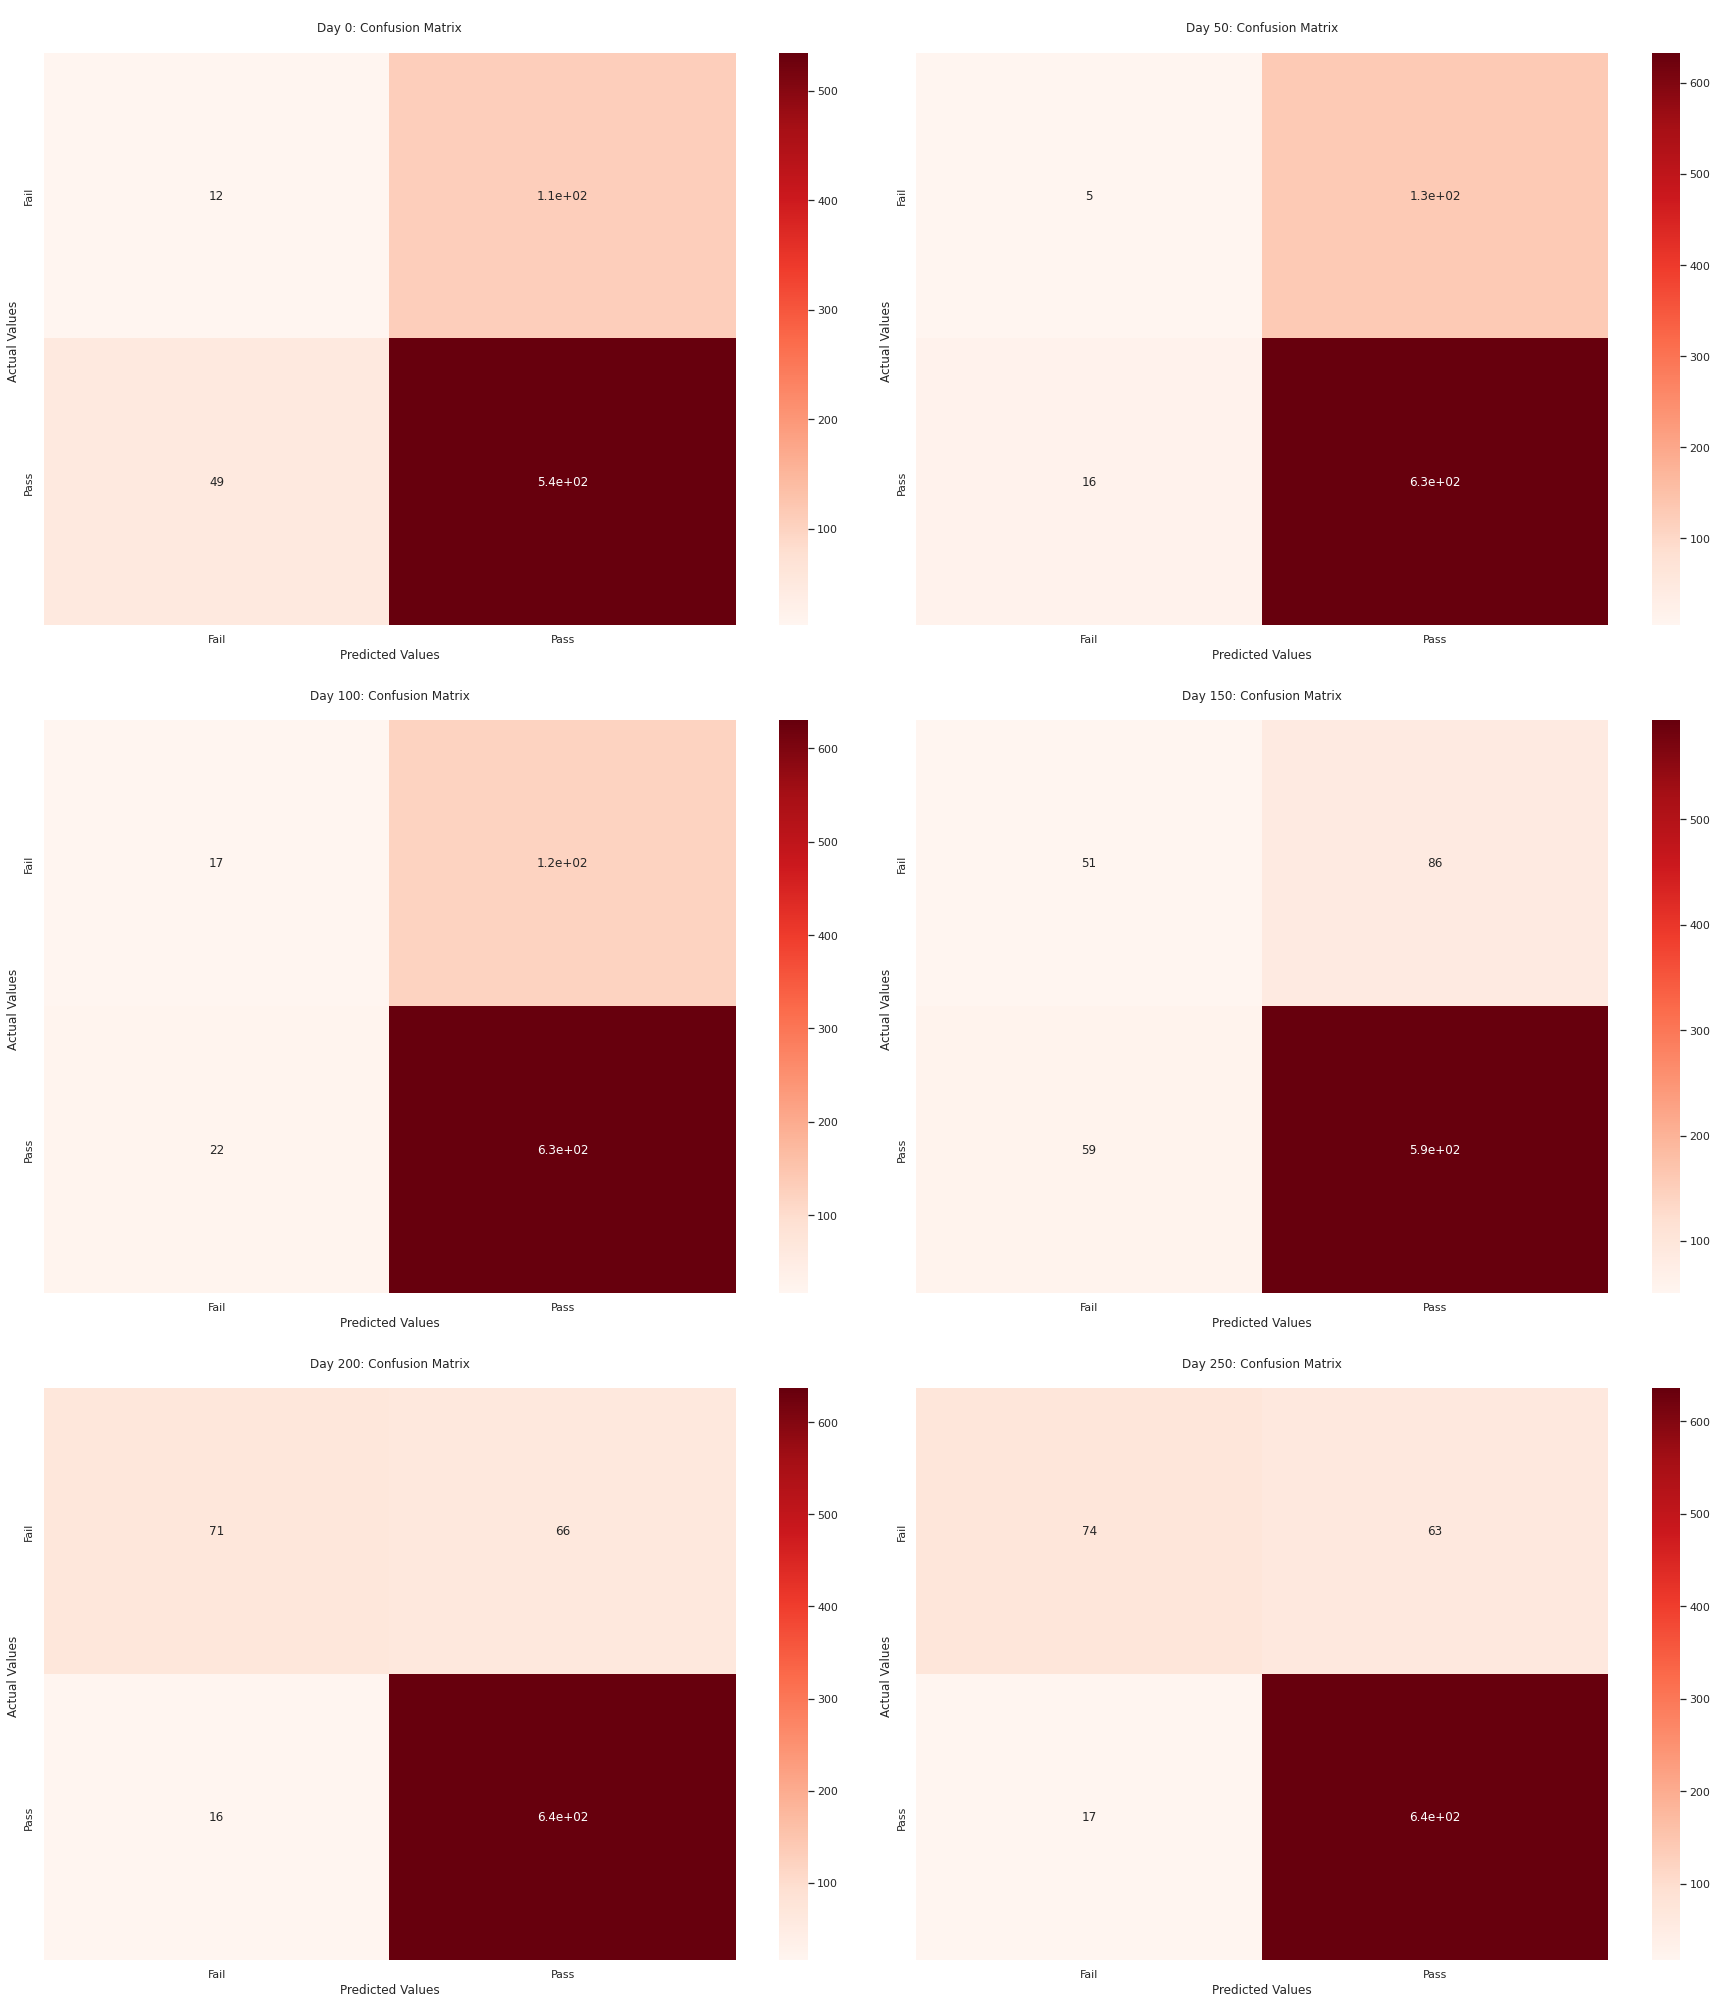

In [68]:
plot_confusion_matrix(learning_behaviour_results_rf)

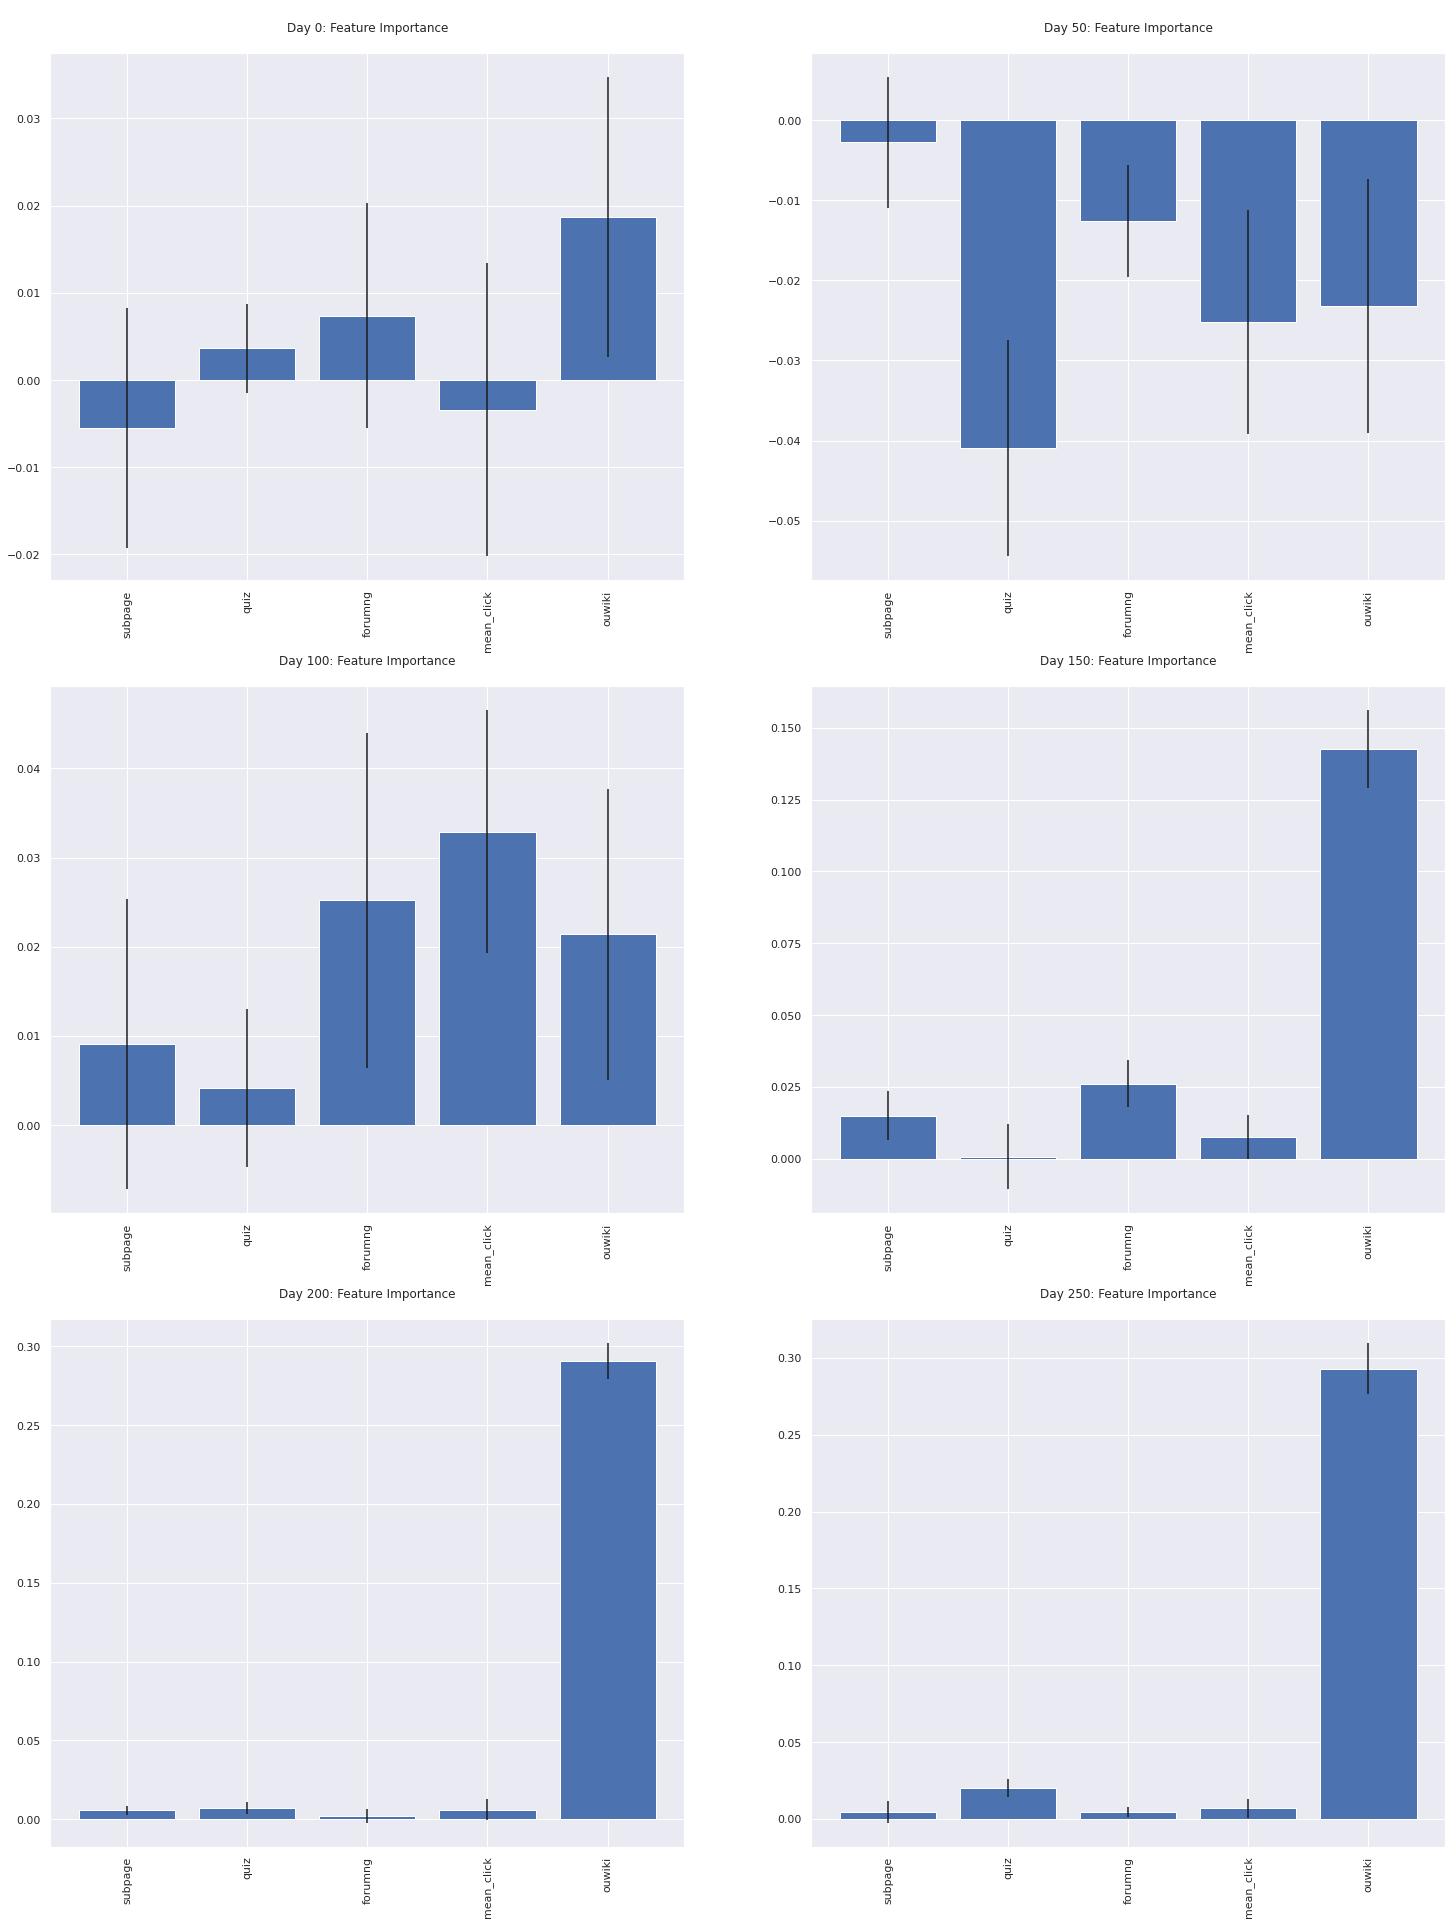

In [69]:
plot_feature_importance(learning_behaviour_features_rf)

##### AdaBoost

In [70]:
from sklearn.ensemble import AdaBoostClassifier

learning_behaviour_results_ab = []
learning_behiviour_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_ab.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.521
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8184397163120567, F1 Score: 0.9001560062402496, Precision: 0.826647564469914, Recall: 0.988013698630137


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.541
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.7936305732484077, F1 Score: 0.8839541547277937, Precision: 0.8259705488621151, Recall: 0.9506933744221879


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.553
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7997465145754119, F1 S

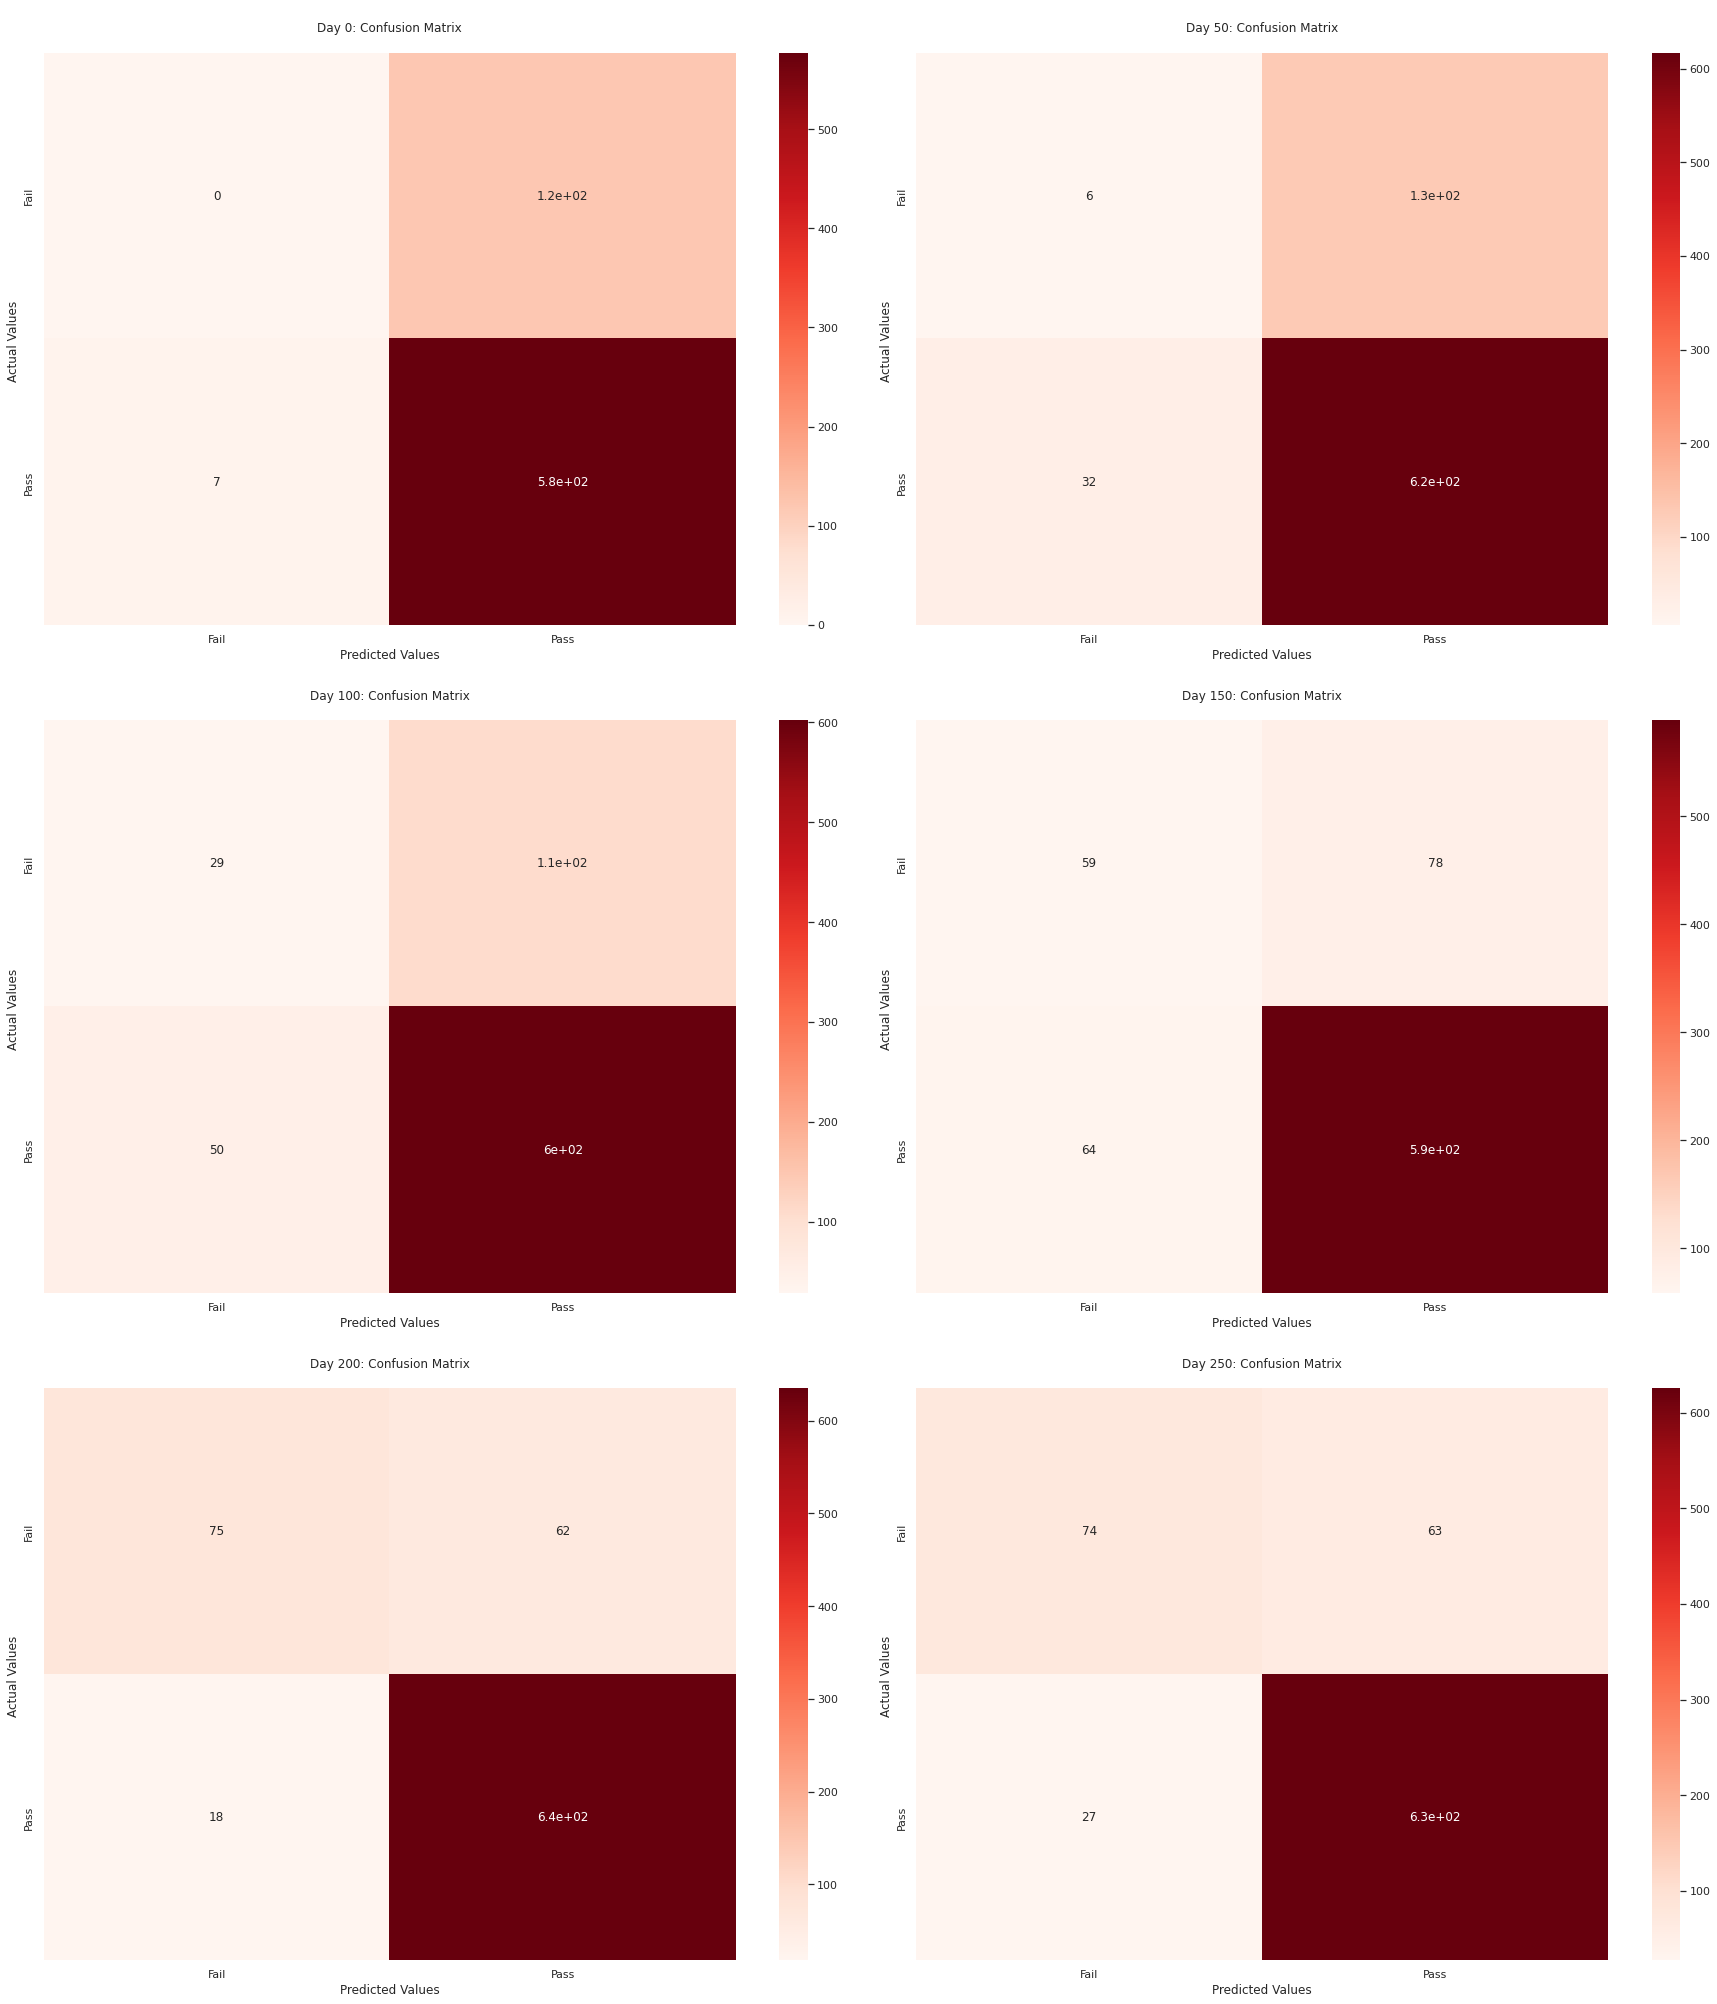

In [71]:
plot_confusion_matrix(learning_behaviour_results_ab)

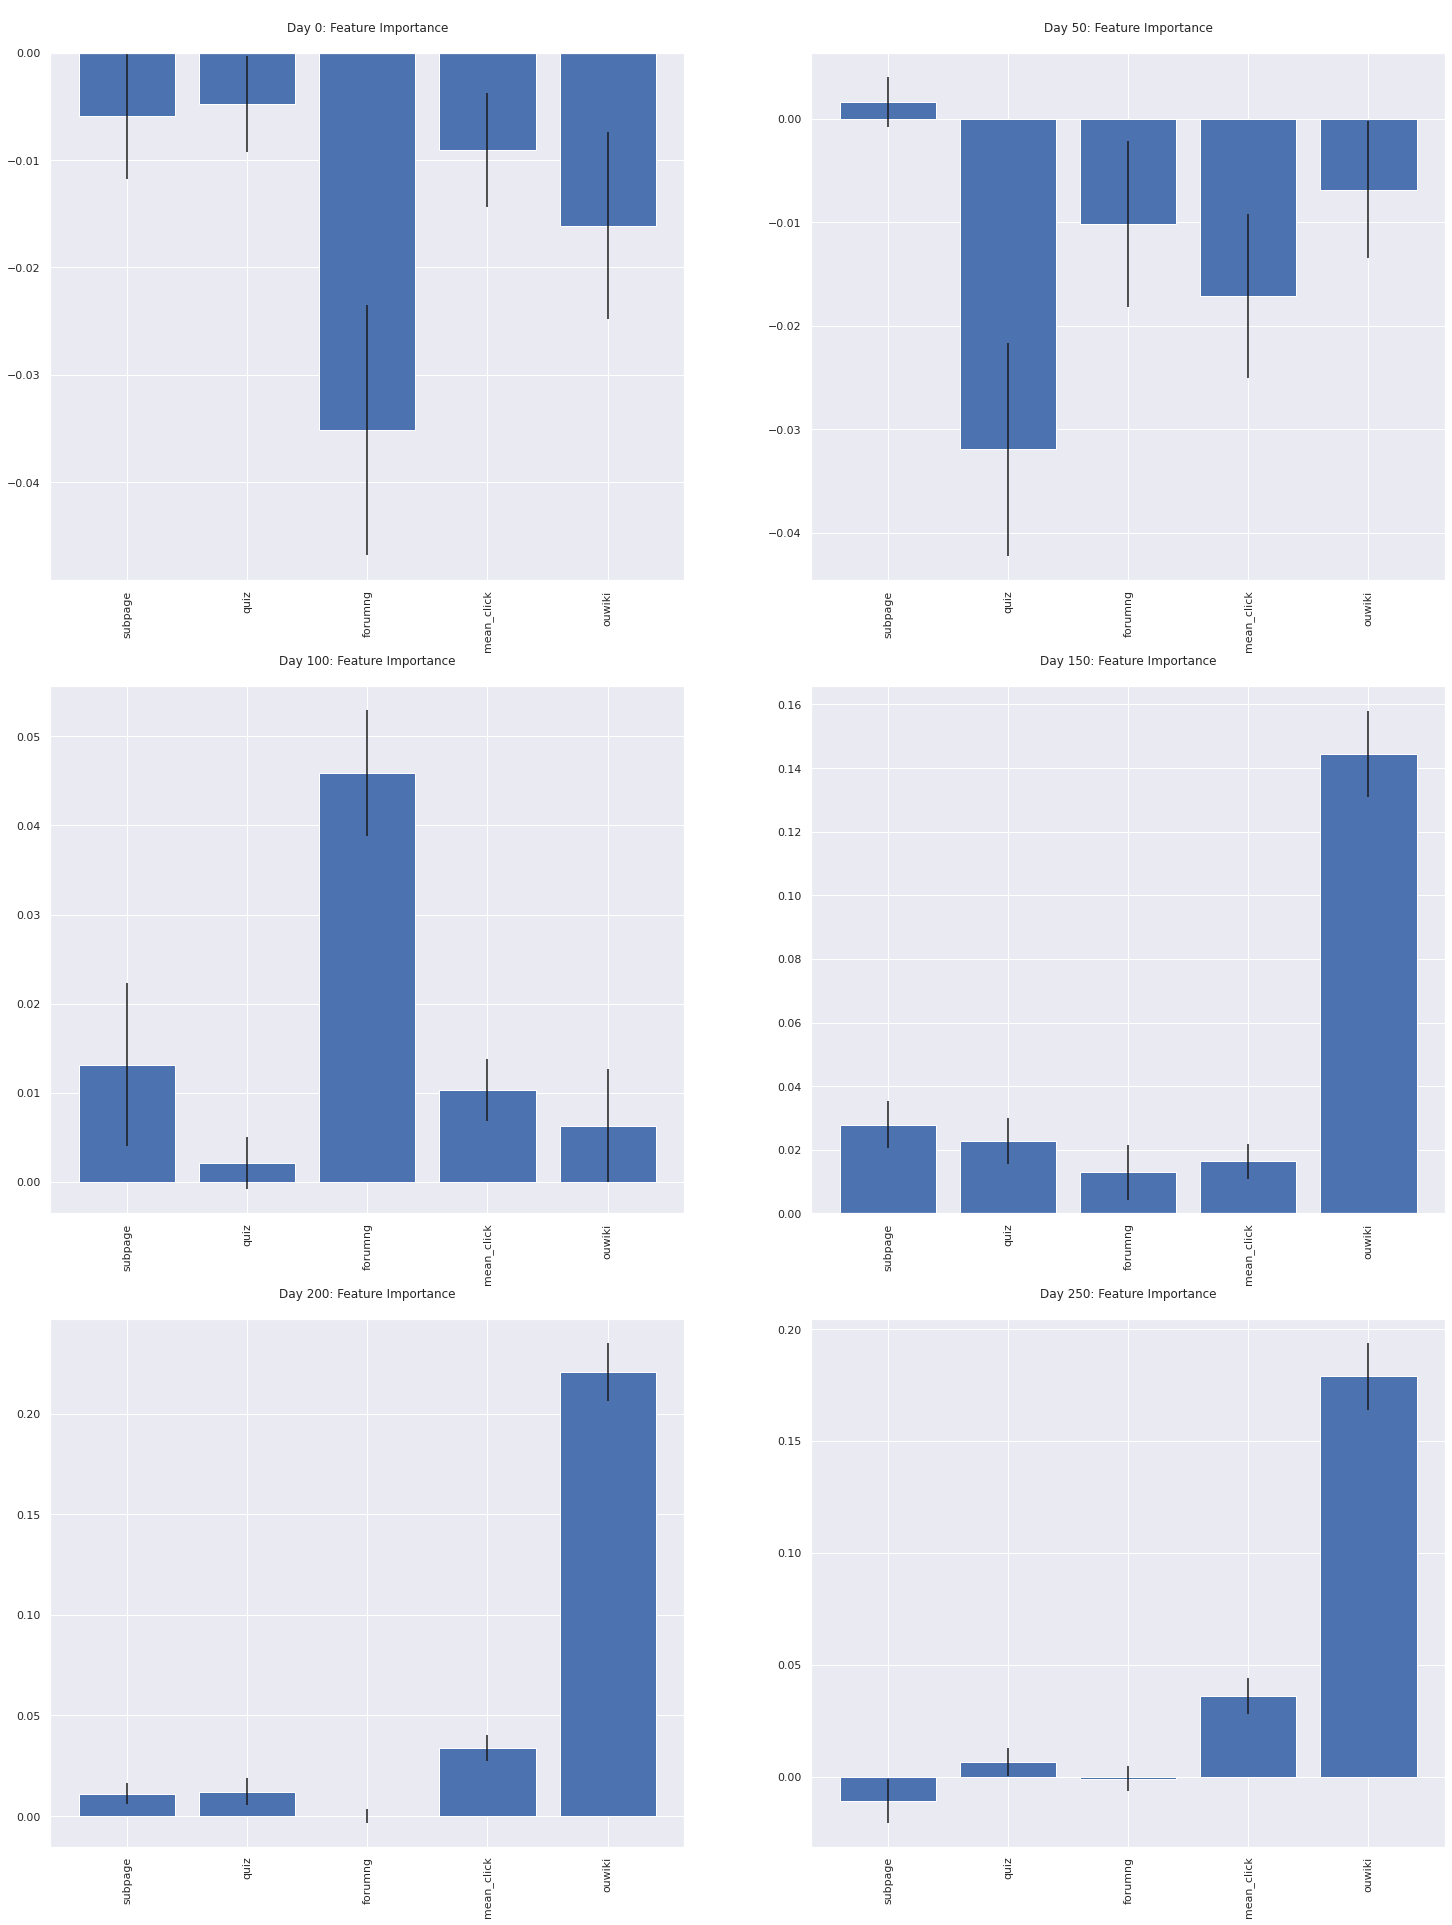

In [72]:
plot_feature_importance(learning_behiviour_features_ab)

##### Plot results overview

In [73]:
learning_behaviour_classifier_results = [learning_behaviour_results_du, learning_behaviour_results_nb, learning_behaviour_results_lr, learning_behaviour_results_lrw, learning_behaviour_results_rf, learning_behaviour_results_ab]
learning_behaviour_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

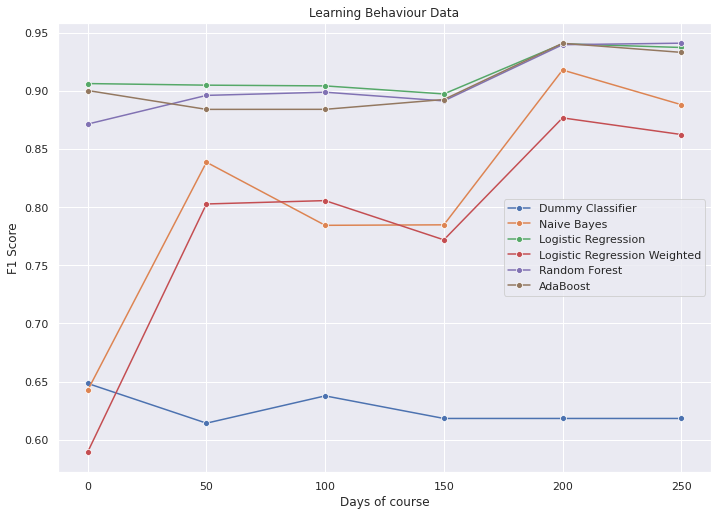

In [74]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

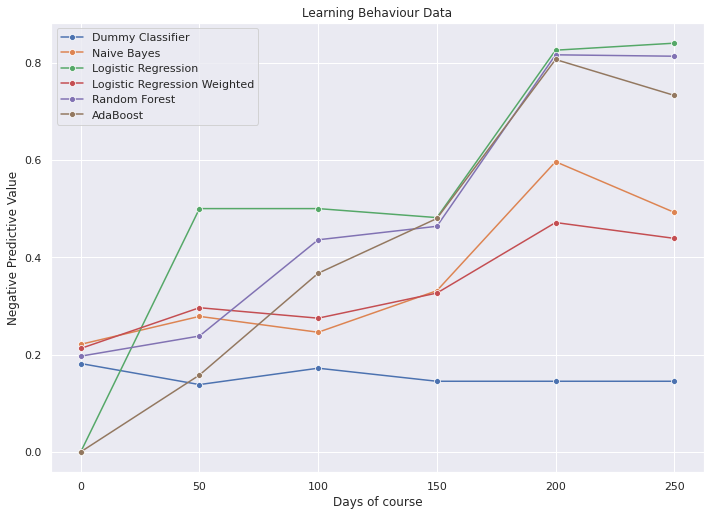

In [75]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

#### Performance data

##### Prepare data for prediction

In [76]:
performance_df = {}
for i in list(df.keys())[1:]:
  performance_df[i] = split_dataframe_by_data_type(df[i], ['performance'], include_final_result=True)

In [77]:
performance_df[50]

code_presentation  id_student  score  weighted_score  final_result
0                2013J       35355   86.0          13.846             1
1                2013J       42638   83.0          13.363             1
2                2013J       43564   94.0          15.134             1
3                2013J       54062   78.0          12.558             1
4                2013J       63112   88.0          14.168             1
...                ...         ...    ...             ...           ...
1943             2014J     2644404   87.0          14.007             1
1944             2014J     2654928   91.0          14.651             1
1945             2014J     2663195   91.0          14.651             1
1946             2014J     2686053   86.0          13.846             1
1947             2014J     2686712  100.0          16.100             0

[1948 rows x 5 columns]

###### Encode data

In [78]:
X_train, X_test, Y_train, Y_test = encode_data(performance_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')


In [79]:
X_train[50]

score  weighted_score
0    0.810811        0.810811
1    0.770270        0.770270
2    0.918919        0.918919
3    0.702703        0.702703
4    0.837838        0.837838
..        ...             ...
702  0.554054        0.554054
703  0.527027        0.527027
704  0.770270        0.770270
705  0.743243        0.743243
706  0.472973        0.472973

[707 rows x 2 columns]

###### Undersampling

In [80]:
Y_train[50].value_counts()

1    567
0    140
Name: final_result, dtype: int64

In [81]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in list(df.keys())[1:]:

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 50
Original dataset shape: Counter({1: 567, 0: 140})
Resample dataset shape Counter({0: 140, 1: 140})
Sampling for day 100
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 150
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 200
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})
Sampling for day 250
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({0: 141, 1: 141})


##### DummyClassifier

In [82]:
from sklearn.dummy import DummyClassifier

performance_results_du = []
performance_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_du.append([acc, f1, prec, recall, conf])
  performance_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.468
Best parameters set:
Accuracy: 0.4802547770700637, F1 Score: 0.614366729678639, Precision: 0.7946210268948656, Recall: 0.5007704160246533


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best parameters set:
Accuracy: 0.5120405576679341, F1 Score: 0.6378174976481655, Precision: 0.8248175182481752, Recall: 0.5199386503067485


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best parameters set:
Accuracy: 0.4860759493670886, F1 Score: 0.618421052631579, Precision: 0.8004866180048662, Recall: 0.5038284839203675


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best

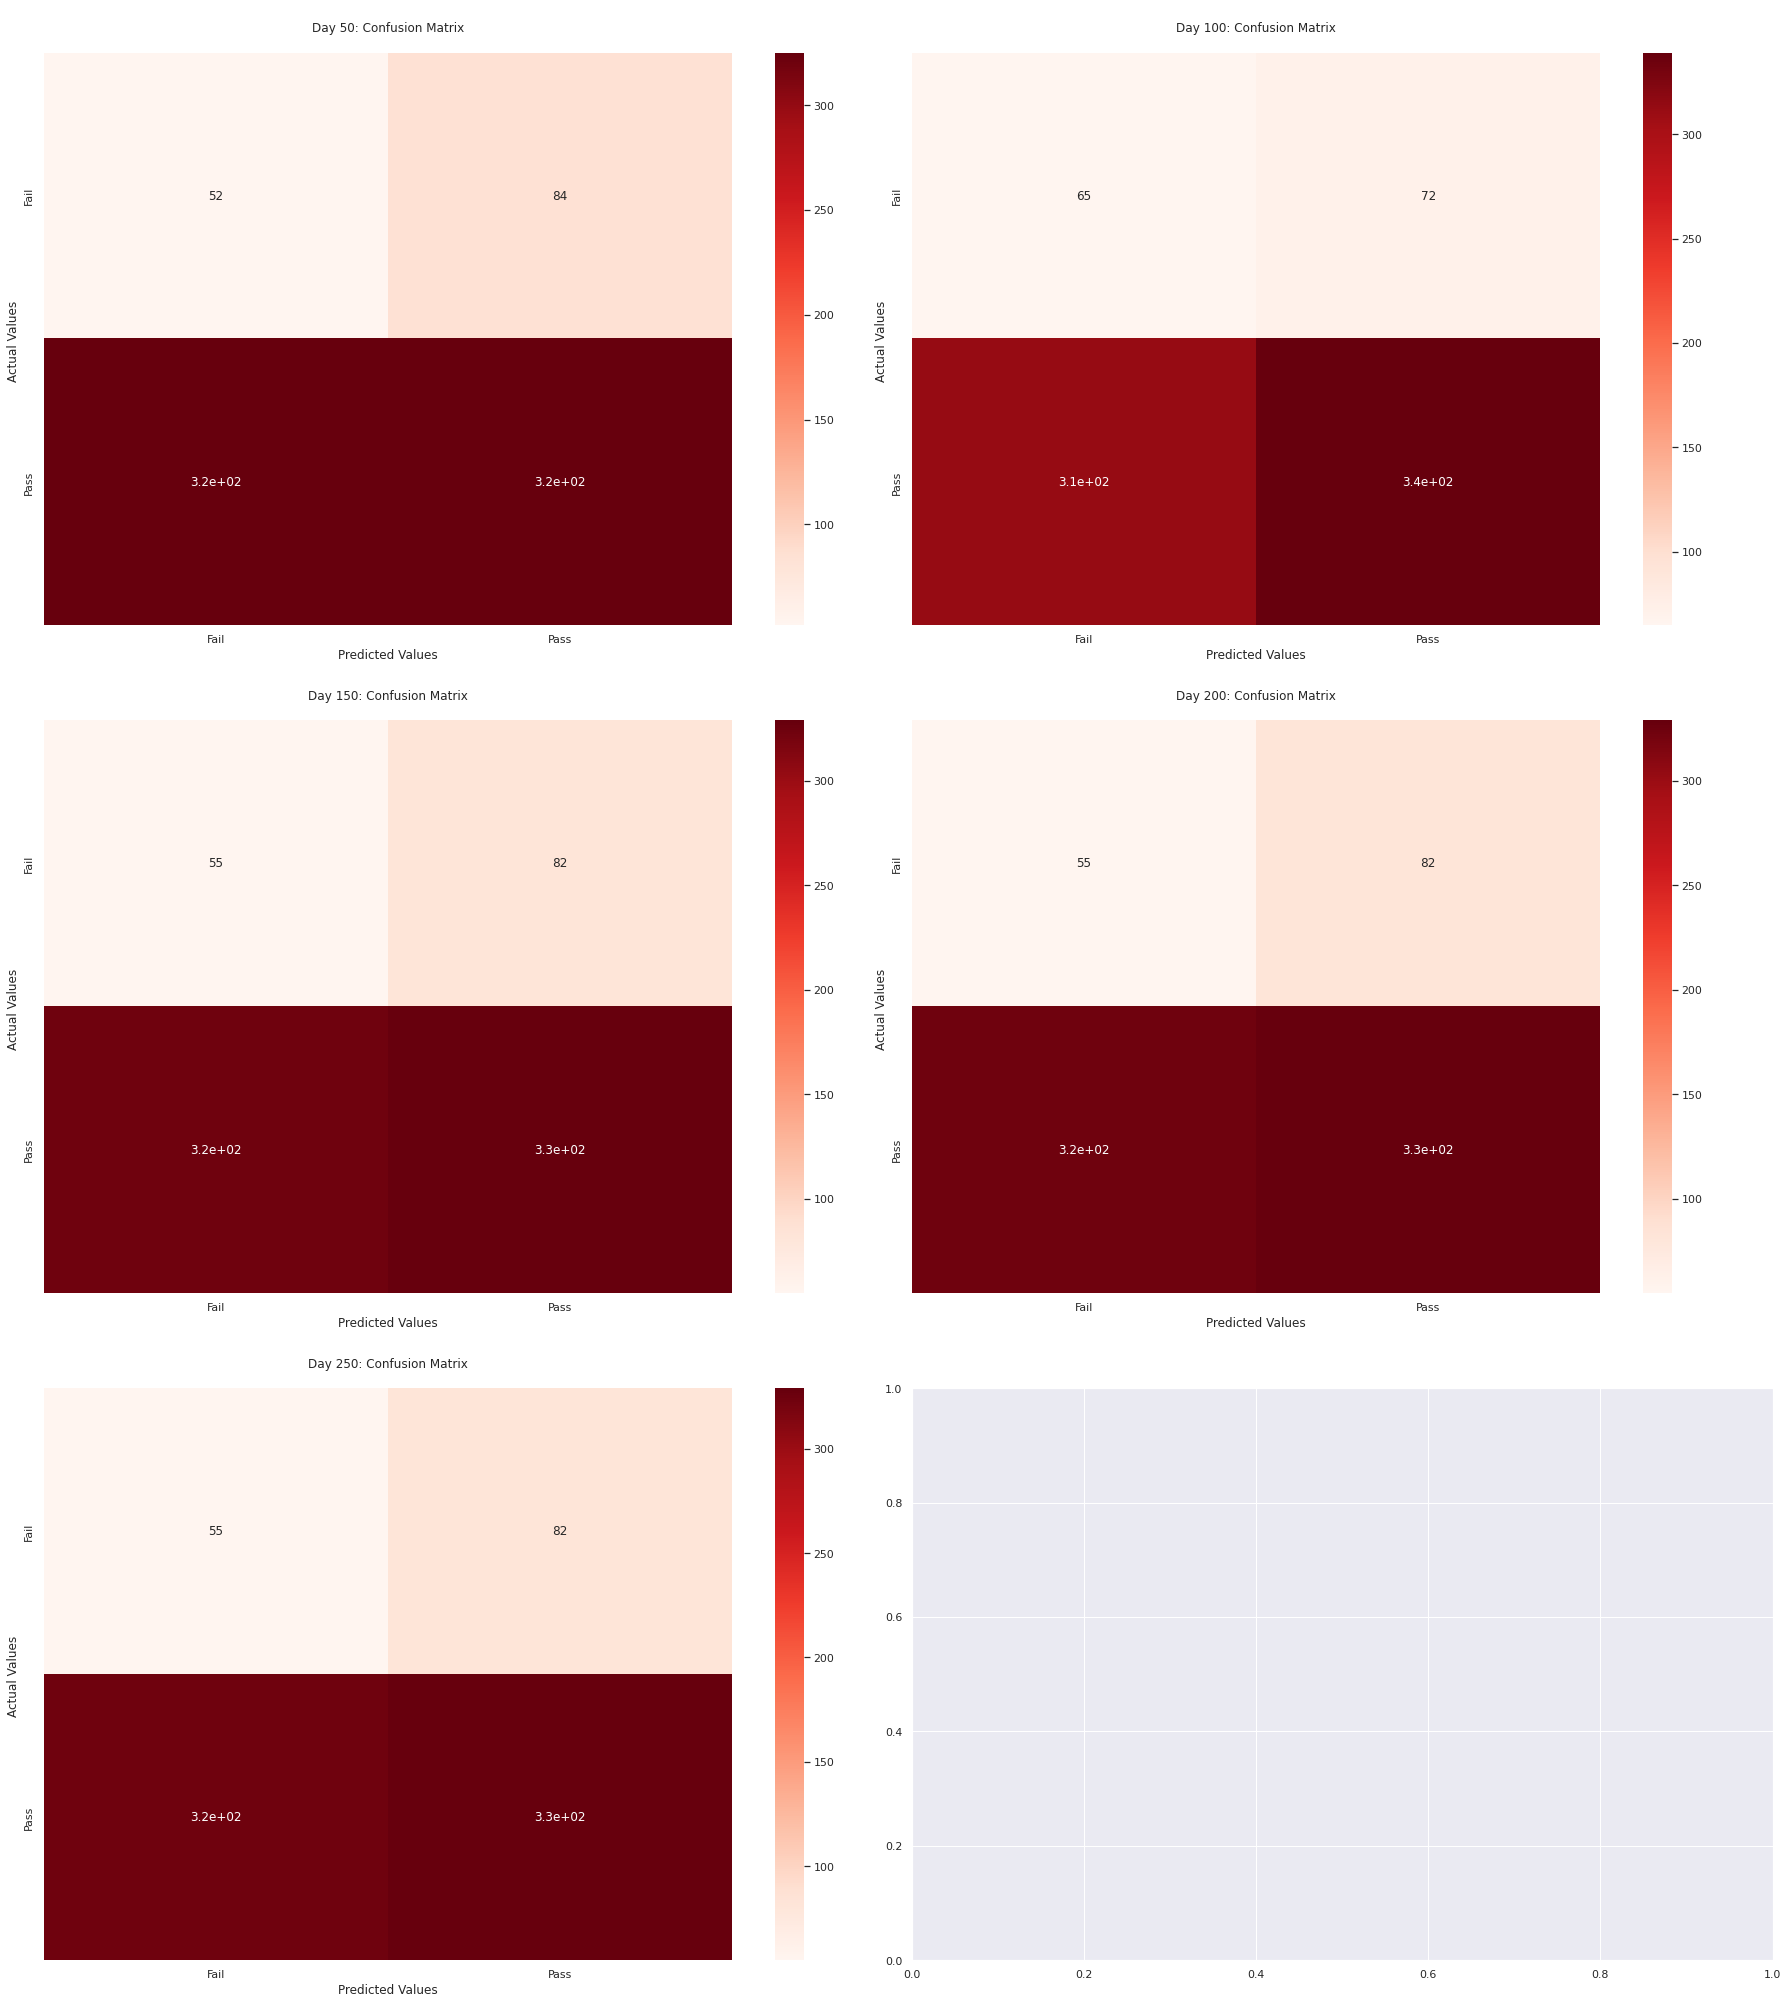

In [83]:
plot_confusion_matrix(performance_results_du)

##### NaiveBayes

In [84]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

performance_results_nb = []
performance_features_nb = []

performance_predict_proba_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])

  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_nb.append([acc, f1, prec, recall, conf])
  performance_features_nb.append([tuned_model, X_test[i], Y_test[i]])

  performance_predict_proba_nb.append(predictions_proba)

  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.165
Best parameters set:
Accuracy: 0.44331210191082804, F1 Score: 0.555442522889115, Precision: 0.8173652694610778, Recall: 0.4206471494607088


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.712
Best parameters set:
Accuracy: 0.8542458808618505, F1 Score: 0.9173256649892164, Precision: 0.8633288227334236, Recall: 0.9785276073619632


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.815
Best parameters set:
Accuracy: 0.8886075949367088, F1 Score: 0.9348148148148149, Precision: 0.9053084648493543, Recall: 0.9663093415007658


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.835
Be

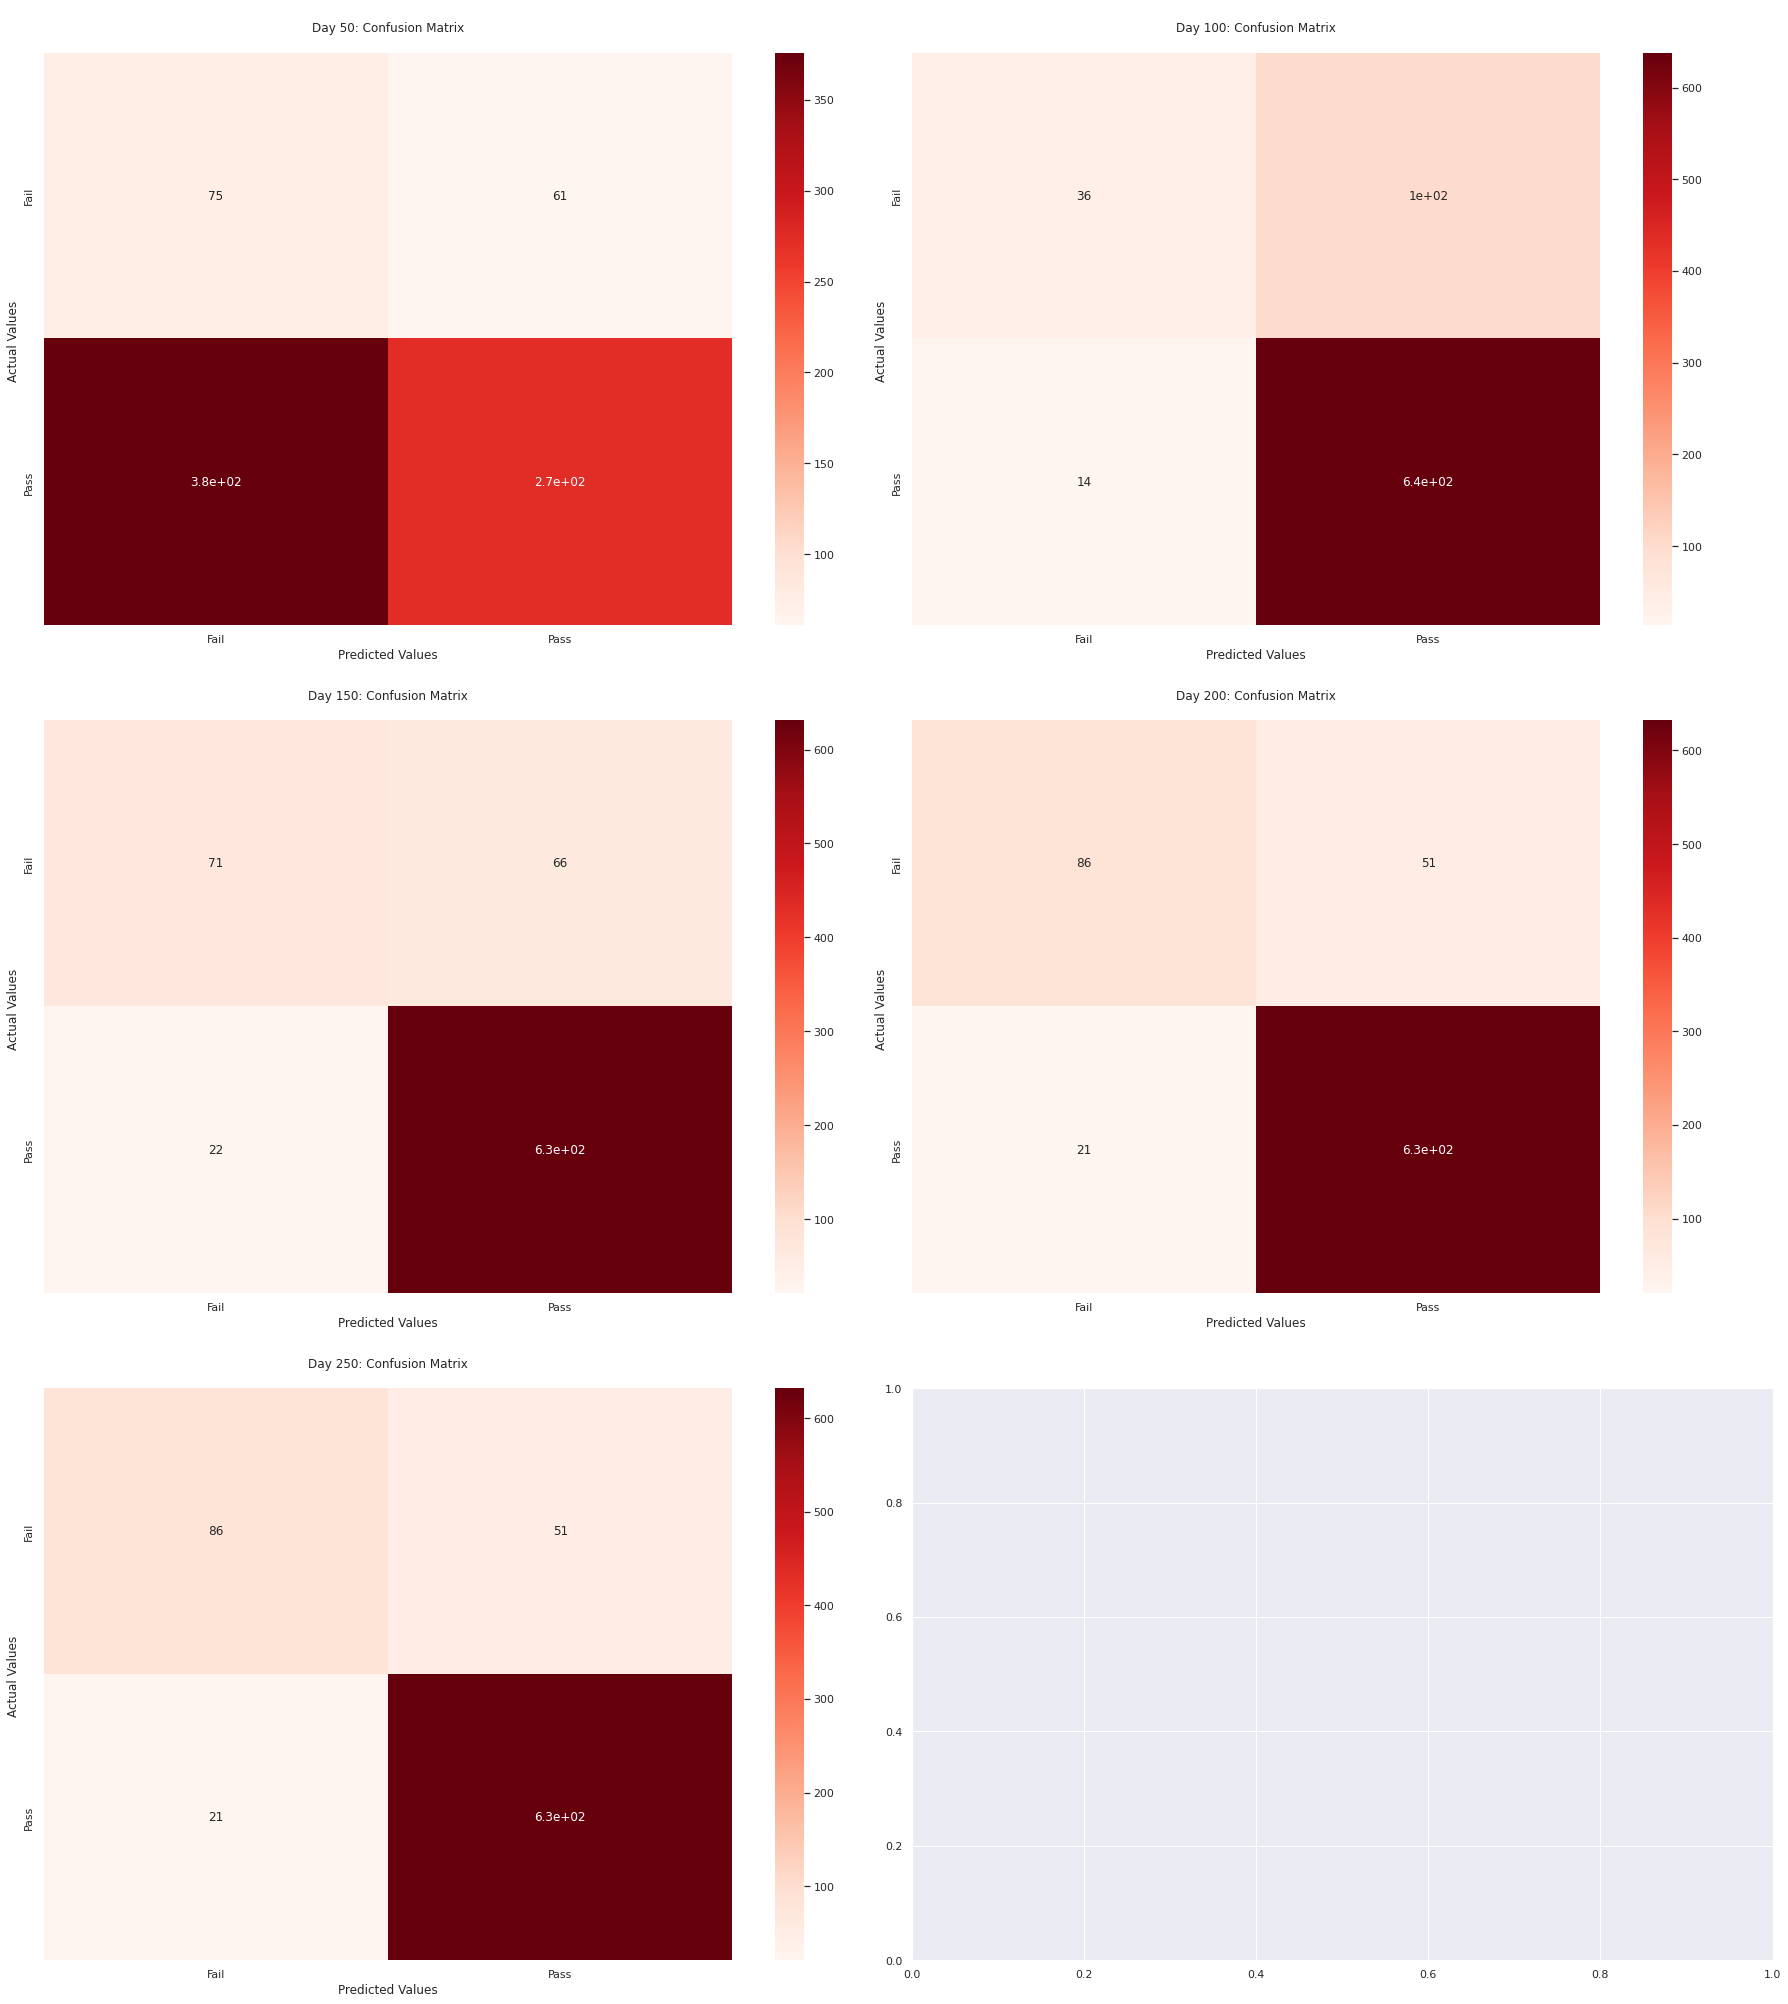

In [85]:
plot_confusion_matrix(performance_results_nb)

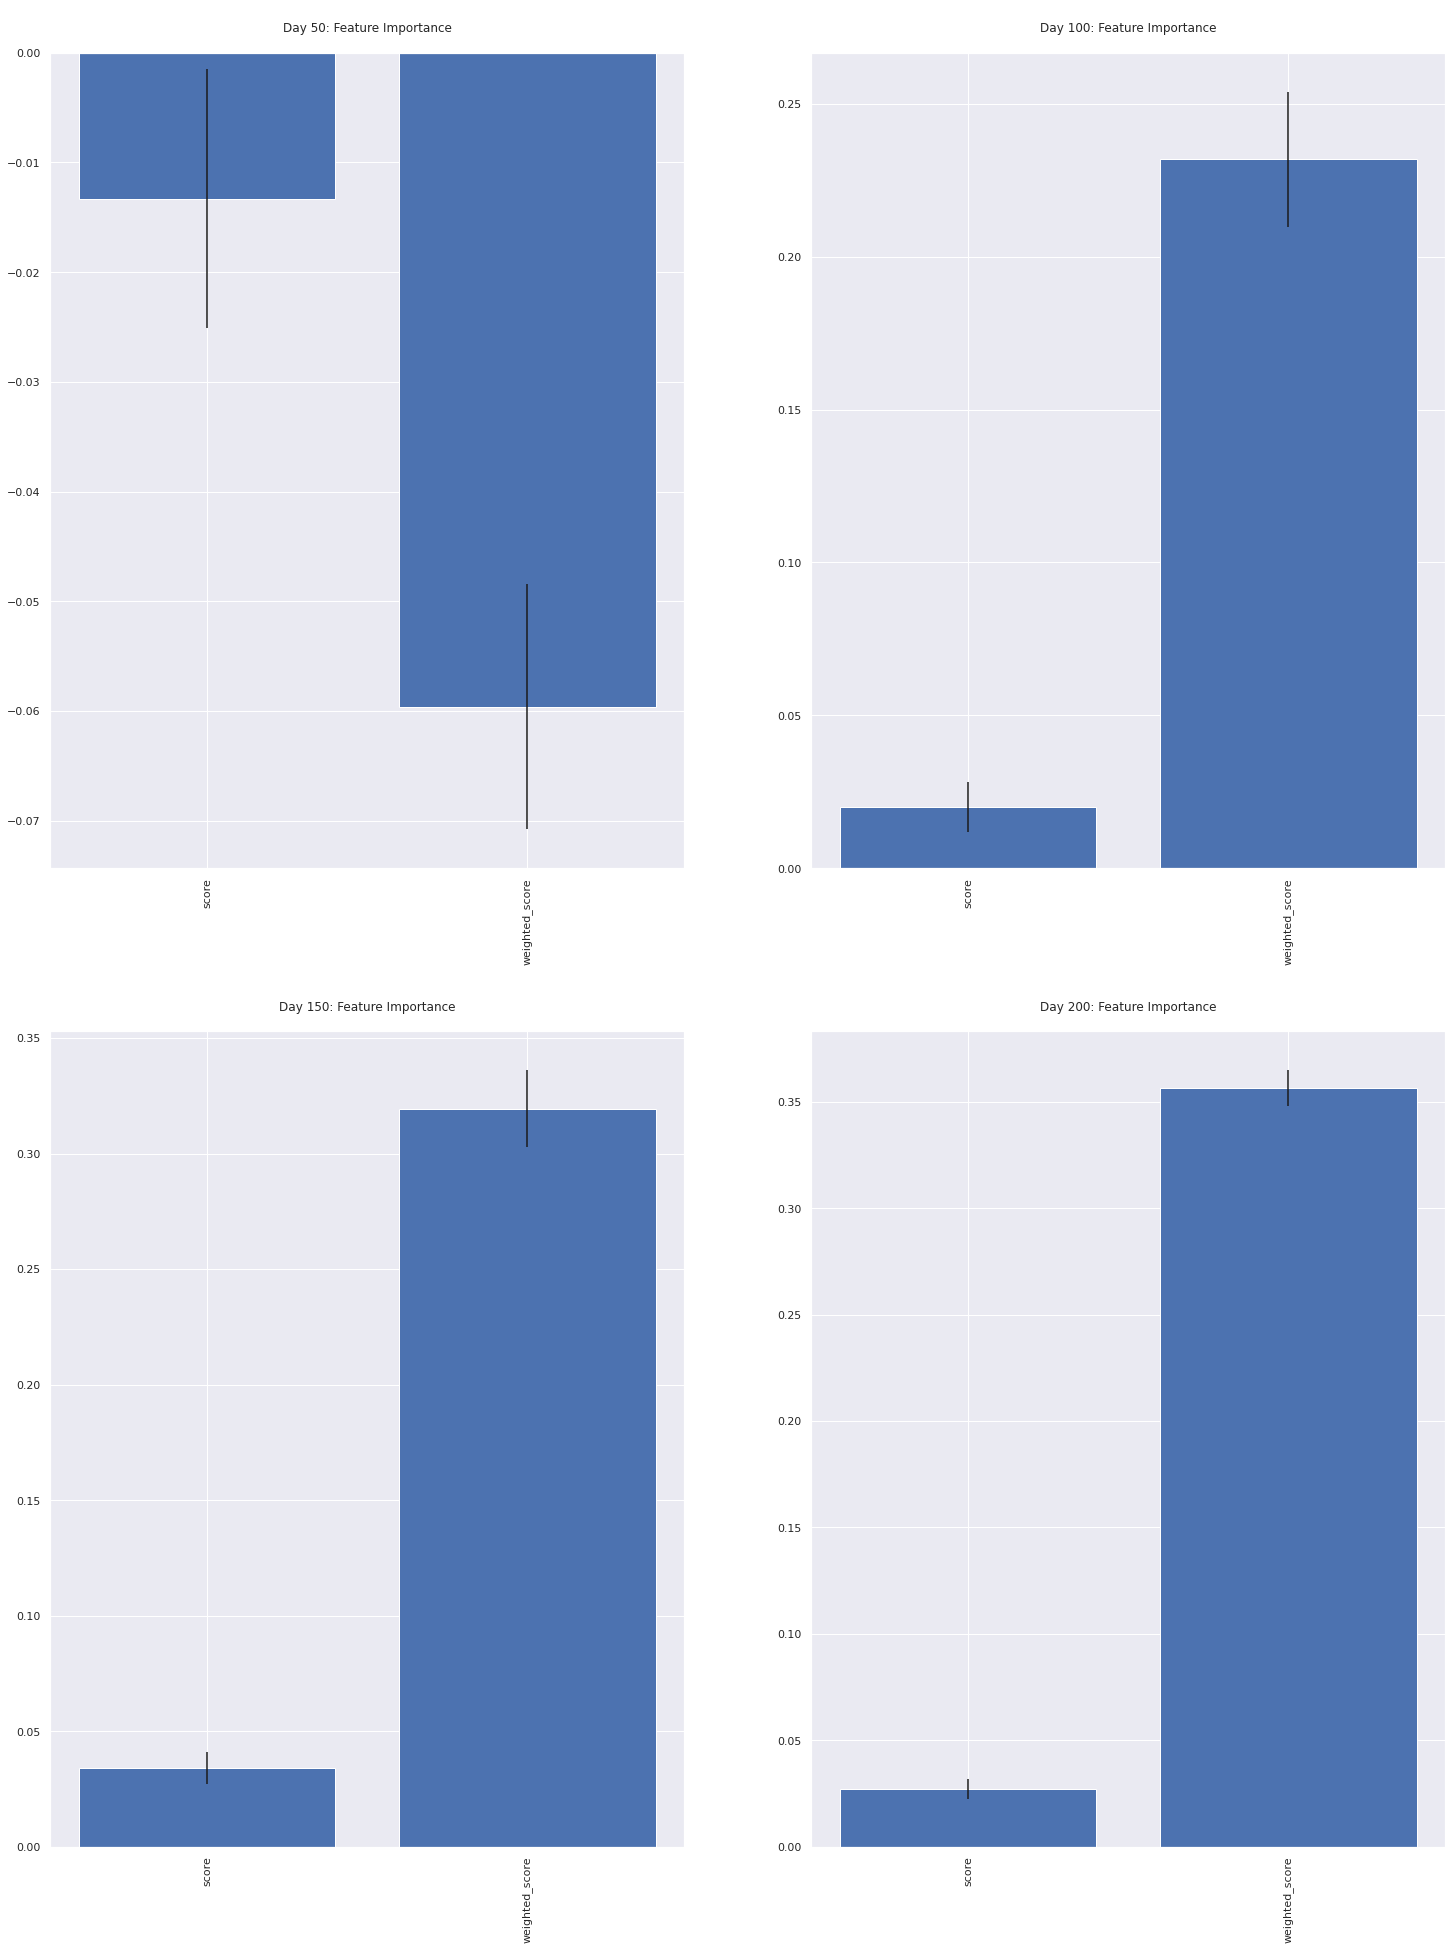

In [86]:
plot_feature_importance(performance_features_nb)

##### LogisticRegression

In [87]:
from sklearn.linear_model import LogisticRegression

performance_results_lr = []
performance_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lr.append([acc, f1, prec, recall, conf])
  performance_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.653
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8394904458598726, F1 Score: 0.9096126255380201, Precision: 0.851006711409396, Recall: 0.9768875192604006


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.745
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8542458808618505, F1 Score: 0.9166062364031908, Precision: 0.8693259972489684, Recall: 0.9693251533742331


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.821
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8987341772151899, F1 Score: 0.9402985074626866, Precision: 0.9170305676855895, Recall: 0.9647779479

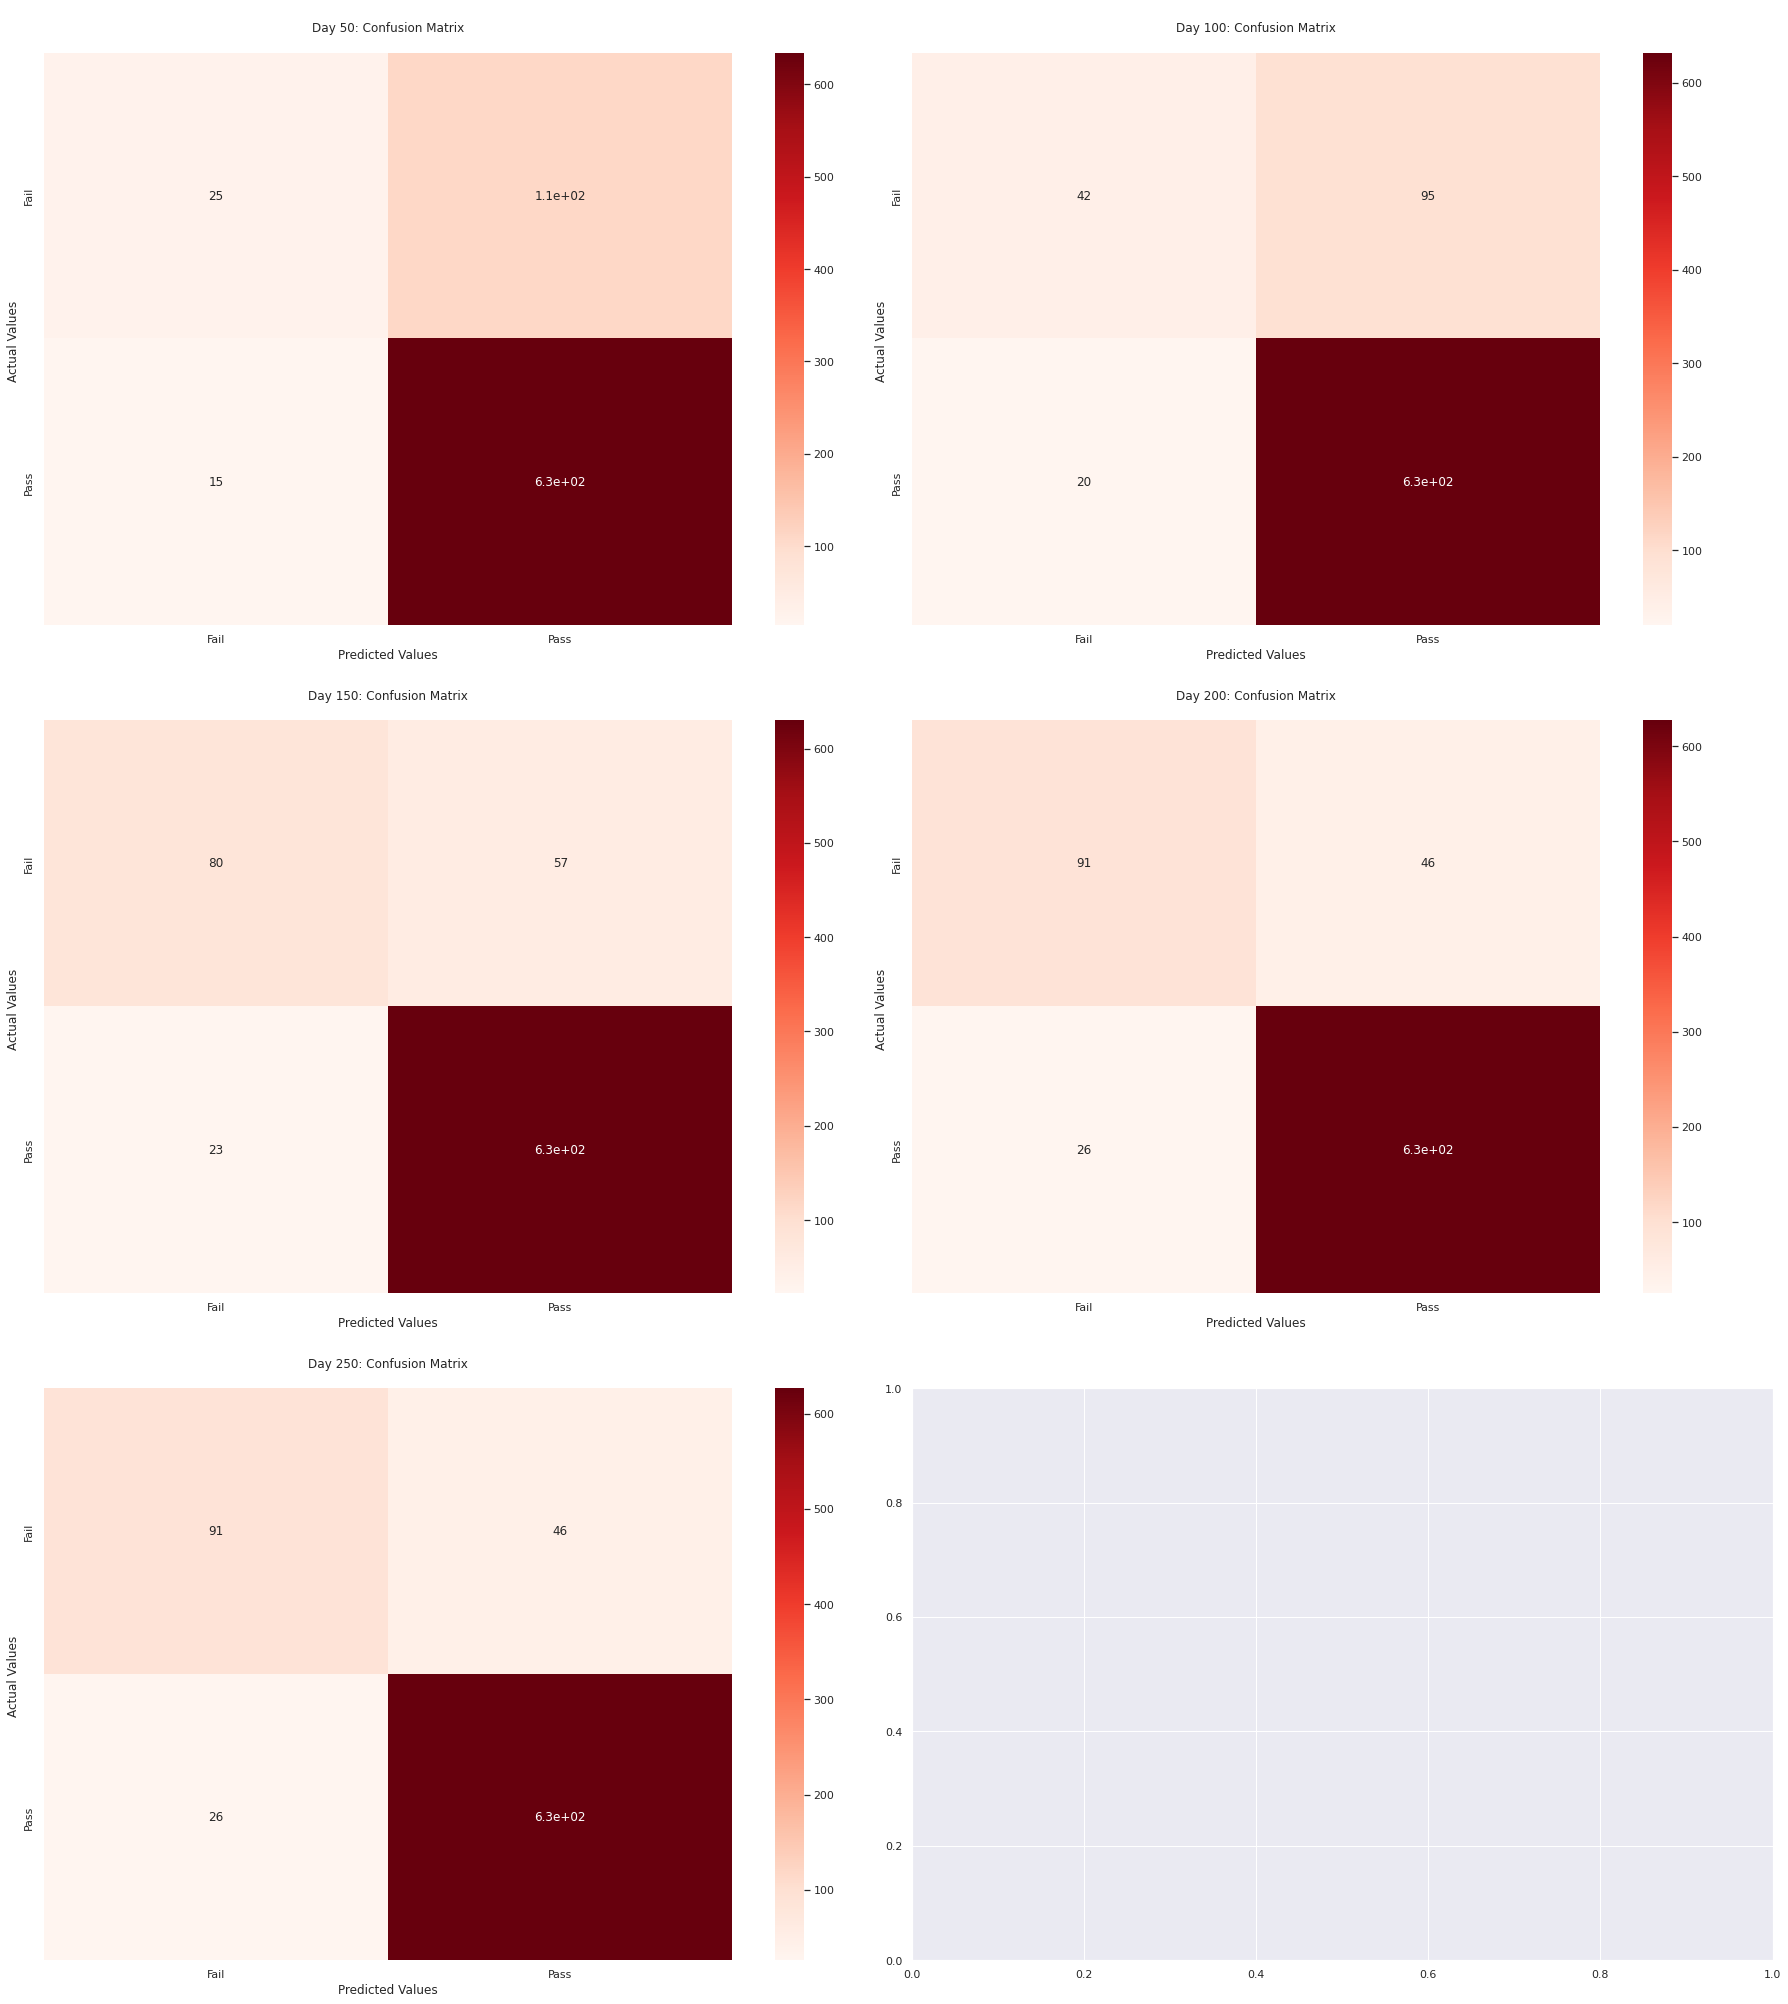

In [88]:
plot_confusion_matrix(performance_results_lr)

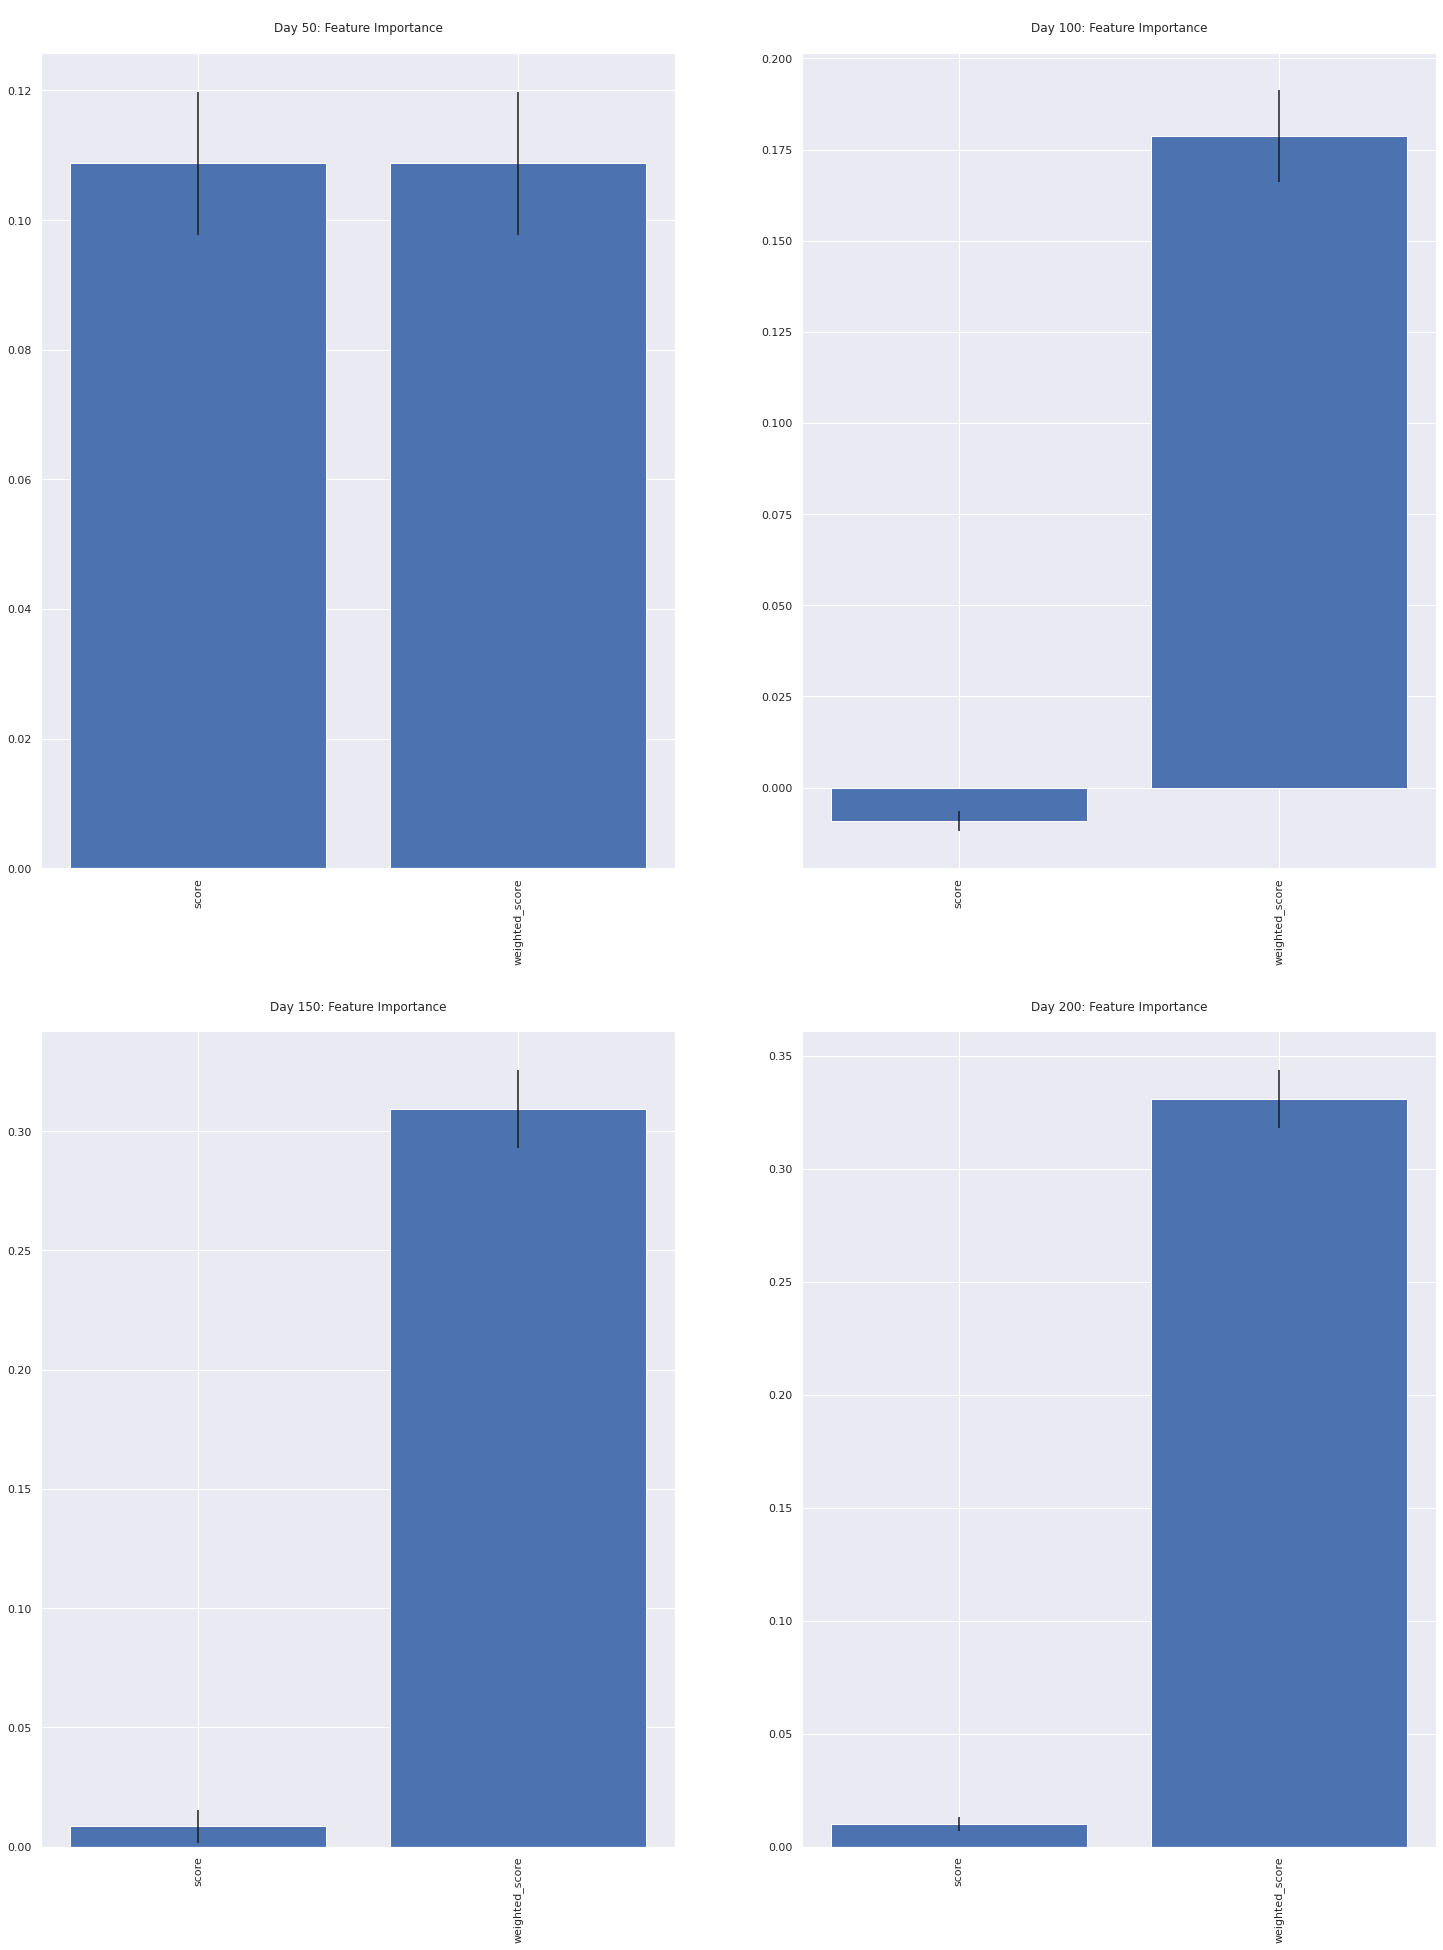

In [89]:
plot_feature_importance(performance_features_lr)

##### WeightedLogisticRegression

In [90]:
performance_results_lrw = []
performance_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
  
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lrw.append([acc, f1, prec, recall, conf])
  performance_features_lrw.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.665
Best parameters set:
Accuracy: 0.7656050955414013, F1 Score: 0.8544303797468354, Precision: 0.8780487804878049, Recall: 0.8320493066255779


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.756
Best parameters set:
Accuracy: 0.8250950570342205, F1 Score: 0.8938461538461538, Precision: 0.8966049382716049, Recall: 0.8911042944785276


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.818
Best parameters set:
Accuracy: 0.8620253164556962, F1 Score: 0.9151750972762644, Precision: 0.930379746835443, Recall: 0.900459418070444


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.849
Best

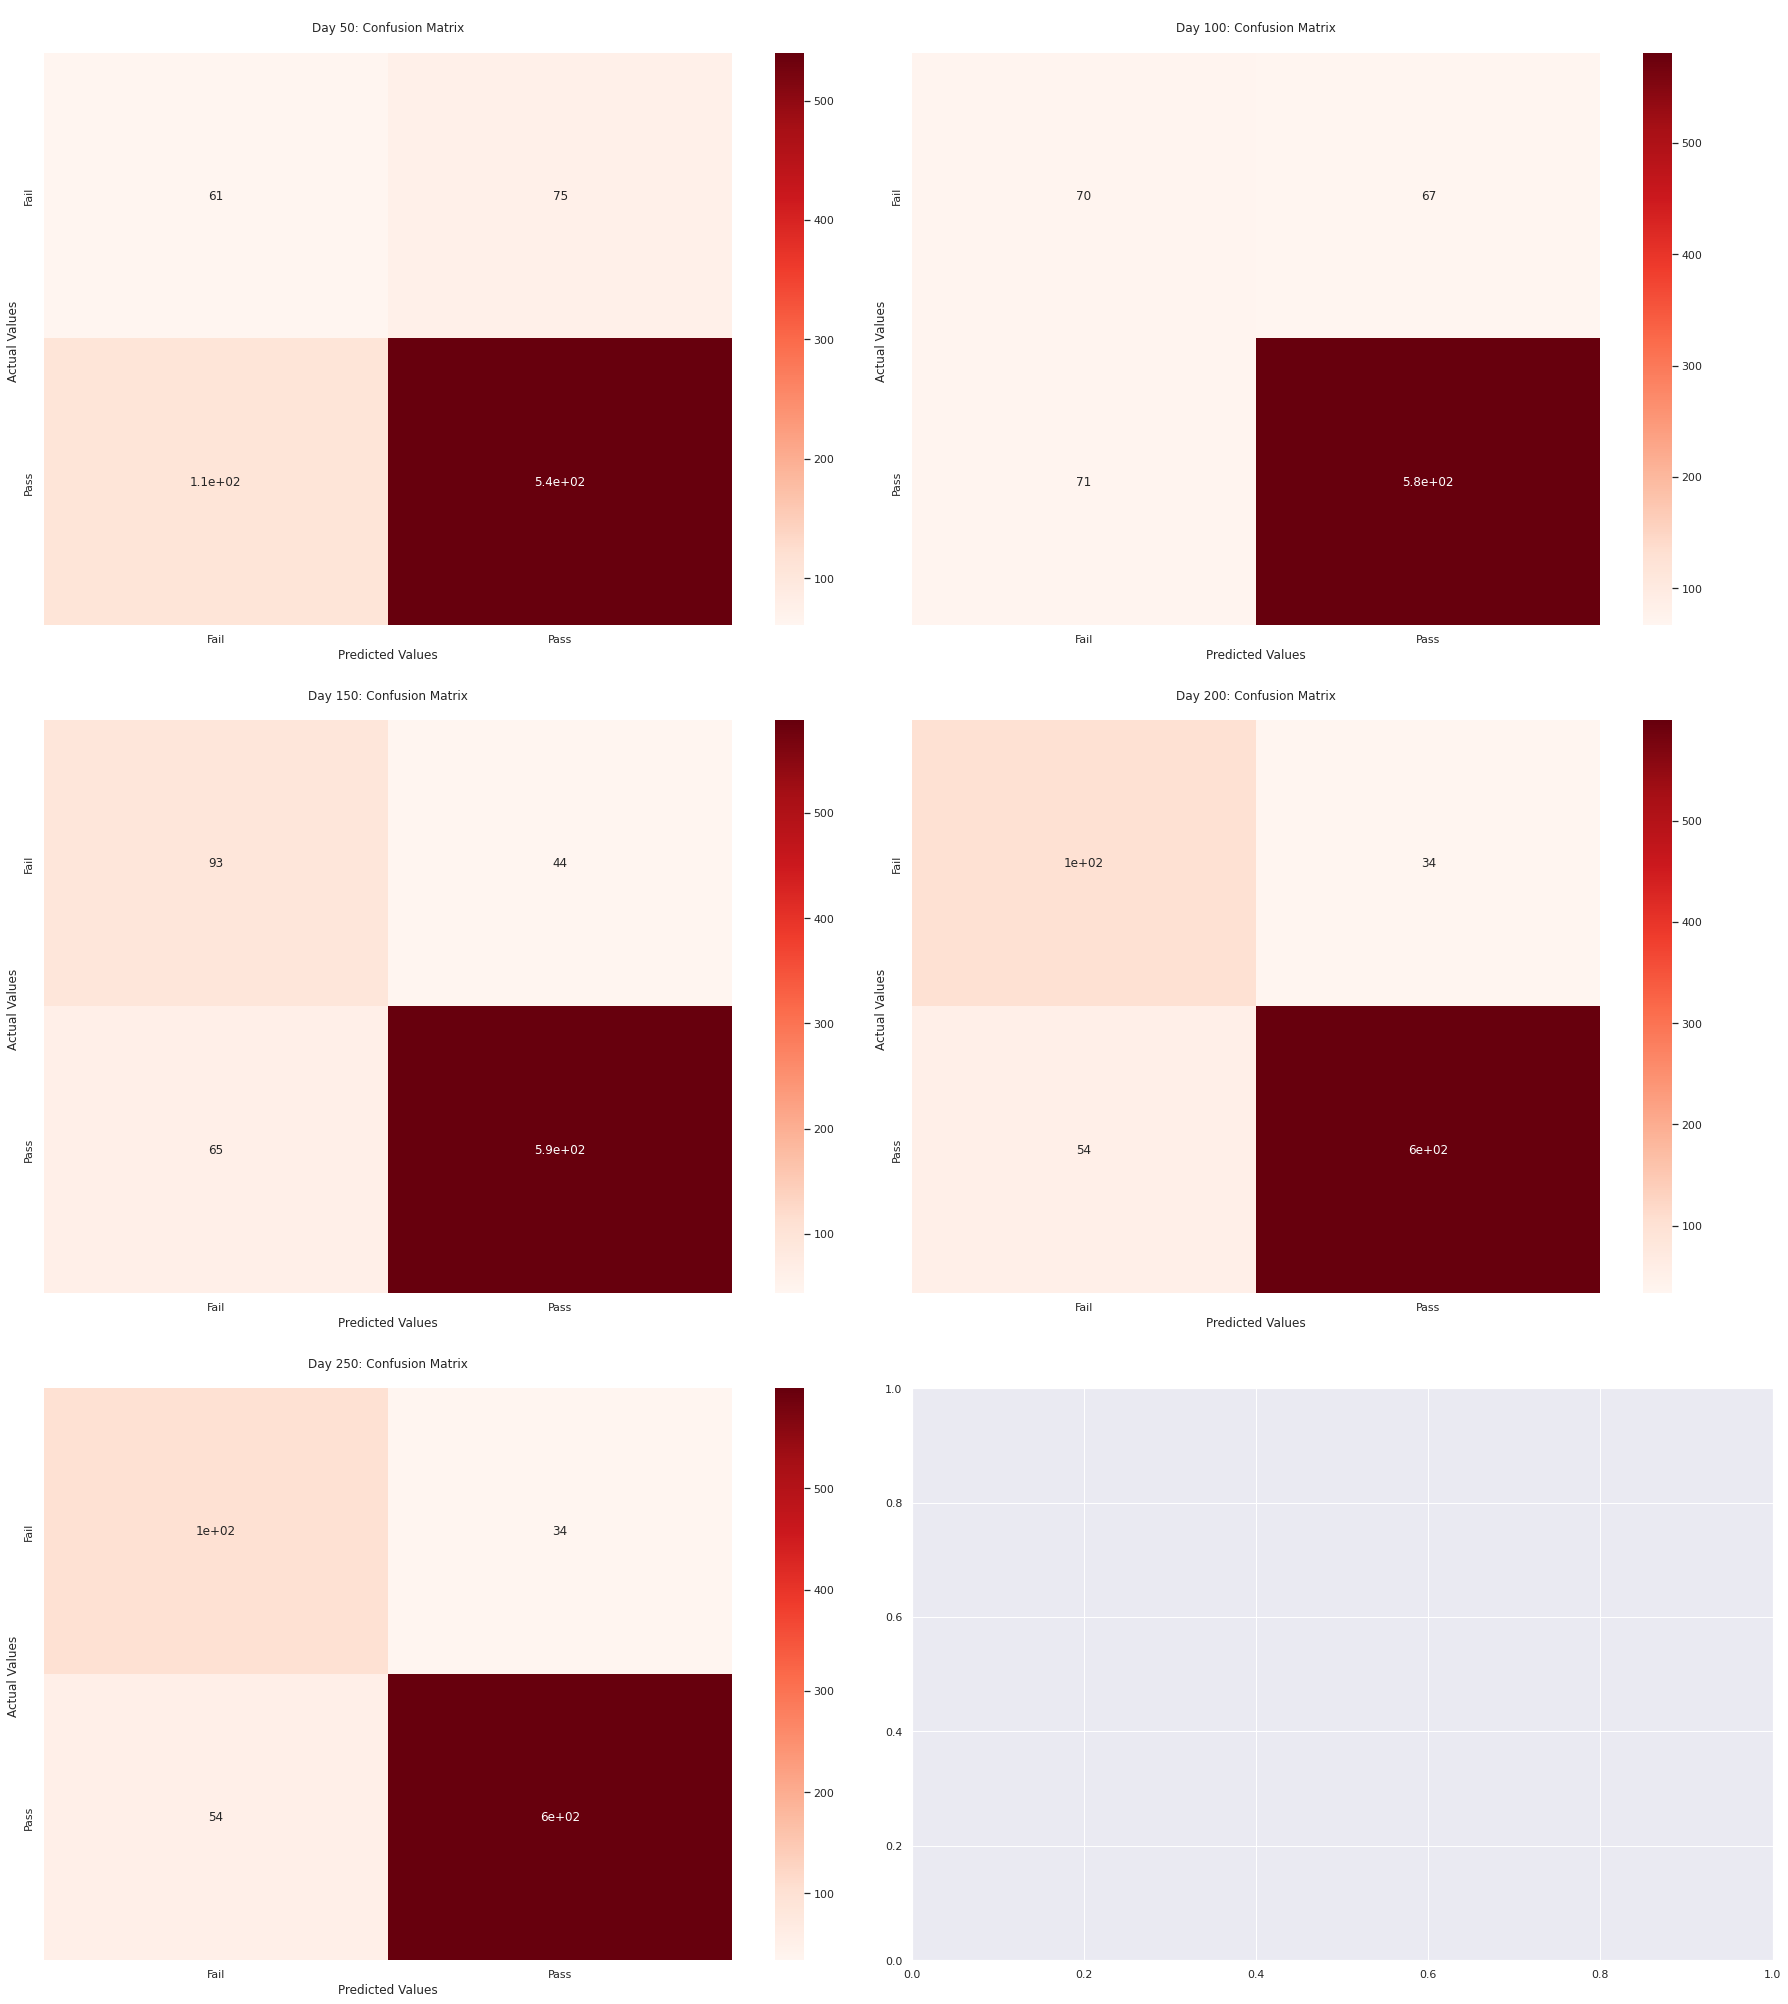

In [91]:
plot_confusion_matrix(performance_results_lrw)

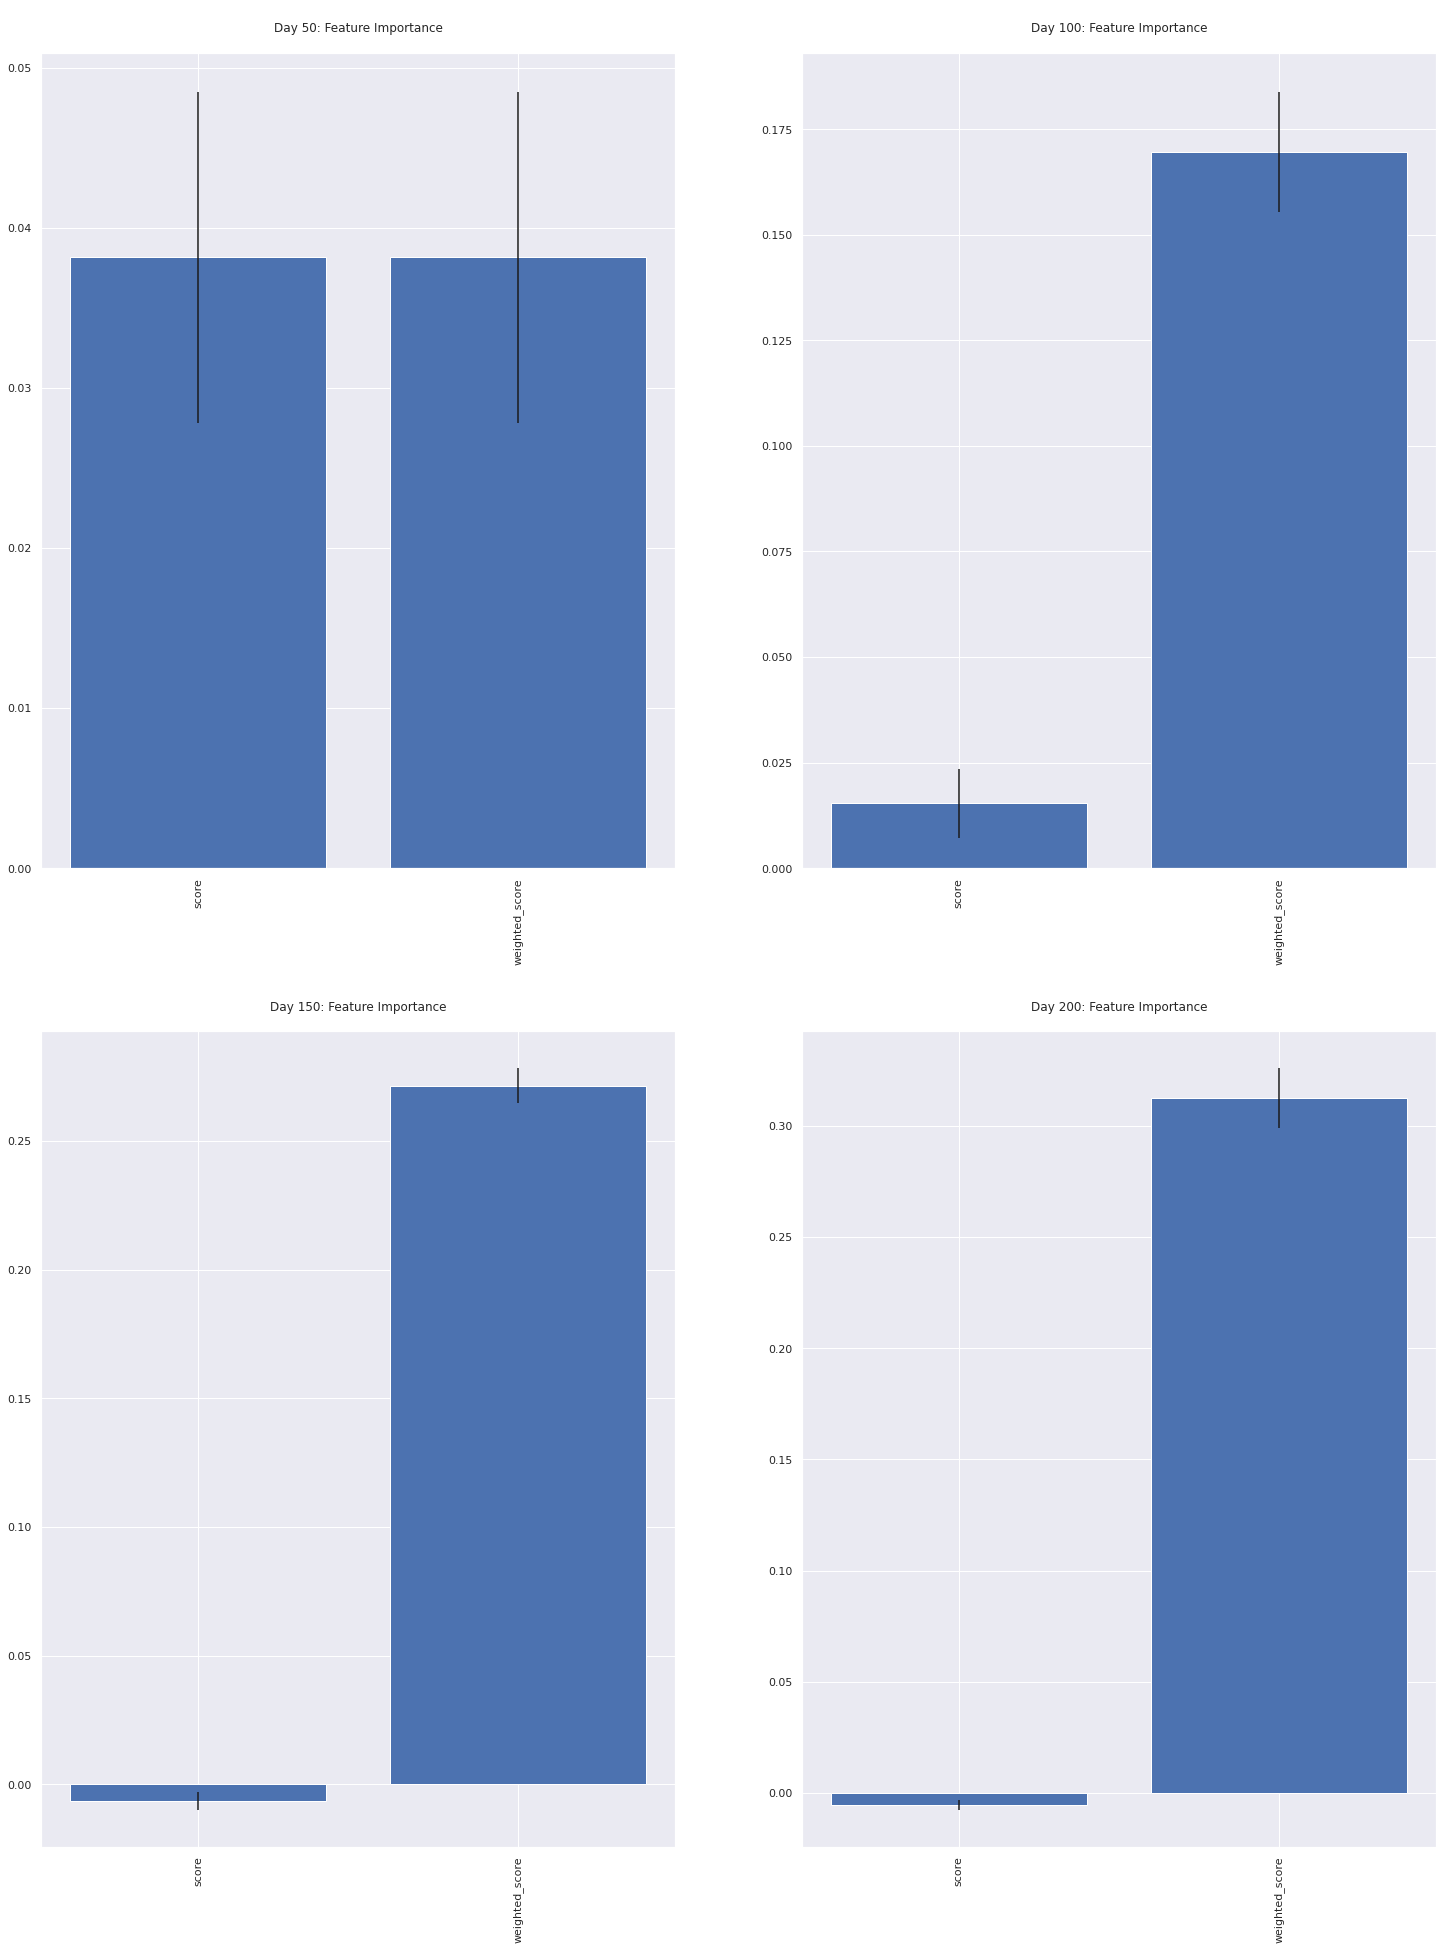

In [92]:
plot_feature_importance(performance_features_lrw)

##### RandomForest

In [93]:
from sklearn.ensemble import RandomForestClassifier

performance_results_rf = []
performance_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_rf.append([acc, f1, prec, recall, conf])
  performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.640
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.8267515923566879, F1 Score: 0.9013062409288823, Precision: 0.8518518518518519, Recall: 0.9568567026194145


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.713
Best parameters set:
	clf__n_estimators: 70
Accuracy: 0.8136882129277566, F1 Score: 0.8903803131991052, Precision: 0.8664731494920174, Recall: 0.9156441717791411


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.784
Best parameters set:
	clf__n_estimato

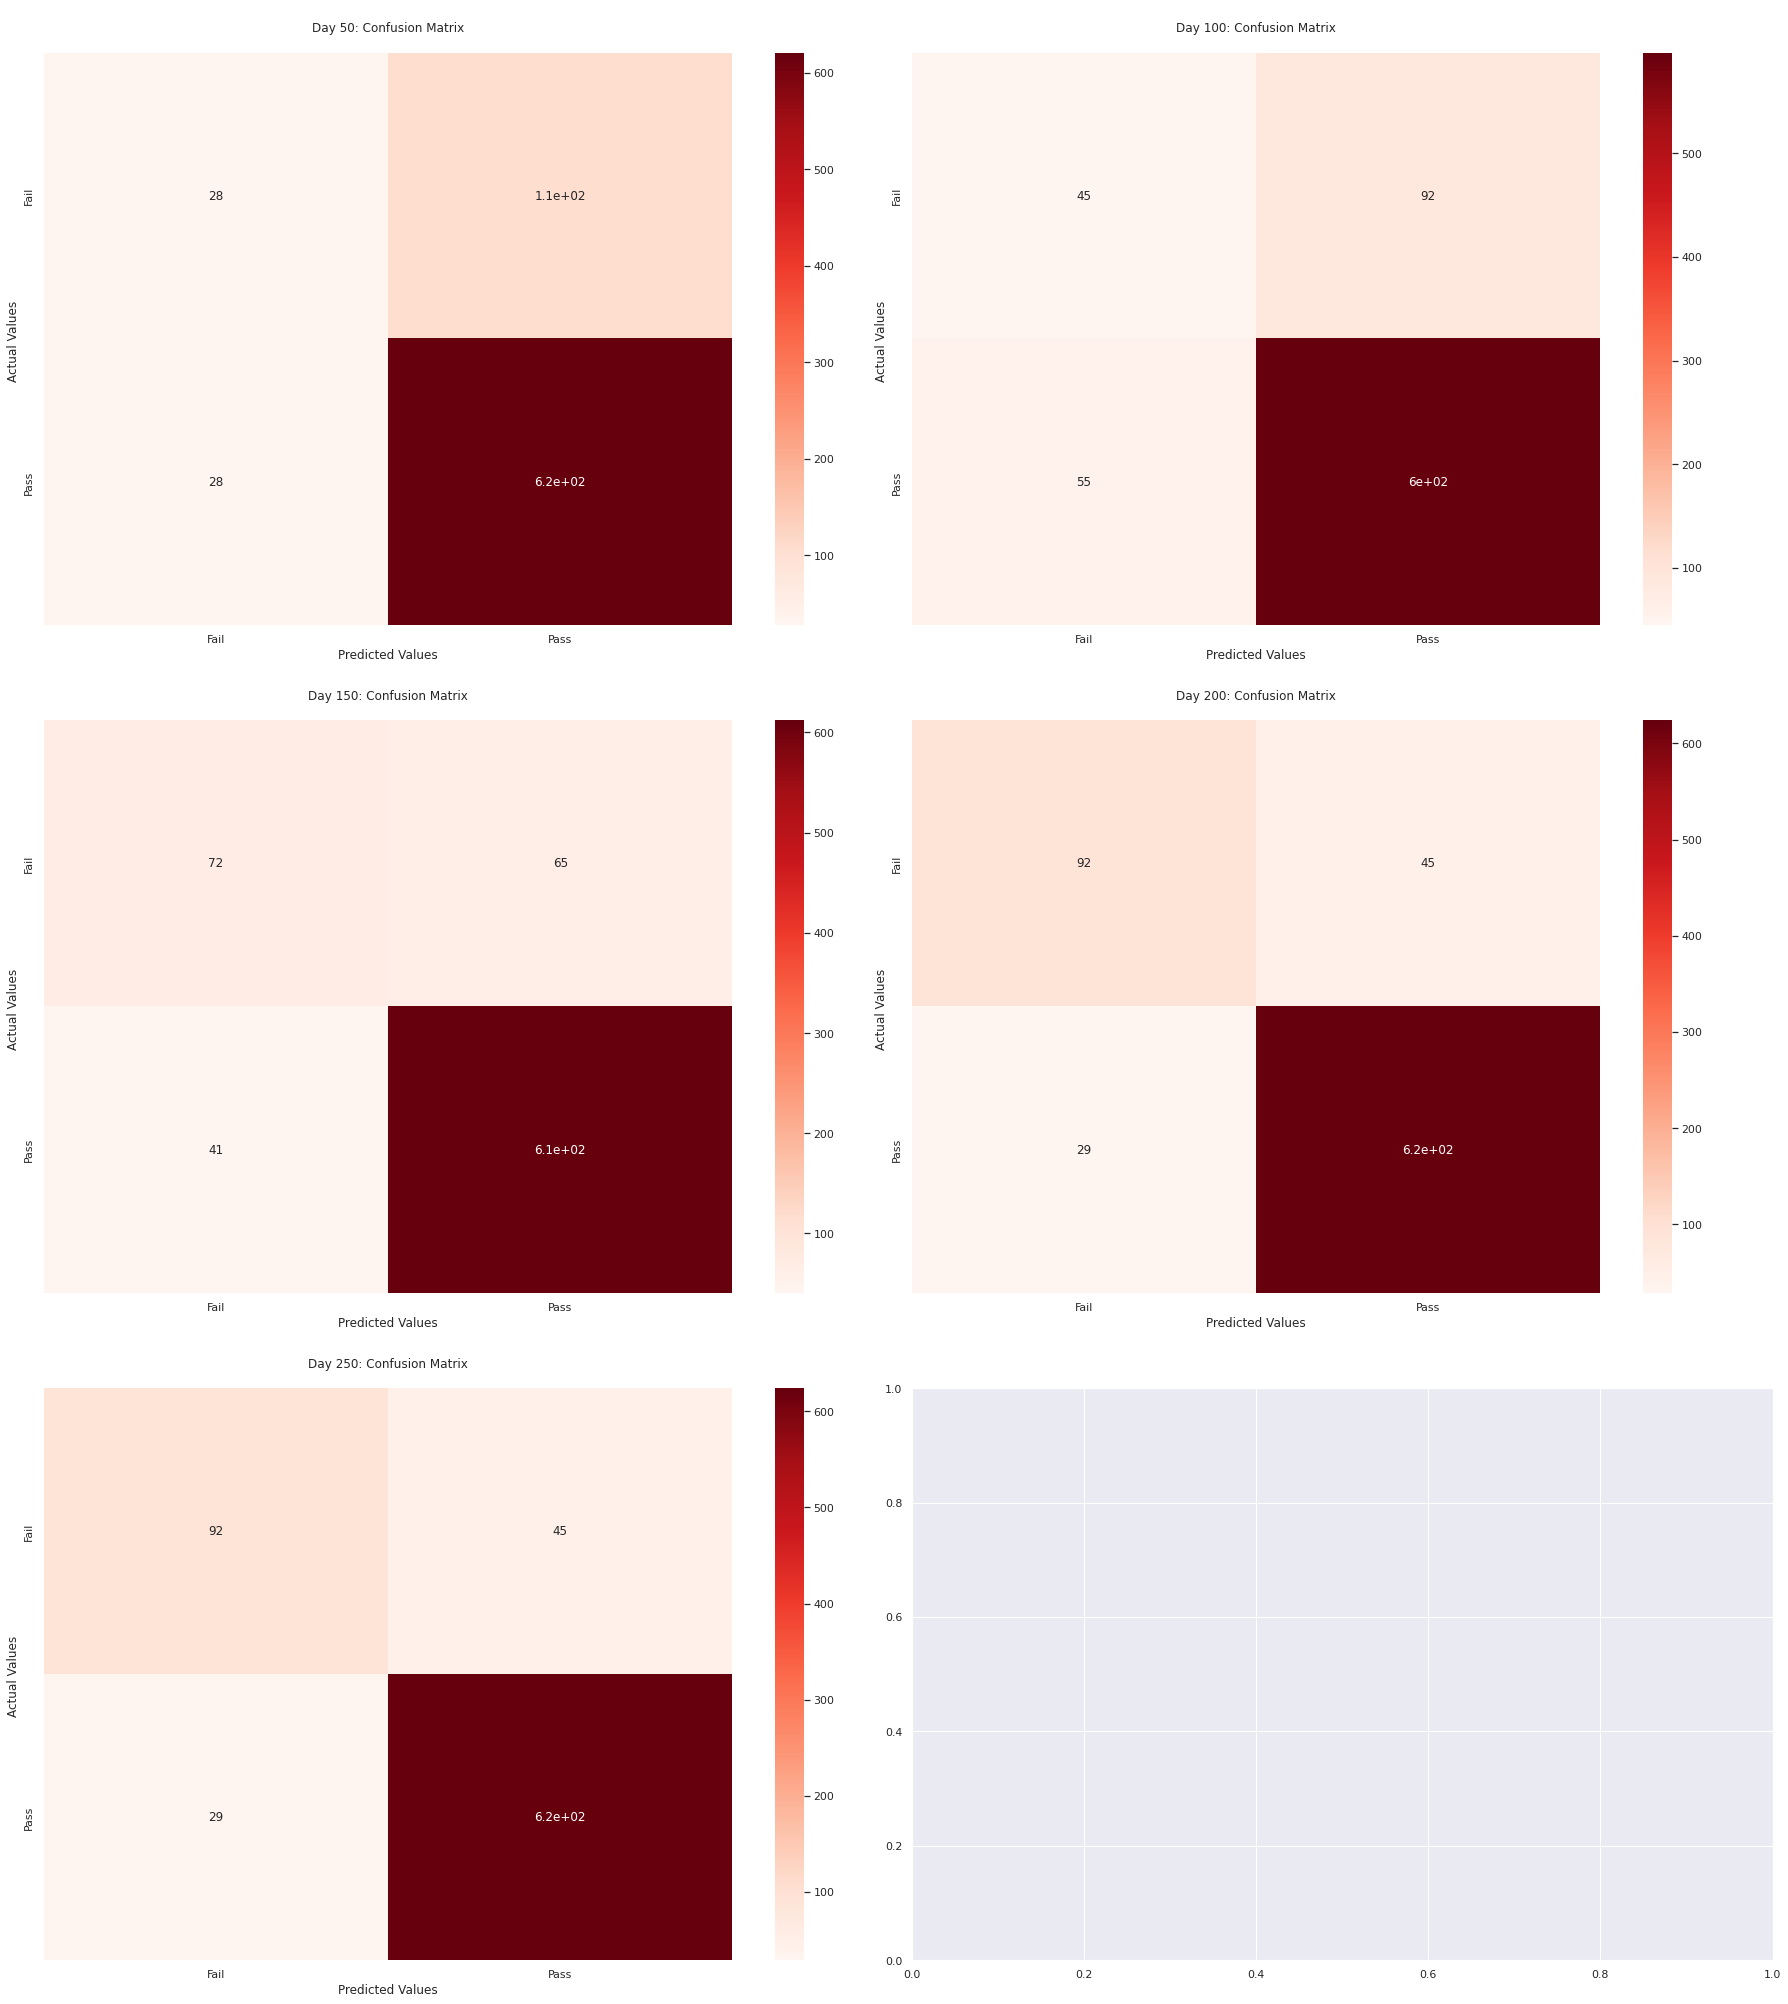

In [94]:
plot_confusion_matrix(performance_results_rf)

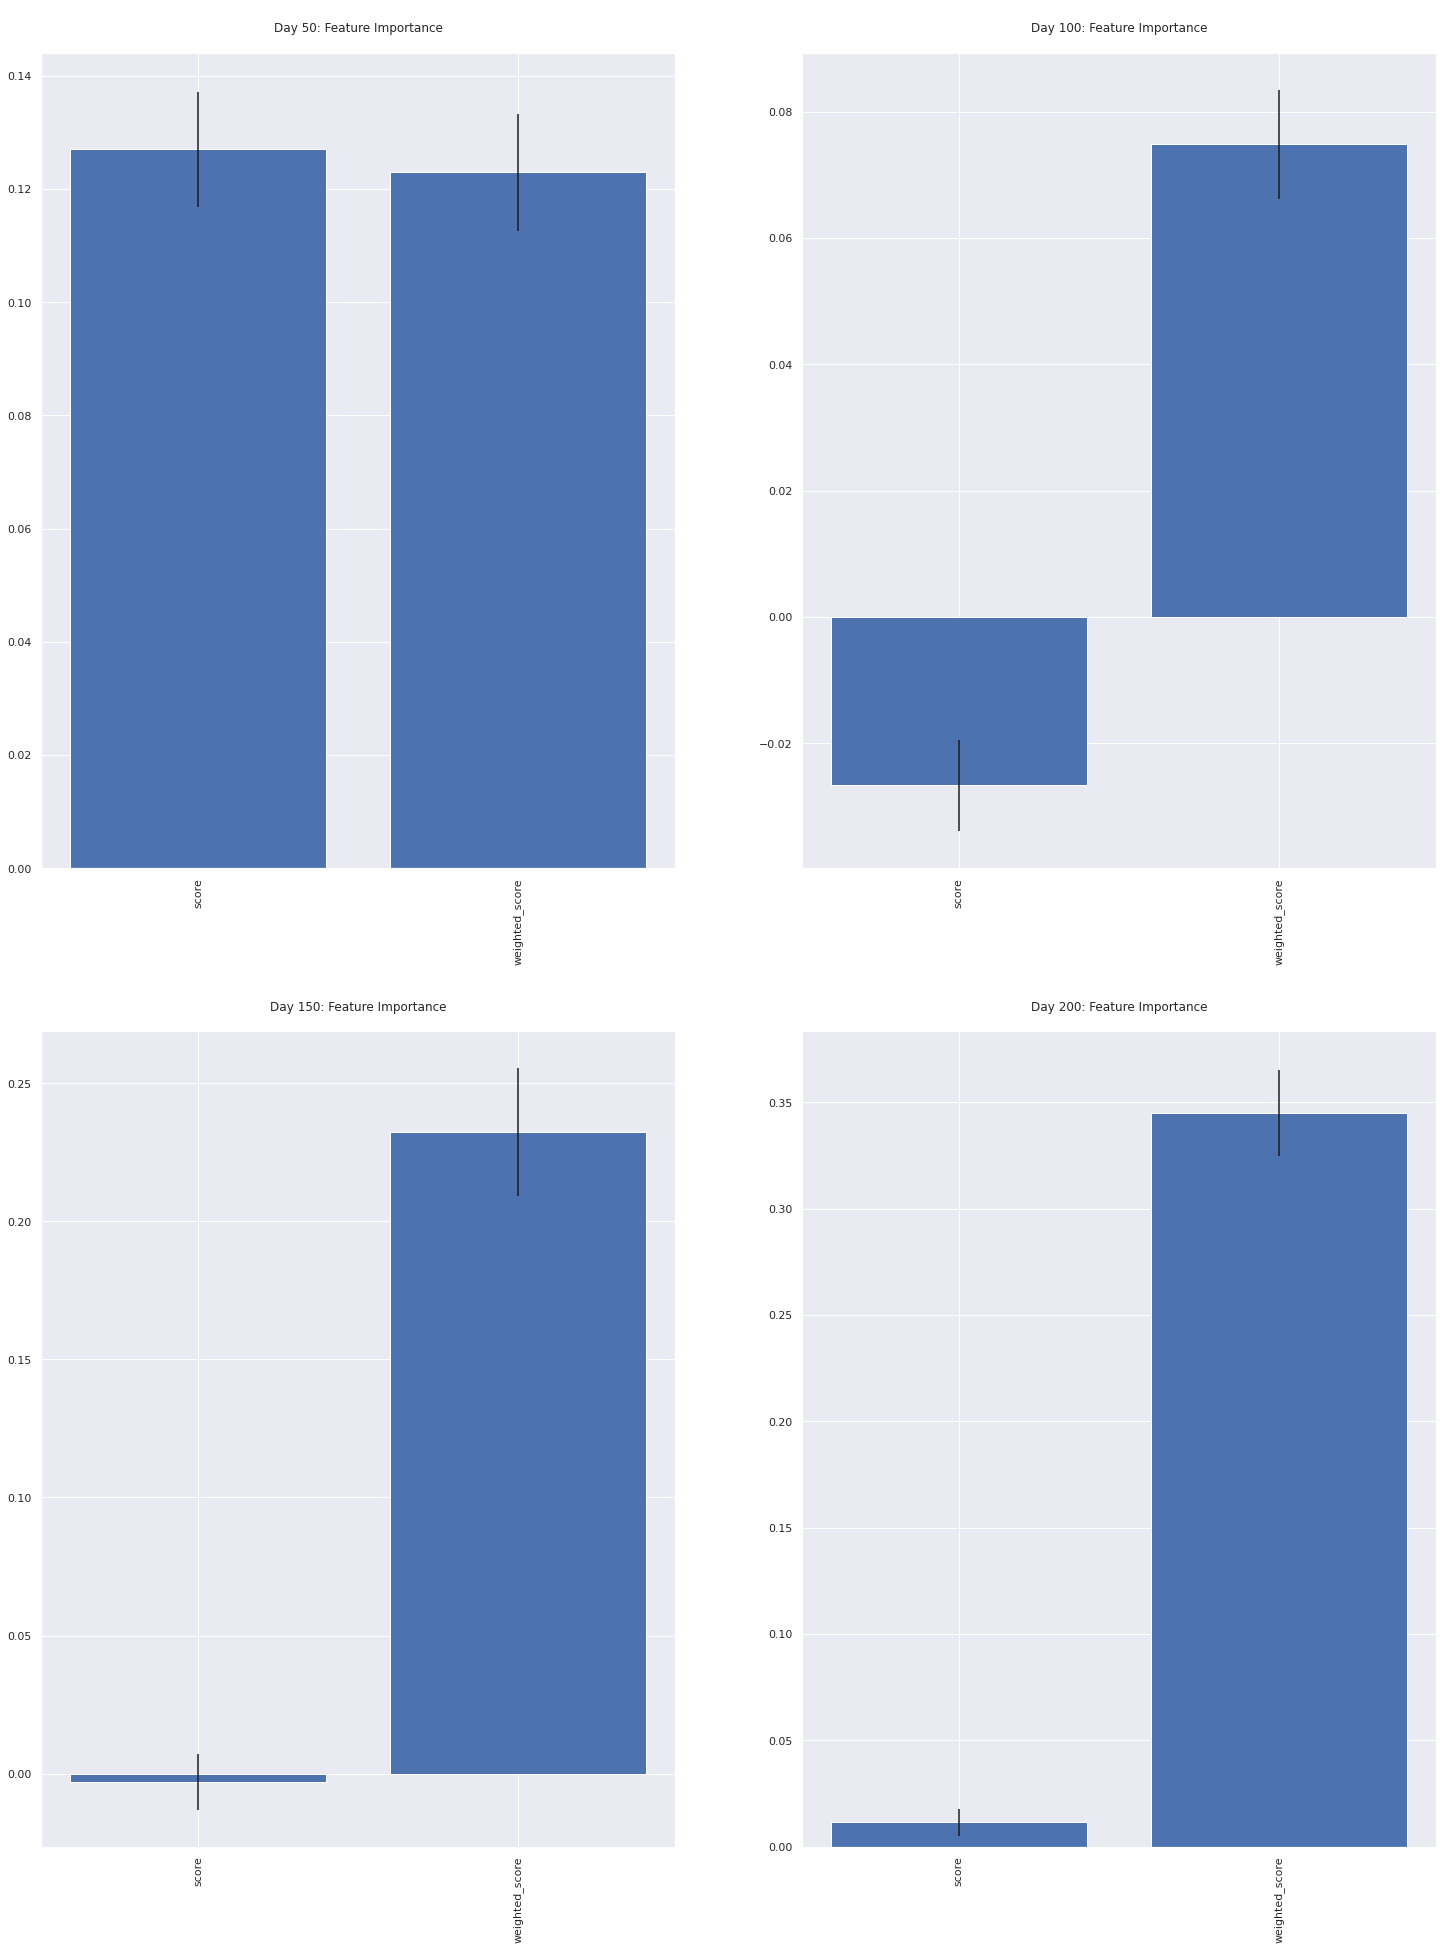

In [95]:
plot_feature_importance(performance_features_rf)

##### AdaBoost

In [96]:
from sklearn.ensemble import AdaBoostClassifier

performance_results_ab = []
performance_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_ab.append([acc, f1, prec, recall, conf])
  performance_features_ab.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.628
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.8433121019108281, F1 Score: 0.9117013639626705, Precision: 0.853494623655914, Recall: 0.9784283513097073


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.724
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8517110266159695, F1 Score: 0.9144111192392099, Precision: 0.8741258741258742, Recall: 0.9585889570552147


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.806
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.8810126582278481, F1

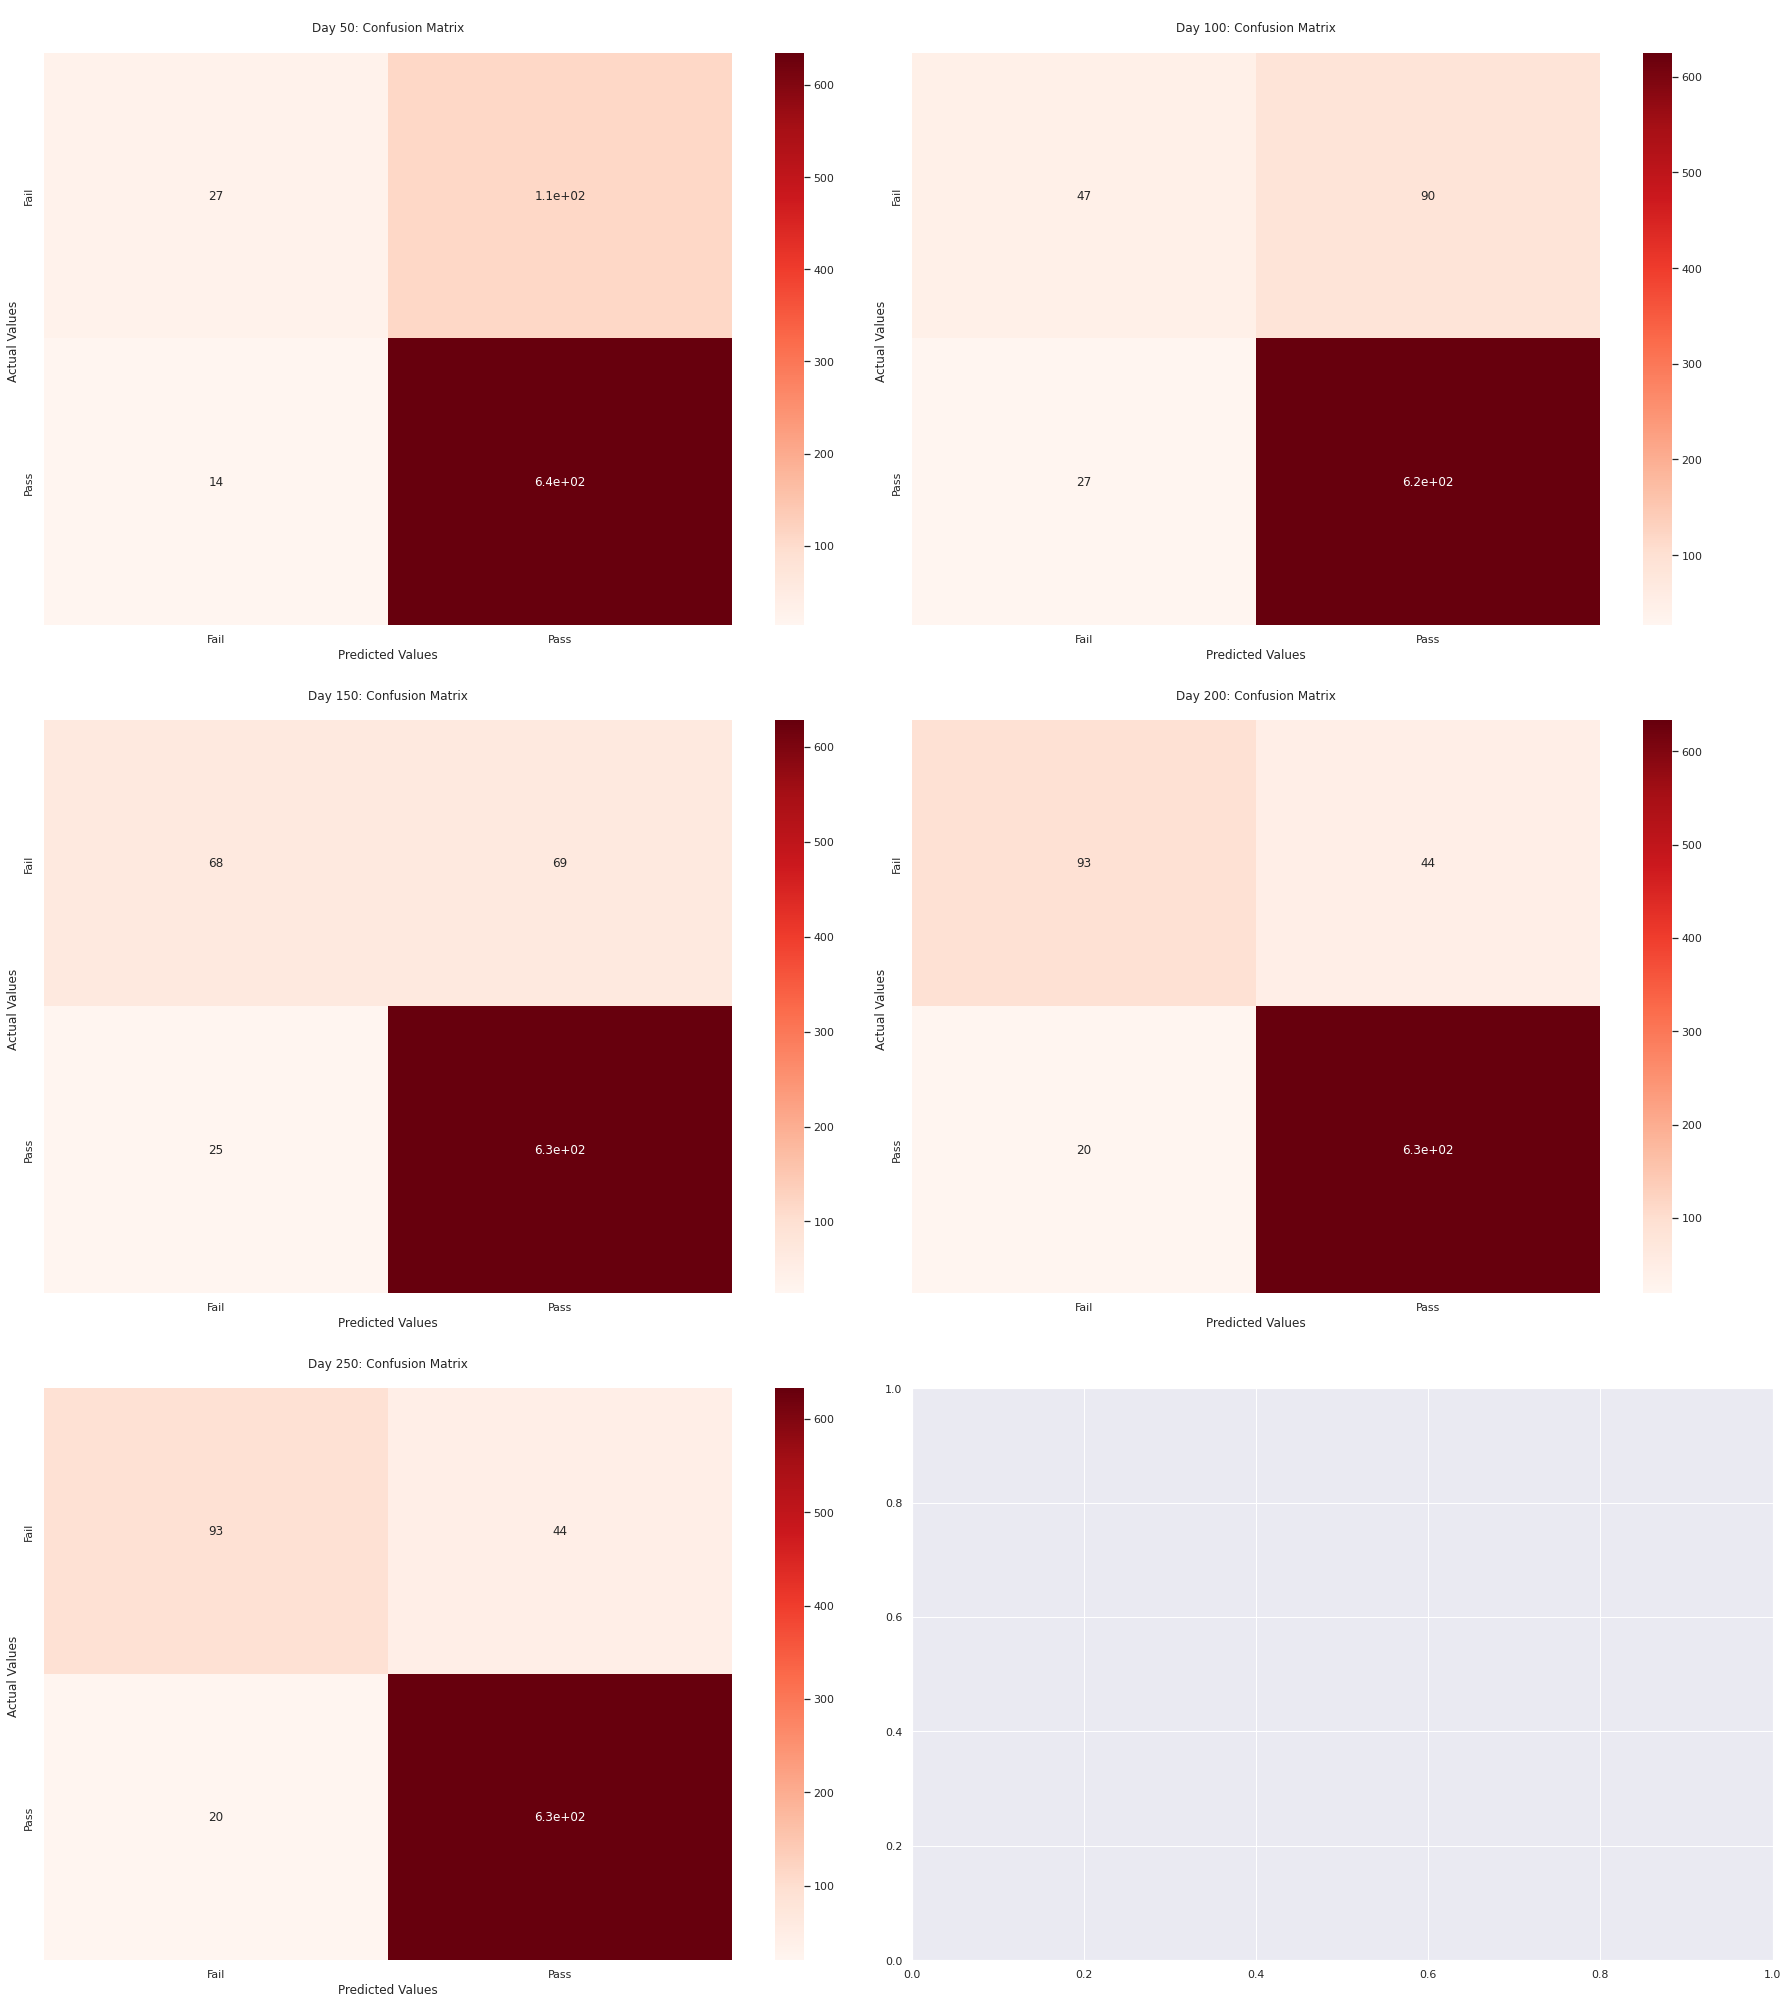

In [97]:
plot_confusion_matrix(performance_results_ab)

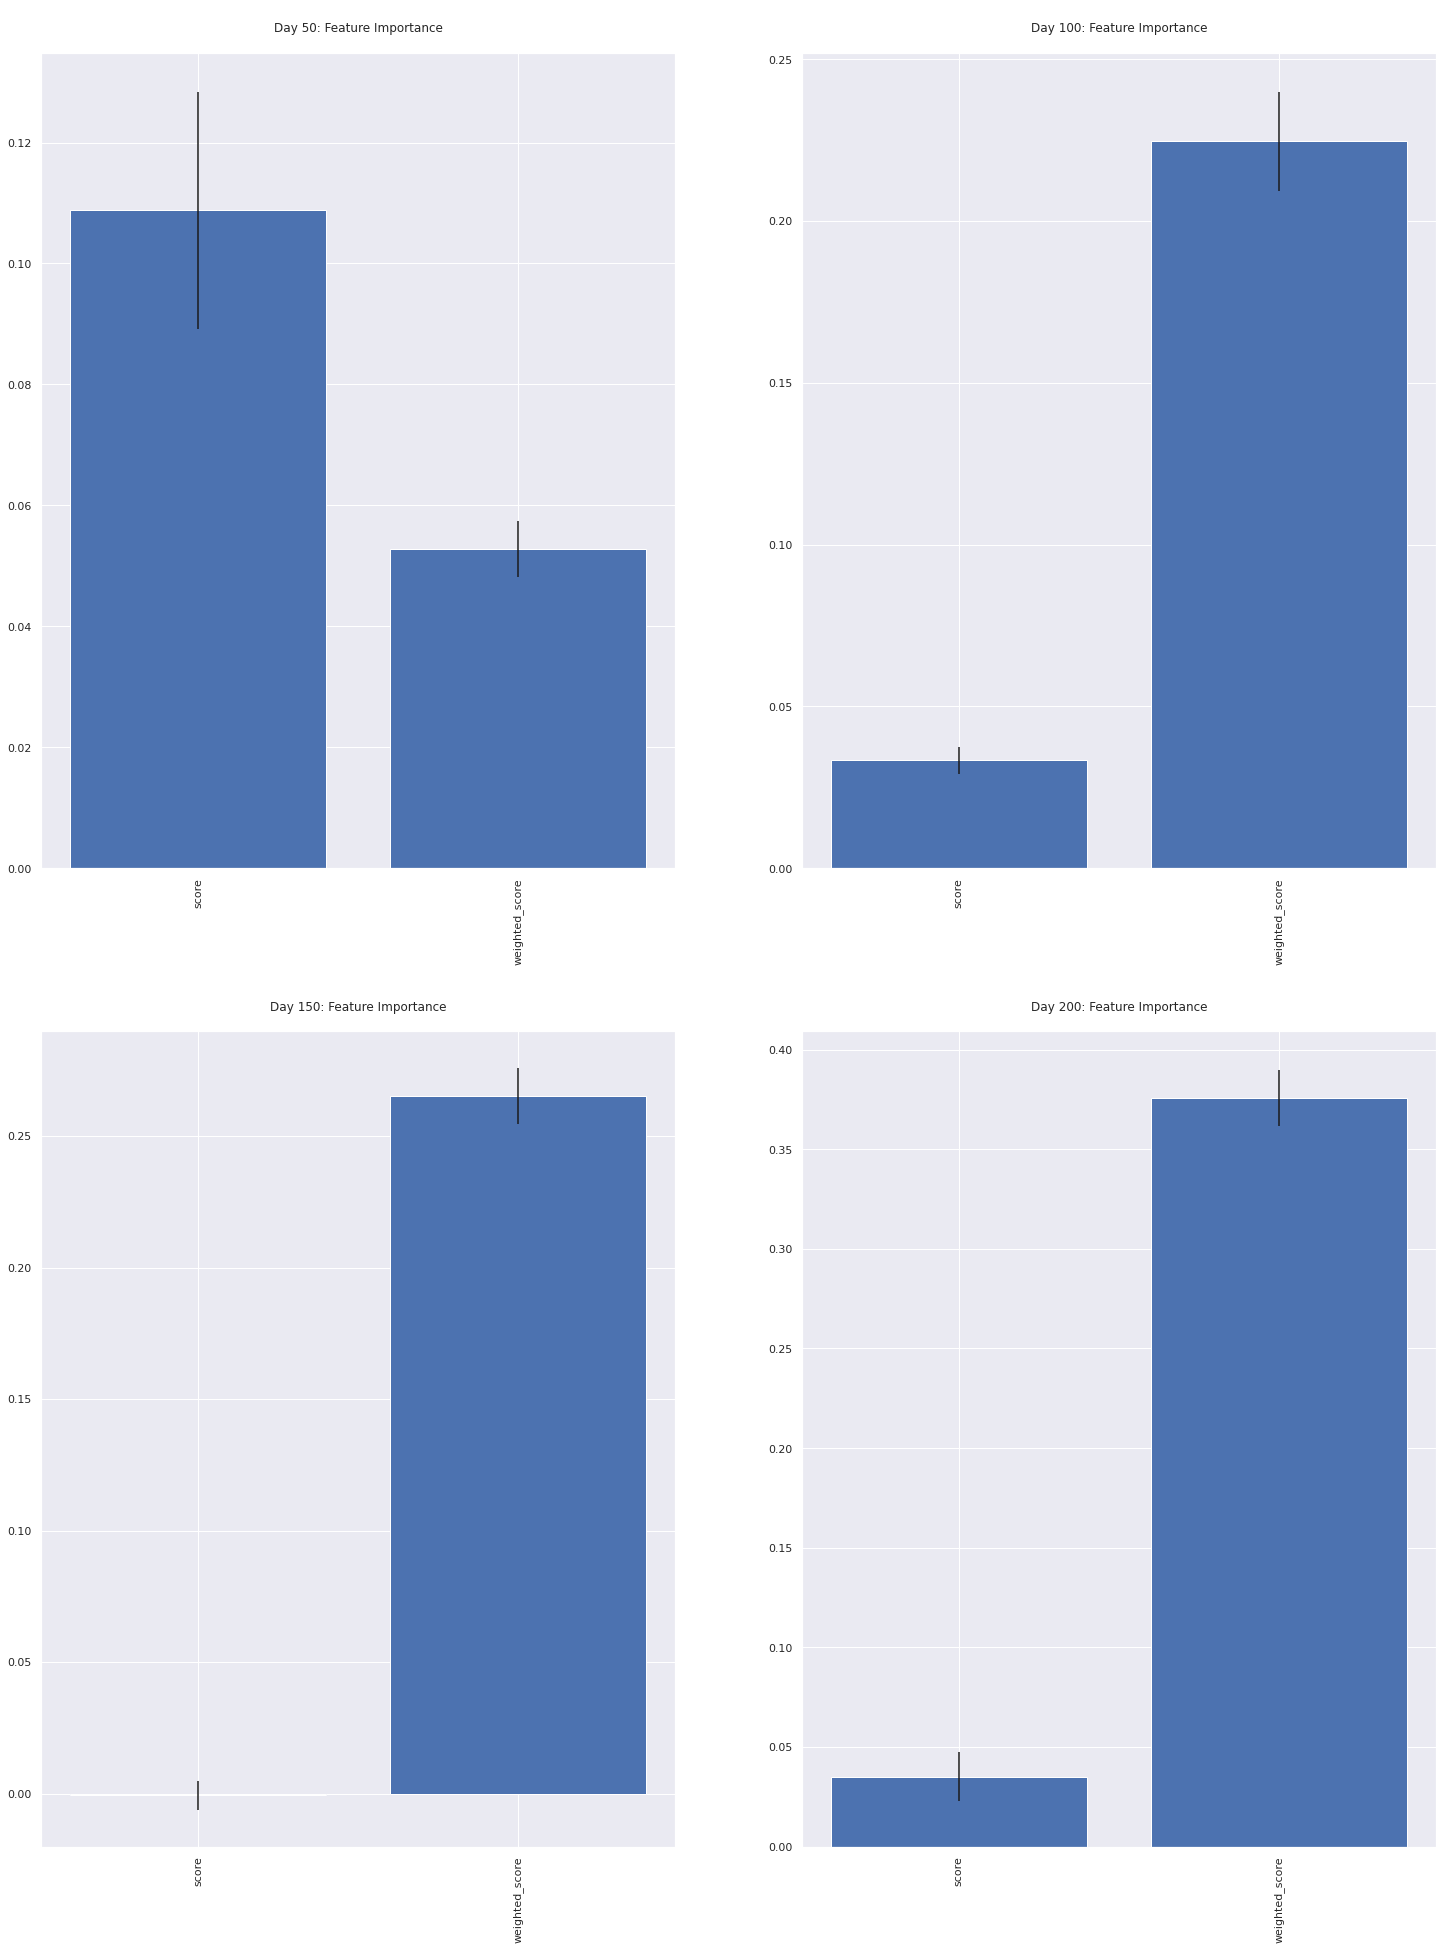

In [98]:
plot_feature_importance(performance_features_ab)

##### Plot results overview

In [99]:
performance_classifier_results = [performance_results_du, performance_results_nb, performance_results_lr, performance_results_lrw, performance_results_rf, performance_results_ab]
performance_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

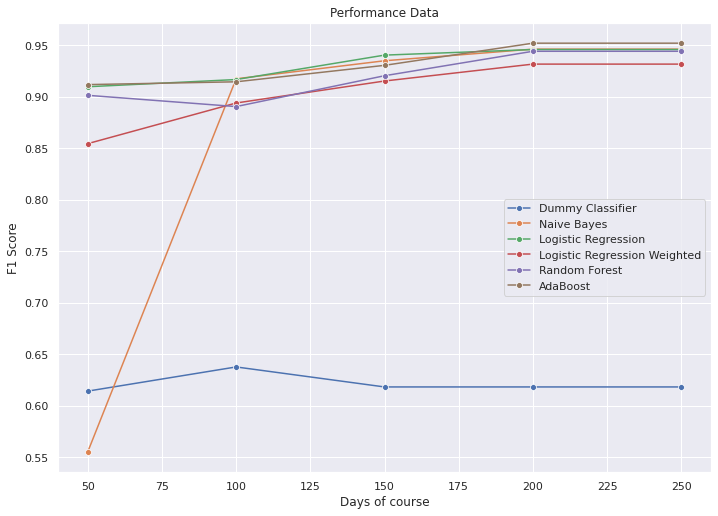

In [100]:
plot_days_compare(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

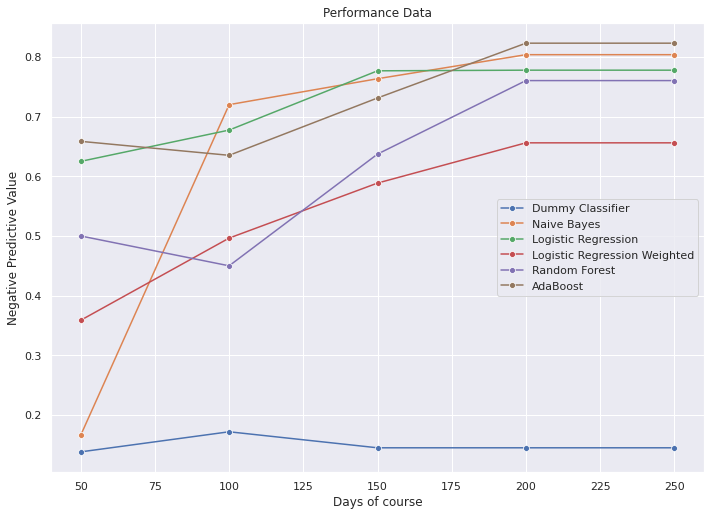

In [101]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

#### All data (Demographic, Learning Behaviour, Performance)

- Demographic and learning behaviour used throughout classifier
- Performance added for the last two predictions (200, 250) days

##### Prepare data for prediction

In [102]:
all_df = {}
for i in df.keys():
  all_df[i] = split_dataframe_by_data_type(df[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [103]:
all_df[50]

code_presentation  id_student gender  ...  score weighted_score final_result
0                2013J       35355      M  ...   86.0         13.846            1
1                2013J       42638      M  ...   83.0         13.363            1
2                2013J       43564      M  ...   94.0         15.134            1
3                2013J       54062      M  ...   78.0         12.558            1
4                2013J       63112      M  ...   88.0         14.168            1
...                ...         ...    ...  ...    ...            ...          ...
1943             2014J     2644404      M  ...   87.0         14.007            1
1944             2014J     2654928      M  ...   91.0         14.651            1
1945             2014J     2663195      M  ...   91.0         14.651            1
1946             2014J     2686053      M  ...   86.0         13.846            1
1947             2014J     2686712      M  ...  100.0         16.100            0

[1948 rows x 23 columns]

In [104]:
for i in list(df)[1:1]:
  all_df[i] = all_df[i].drop(columns=["score","weighted_score"])

for i in list(df)[1:]:
  all_df[i] = all_df[i].drop(columns=["score"])

In [105]:
all_df[50]

code_presentation  id_student gender  ... ouwiki weighted_score final_result
0                2013J       35355      M  ...    0.0         13.846            1
1                2013J       42638      M  ...    0.0         13.363            1
2                2013J       43564      M  ...    0.0         15.134            1
3                2013J       54062      M  ...    0.0         12.558            1
4                2013J       63112      M  ...    0.0         14.168            1
...                ...         ...    ...  ...    ...            ...          ...
1943             2014J     2644404      M  ...    0.0         14.007            1
1944             2014J     2654928      M  ...    0.0         14.651            1
1945             2014J     2663195      M  ...    2.0         14.651            1
1946             2014J     2686053      M  ...    0.0         13.846            1
1947             2014J     2686712      M  ...    0.0         16.100            0

[1948 rows x 22 columns]

###### Encode data

In [106]:
X_train, X_test, Y_train, Y_test = encode_data(all_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click', 'weighted_score'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucontent', 'dualpane', 'oucollaborate', 'subpage', 'quiz', 'url',
       'homepage', 'resource', 'forumng', 'mean_click', 'weighted_score'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['oucontent', 'dualpane', 'oucol

In [107]:
X_train[50]

gender_F  gender_M  ...  mean_click  weighted_score
0         0.0       1.0  ...    0.429913        0.810811
1         0.0       1.0  ...    0.532832        0.770270
2         0.0       1.0  ...    0.486876        0.918919
3         0.0       1.0  ...    0.442768        0.702703
4         0.0       1.0  ...    0.573862        0.837838
..        ...       ...  ...         ...             ...
702       0.0       1.0  ...    0.449667        0.554054
703       0.0       1.0  ...    0.599653        0.527027
704       0.0       1.0  ...    0.598836        0.770270
705       0.0       1.0  ...    0.357866        0.743243
706       0.0       1.0  ...    0.470308        0.472973

[707 rows x 46 columns]

###### Undersampling

In [108]:
Y_train[50].value_counts()

1    567
0    140
Name: final_result, dtype: int64

In [109]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = TomekLinks() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 495, 0: 117})
Resample dataset shape Counter({1: 444, 0: 117})
Sampling for day 50
Original dataset shape: Counter({1: 567, 0: 140})
Resample dataset shape Counter({1: 510, 0: 140})
Sampling for day 100
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({1: 517, 0: 141})
Sampling for day 150
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({1: 522, 0: 141})
Sampling for day 200
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({1: 523, 0: 141})
Sampling for day 250
Original dataset shape: Counter({1: 568, 0: 141})
Resample dataset shape Counter({1: 522, 0: 141})


###### Reduce dimensions

In [110]:
for i in df.keys():
  pca = PCA(n_components='mle')

  X_train[i] = pca.fit_transform(X_train[i], Y_train[i])                             
  
  X_test[i] = pca.transform(X_test[i])

In [111]:
X_train[250].shape

(709, 41)

###### Feature selection

In [112]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [113]:
X_train[250]

0         1         2   ...        17        18        19
0    0.139524  0.019334 -0.168487  ...  0.015453 -0.130964 -0.110308
1    0.998186  0.295799  0.105144  ... -0.050297  0.244042 -0.072808
2    1.050865  0.229709  0.125724  ... -0.050531 -0.029780 -0.018490
3    0.103429 -0.197559 -0.232742  ...  0.147787 -0.046022  0.233366
4    0.244394 -0.035724  0.240645  ...  0.321301 -0.154569 -0.012180
..        ...       ...       ...  ...       ...       ...       ...
704 -0.925080  0.121154 -0.601446  ... -0.034206 -0.007534  0.077723
705 -0.830204 -0.139865  0.228202  ...  0.076409  0.206467 -0.071660
706  1.127921 -0.068960 -0.165035  ...  0.121210  0.077937 -0.285338
707  0.094986  0.127065 -0.106069  ...  0.018983 -0.121534 -0.132755
708 -0.881546  0.152482 -0.118981  ... -0.010887  0.141454  0.262446

[709 rows x 20 columns]

##### DummyClassifier

In [114]:
from sklearn.dummy import DummyClassifier

all_results_du = []
all_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_du.append([acc, f1, prec, recall, conf])
  all_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.464
Best parameters set:
Accuracy: 0.524822695035461, F1 Score: 0.6484784889821615, Precision: 0.8373983739837398, Recall: 0.5291095890410958


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.468
Best parameters set:
Accuracy: 0.4802547770700637, F1 Score: 0.614366729678639, Precision: 0.7946210268948656, Recall: 0.5007704160246533


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best parameters set:
Accuracy: 0.5120405576679341, F1 Score: 0.6378174976481655, Precision: 0.8248175182481752, Recall: 0.5199386503067485


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.452
Best p

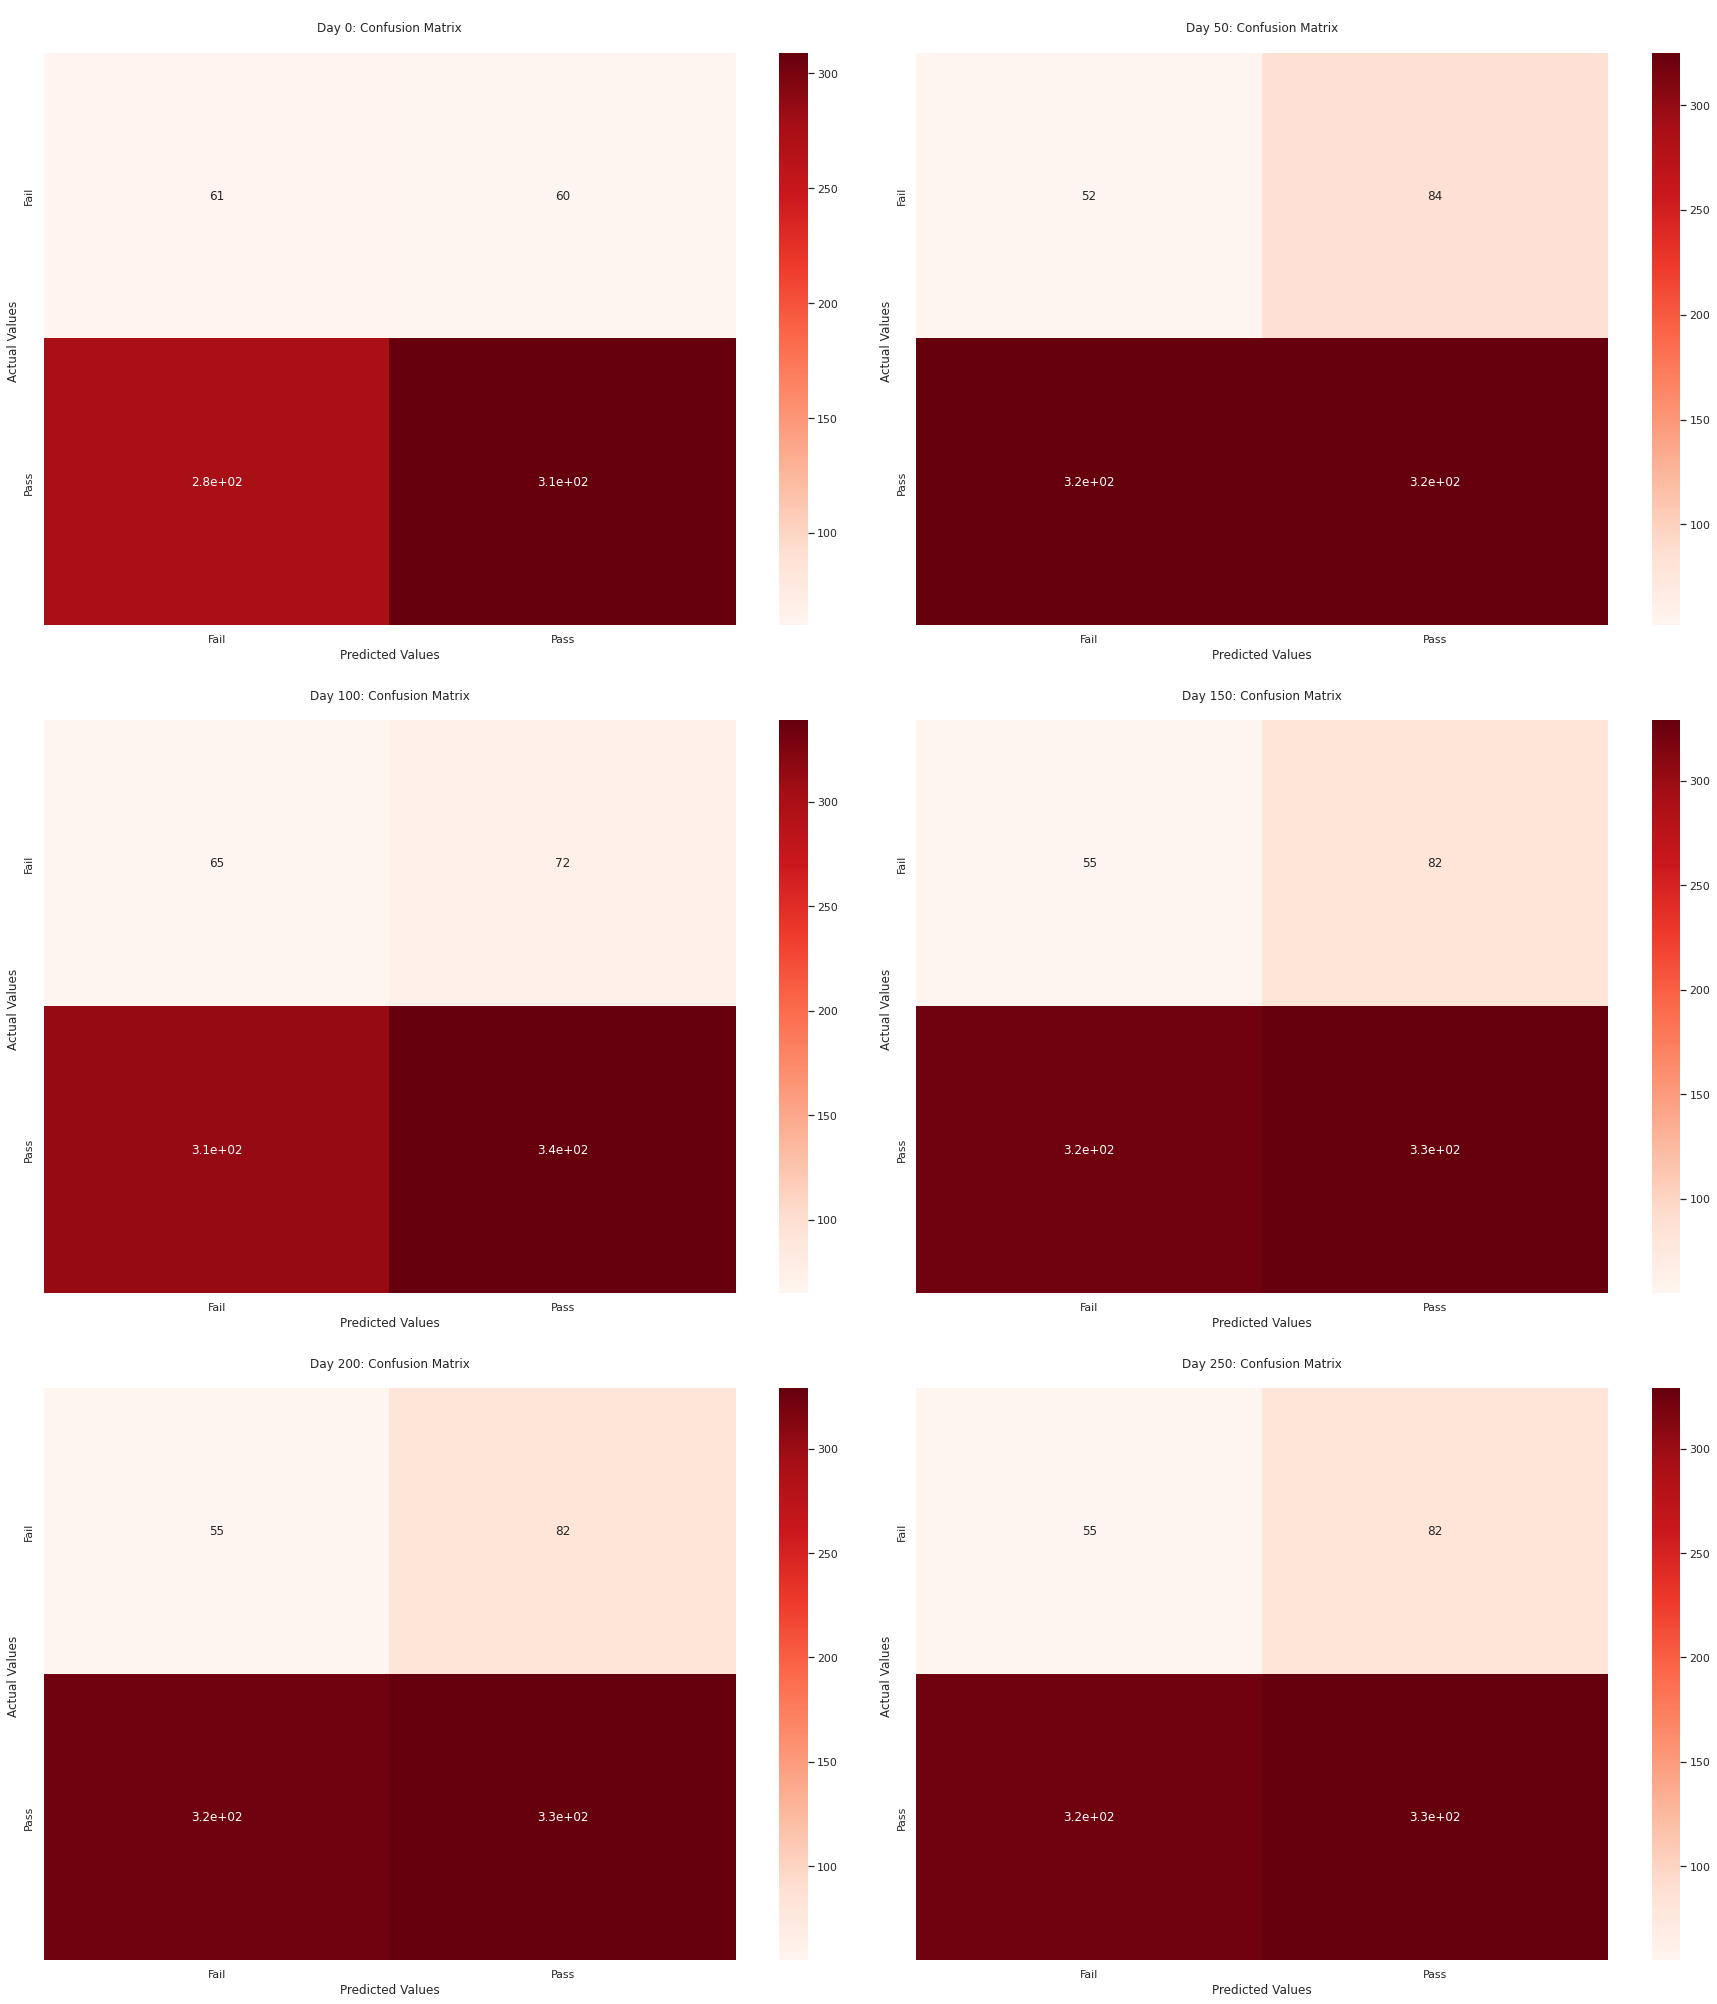

In [115]:
plot_confusion_matrix(all_results_du)

##### NaiveBayes

In [116]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

all_results_nb = []

pipeline = Pipeline([
    ('clf', GaussianNB()),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_nb.append([acc, f1, prec, recall, conf])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.515
Best parameters set:
Accuracy: 0.6212765957446809, F1 Score: 0.7405247813411079, Precision: 0.8561797752808988, Recall: 0.6523972602739726


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.639
Best parameters set:
Accuracy: 0.8050955414012739, F1 Score: 0.8859060402684565, Precision: 0.8583815028901735, Recall: 0.9152542372881356


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.694
Best parameters set:
Accuracy: 0.7731305449936628, F1 Score: 0.8622016936104695, Precision: 0.865533230293663, Recall: 0.8588957055214724


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.790
Best 

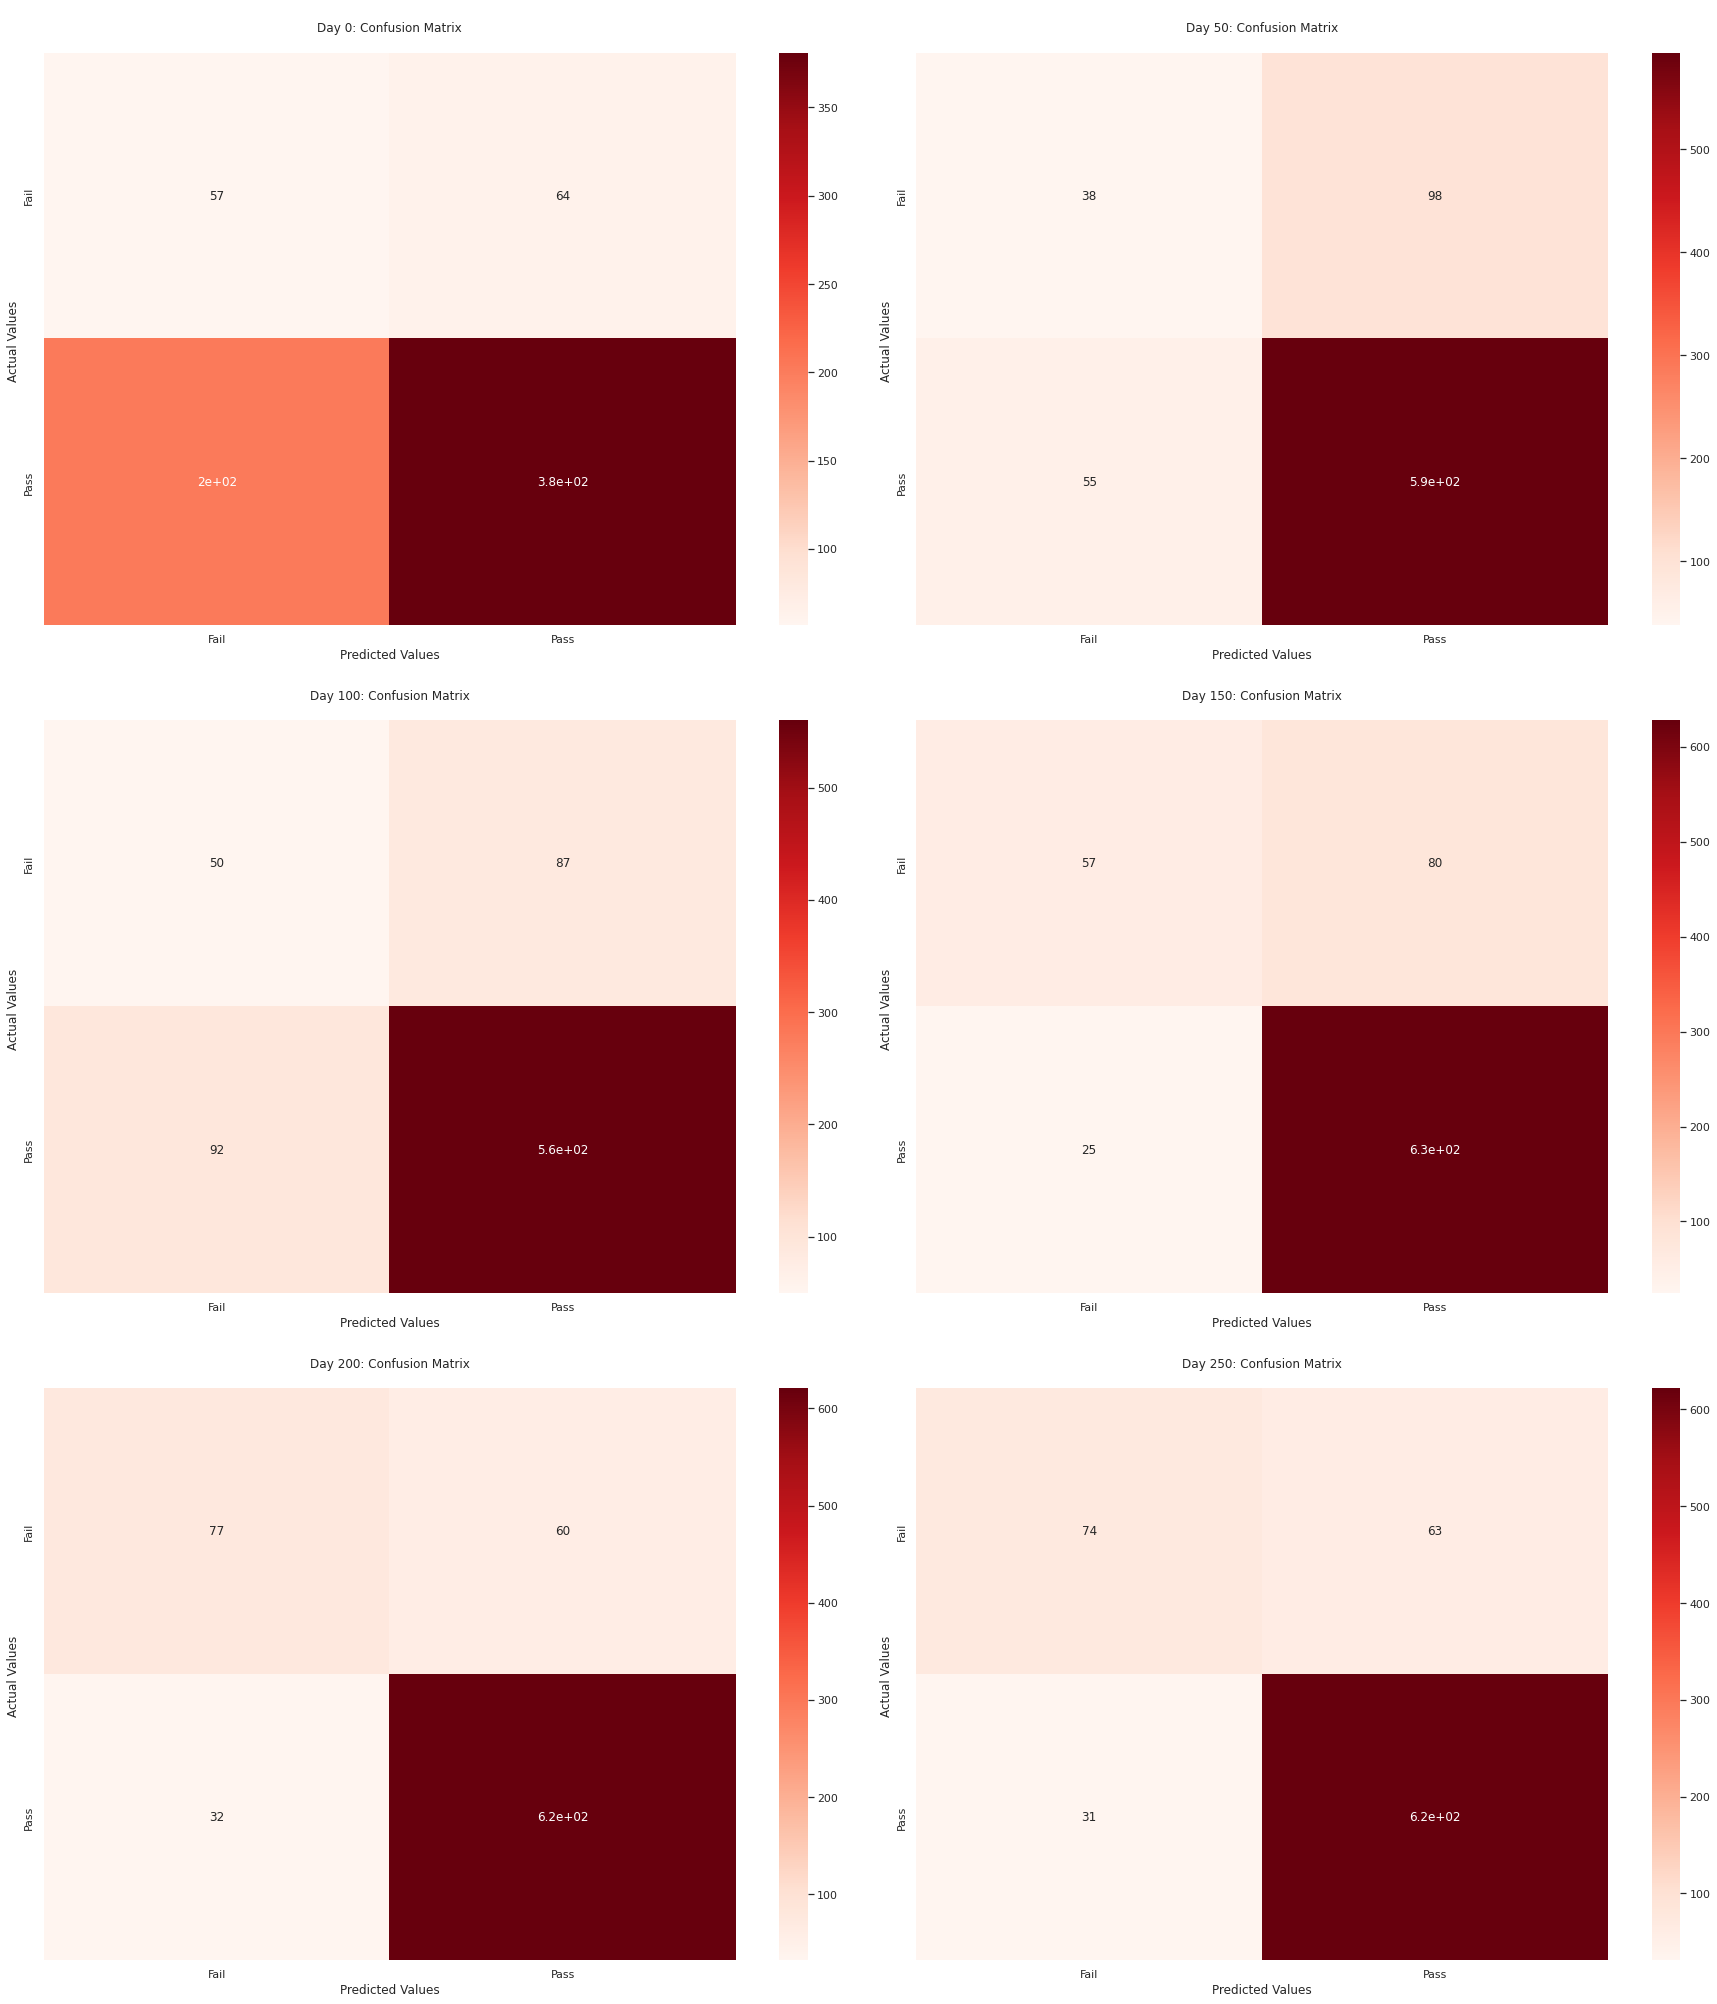

In [117]:
plot_confusion_matrix(all_results_nb)

##### LogisticRegression

In [118]:
from sklearn.linear_model import LogisticRegression

all_results_predict_proba_lr = []
all_results_predict_lr = []

all_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lr.append([acc, f1, prec, recall, conf])
  all_results_predict_proba_lr.append(predictions_proba)
  all_results_predict_lr.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.524
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8184397163120567, F1 Score: 0.89937106918239, Precision: 0.8313953488372093, Recall: 0.9794520547945206


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.679
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8229299363057325, F1 Score: 0.8999280057595392, Precision: 0.8445945945945946, Recall: 0.963020030816641


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.762
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.8580481622306717, F1 Score: 0.9188405797101451, Precision: 0.8708791208791209, Recall: 0.97239263803680

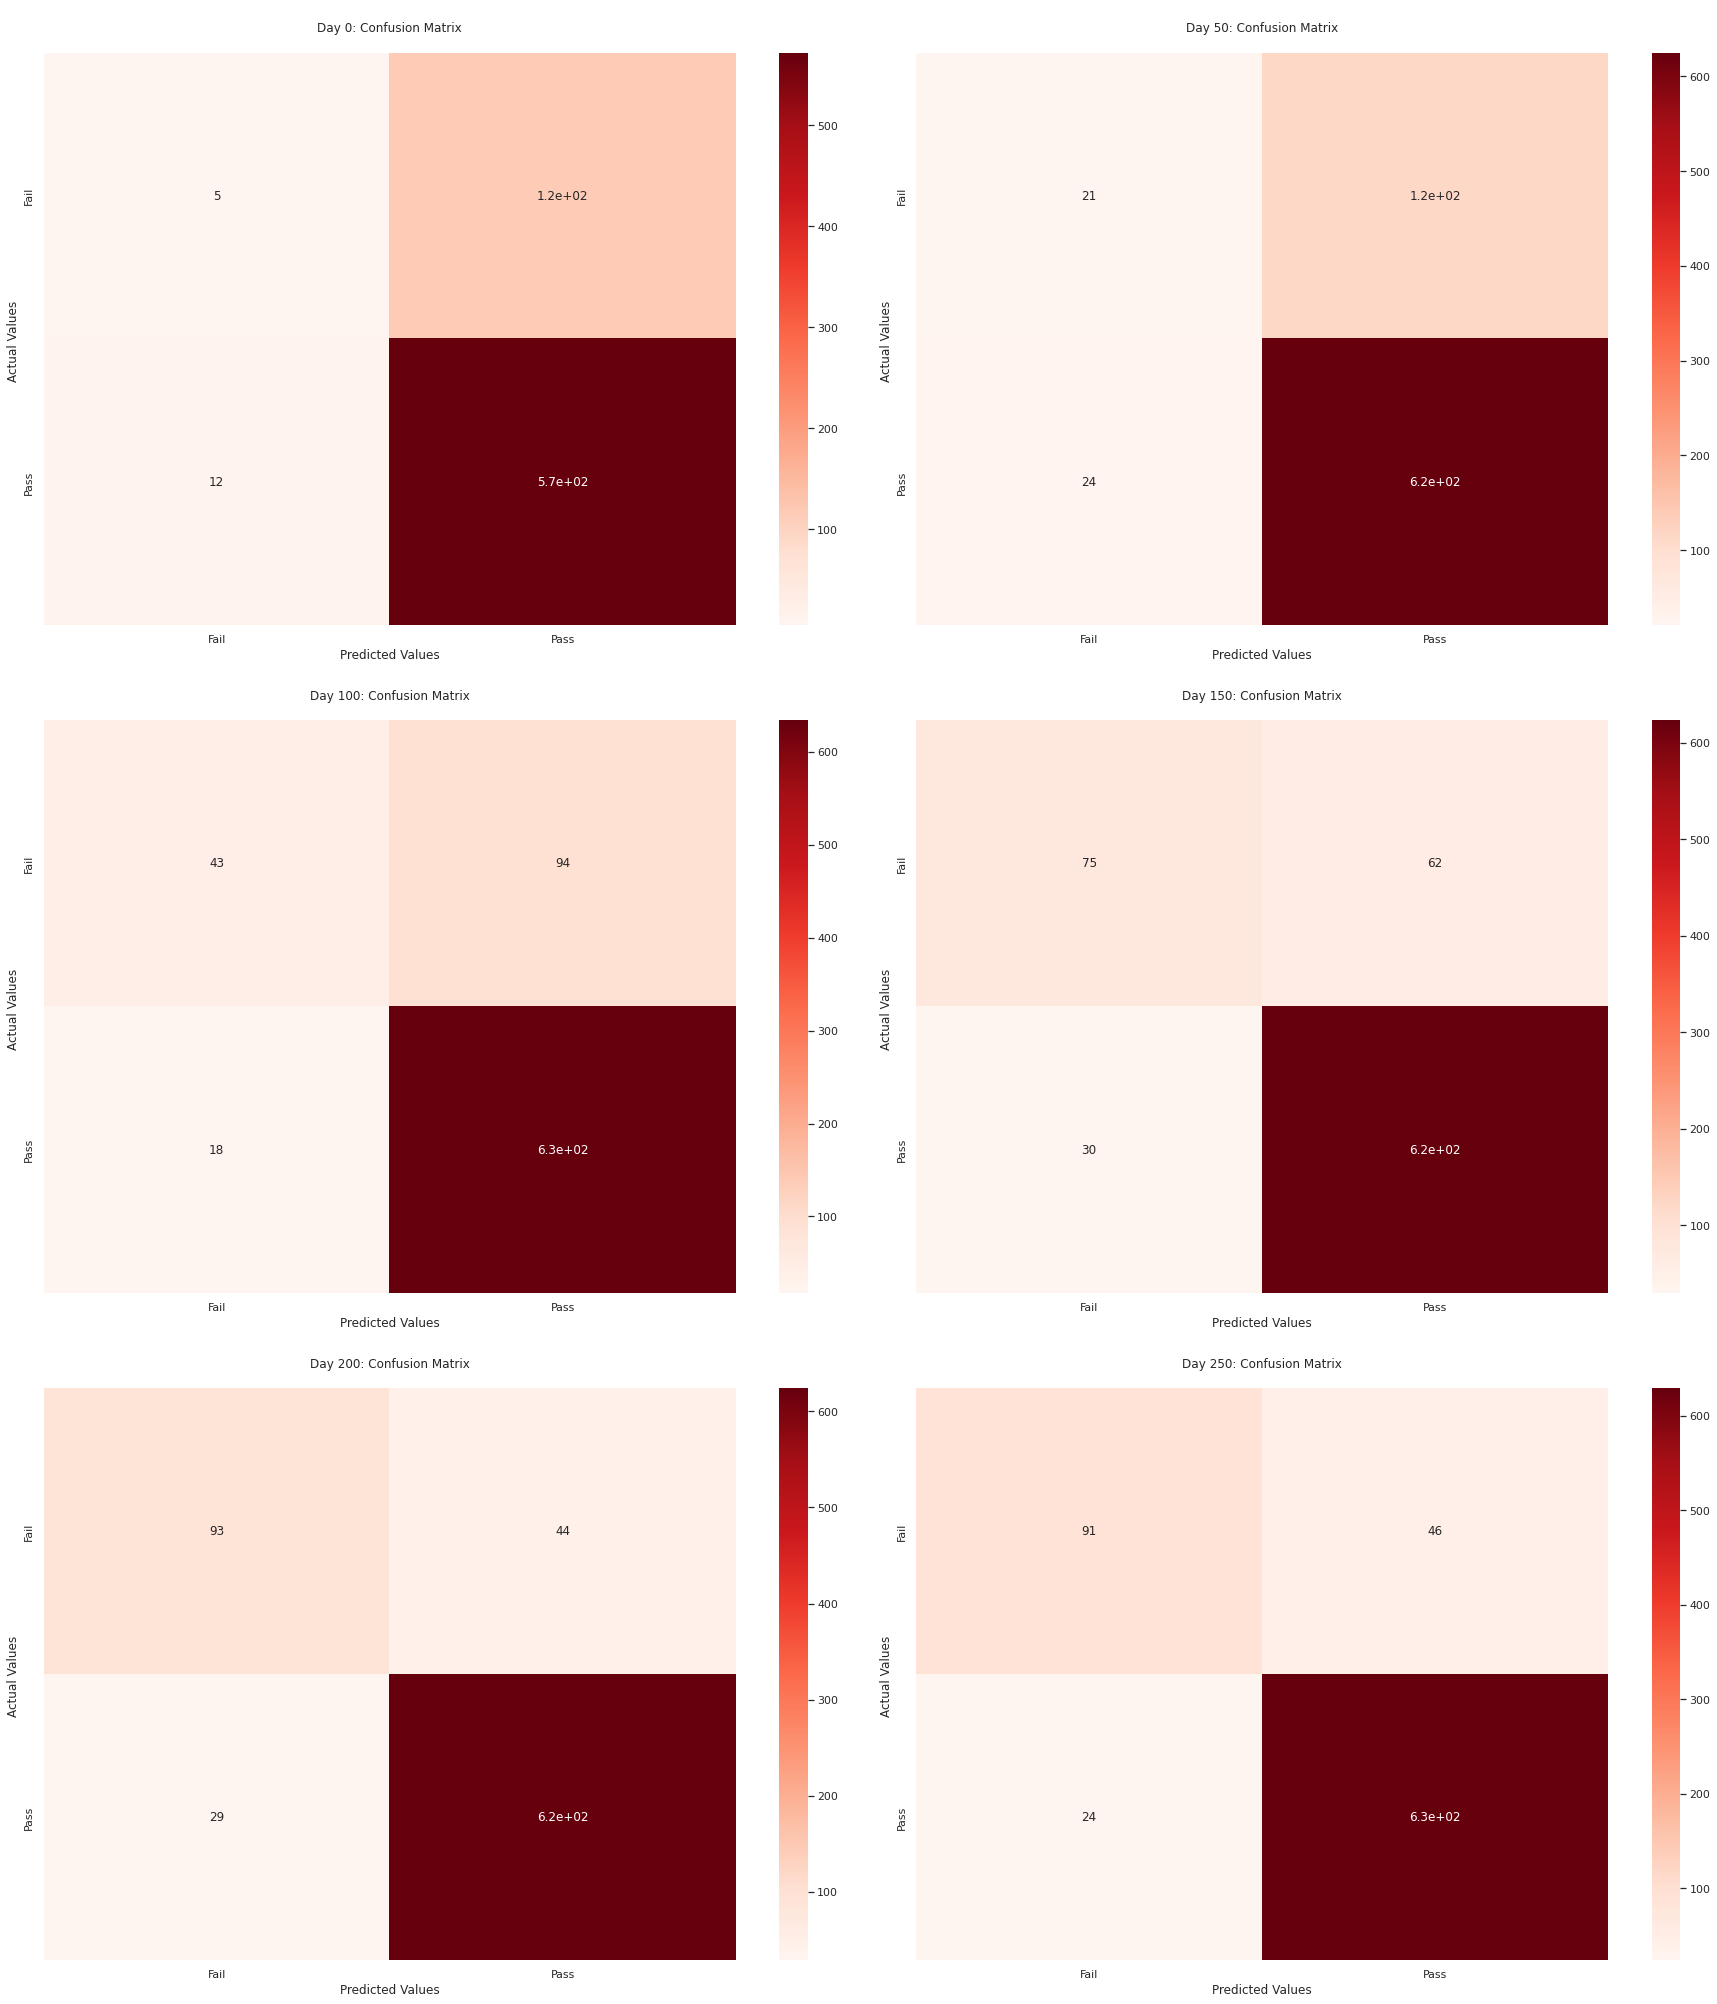

In [119]:
plot_confusion_matrix(all_results_lr)

##### WeightedLogisticRegression

In [120]:
all_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.552
Best parameters set:
Accuracy: 0.5787234042553191, F1 Score: 0.6928645294725958, Precision: 0.8746736292428199, Recall: 0.5736301369863014


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.653
Best parameters set:
Accuracy: 0.756687898089172, F1 Score: 0.8492501973164956, Precision: 0.8705501618122977, Recall: 0.8289676425269645


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.746
Best parameters set:
Accuracy: 0.8098859315589354, F1 Score: 0.885145482388974, Precision: 0.8837920489296636, Recall: 0.8865030674846626


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.789
Best p

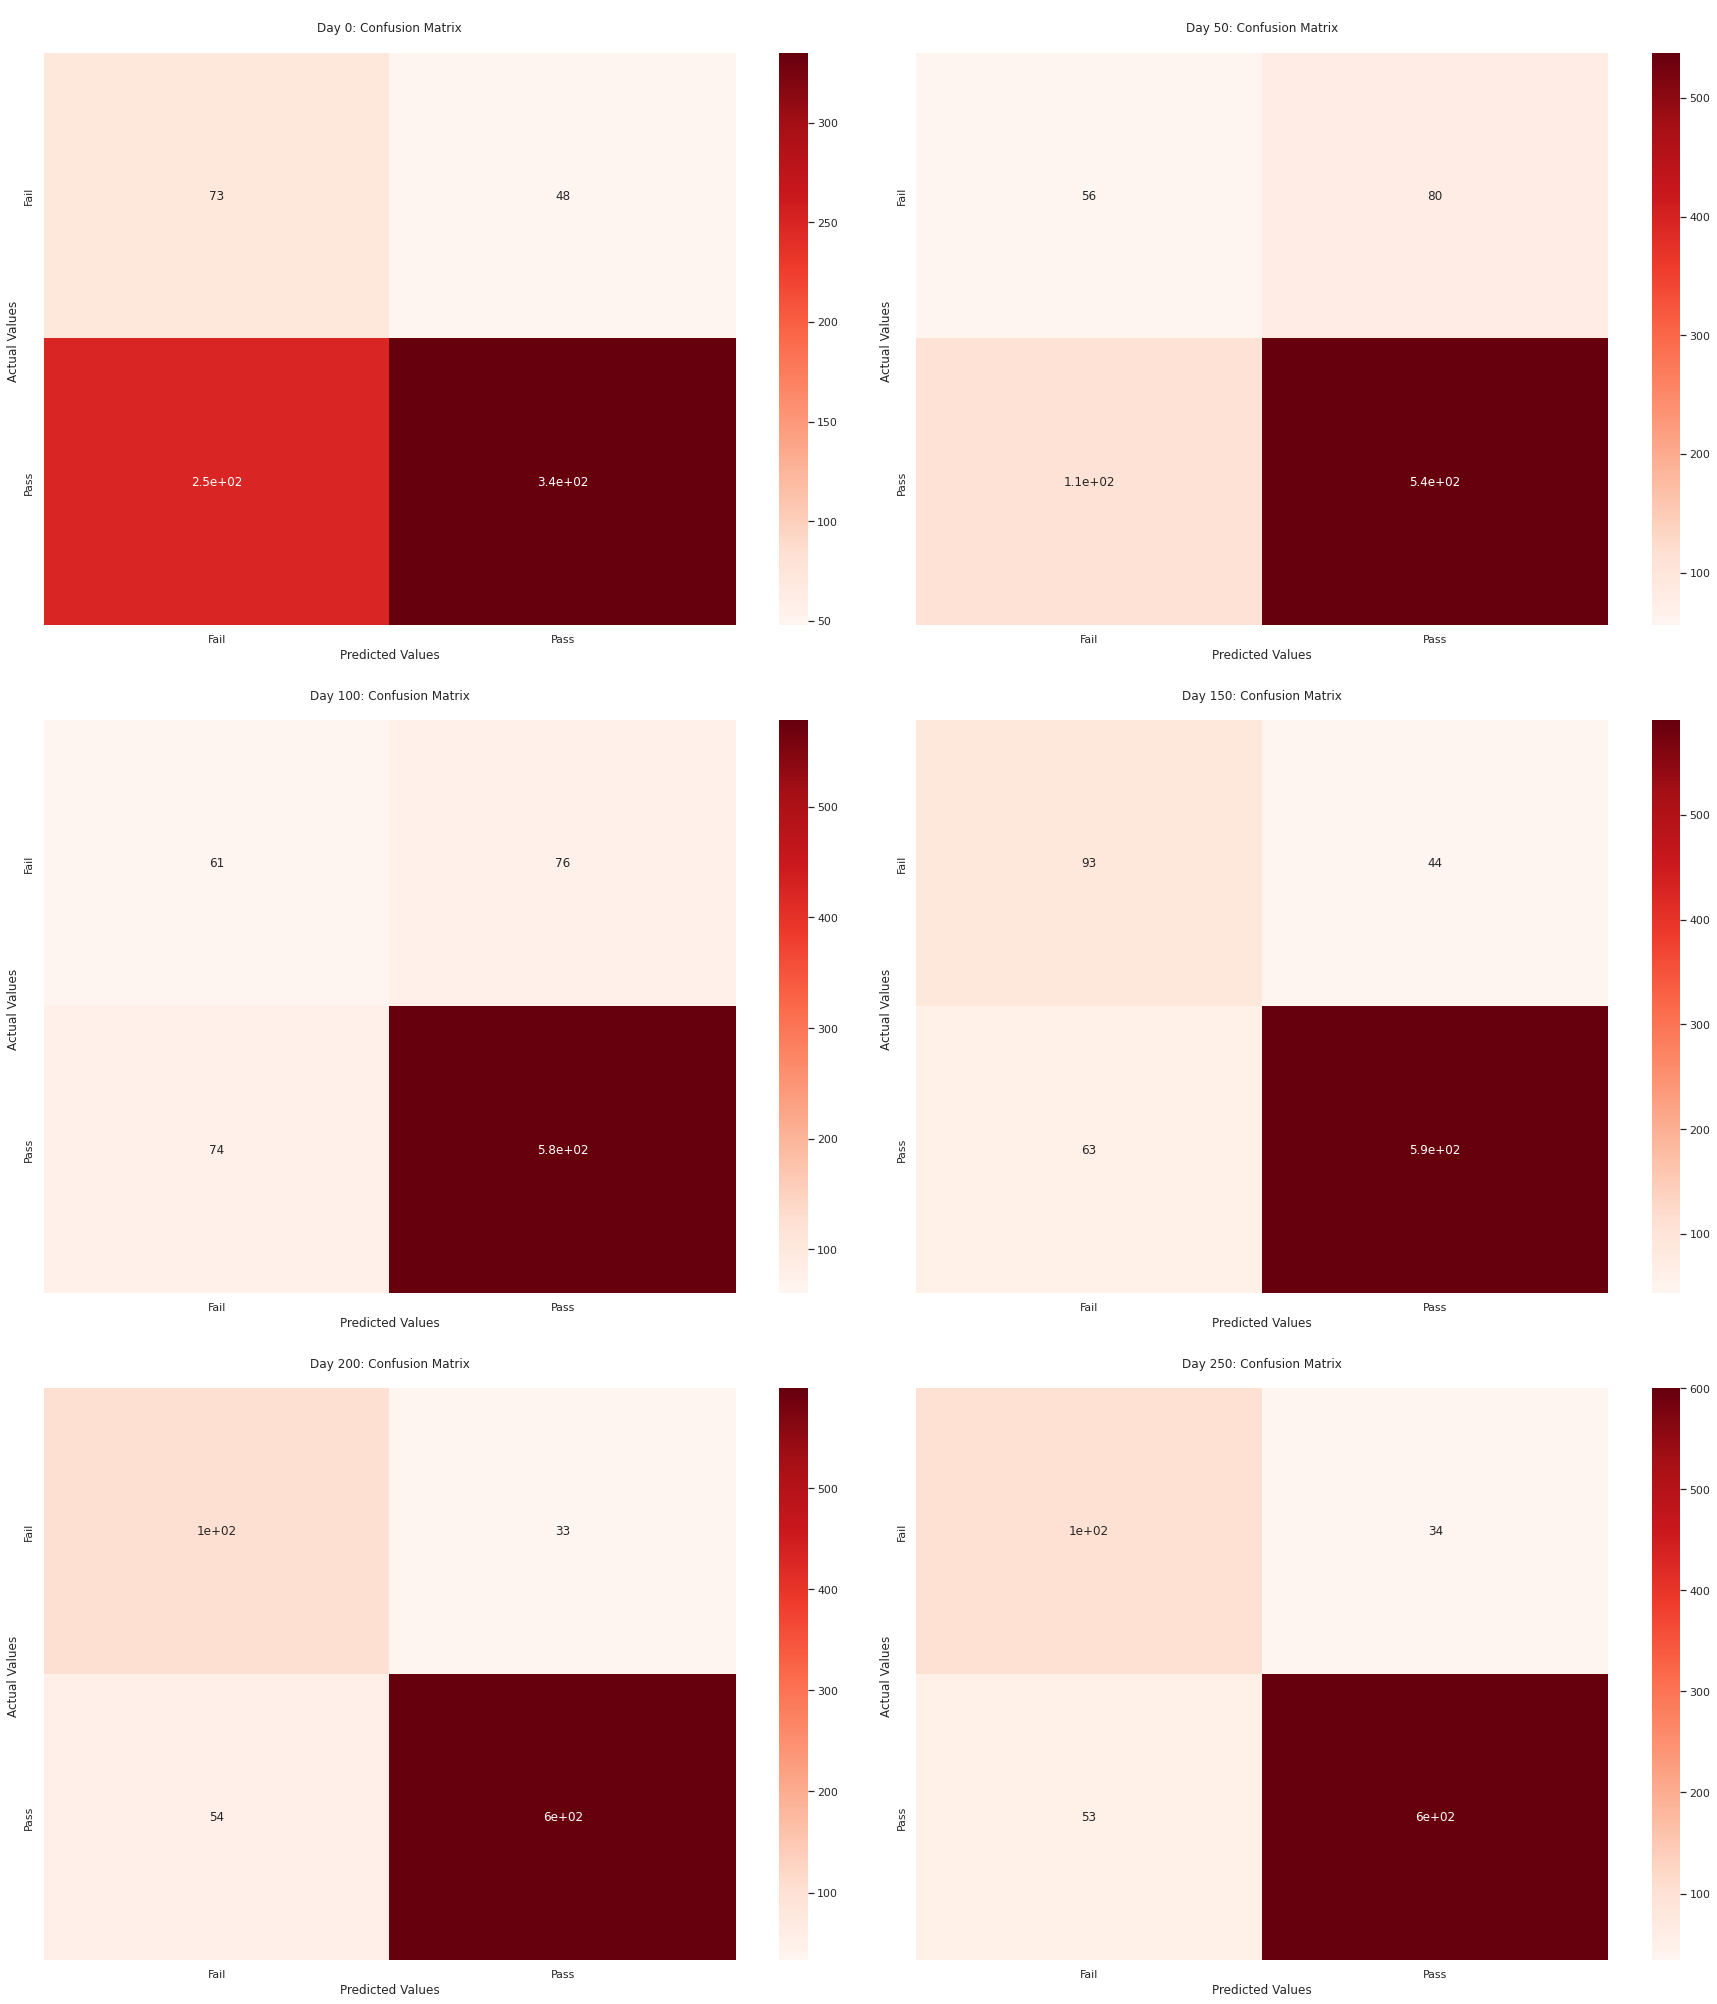

In [121]:
plot_confusion_matrix(all_results_lrw)

##### RandomForest

In [122]:
from sklearn.ensemble import RandomForestClassifier

all_results_rf = []
all_results_predict_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_rf.append([acc, f1, prec, recall, conf])
  all_results_predict_rf.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.525
Best parameters set:
	clf__n_estimators: 120
Accuracy: 0.8184397163120567, F1 Score: 0.89937106918239, Precision: 0.8313953488372093, Recall: 0.9794520547945206


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.634
Best parameters set:
	clf__n_estimators: 120
Accuracy: 0.8165605095541402, F1 Score: 0.8968481375358167, Precision: 0.8380187416331994, Recall: 0.9645608628659477


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.741
Best parameters set:
	clf__n_estimators

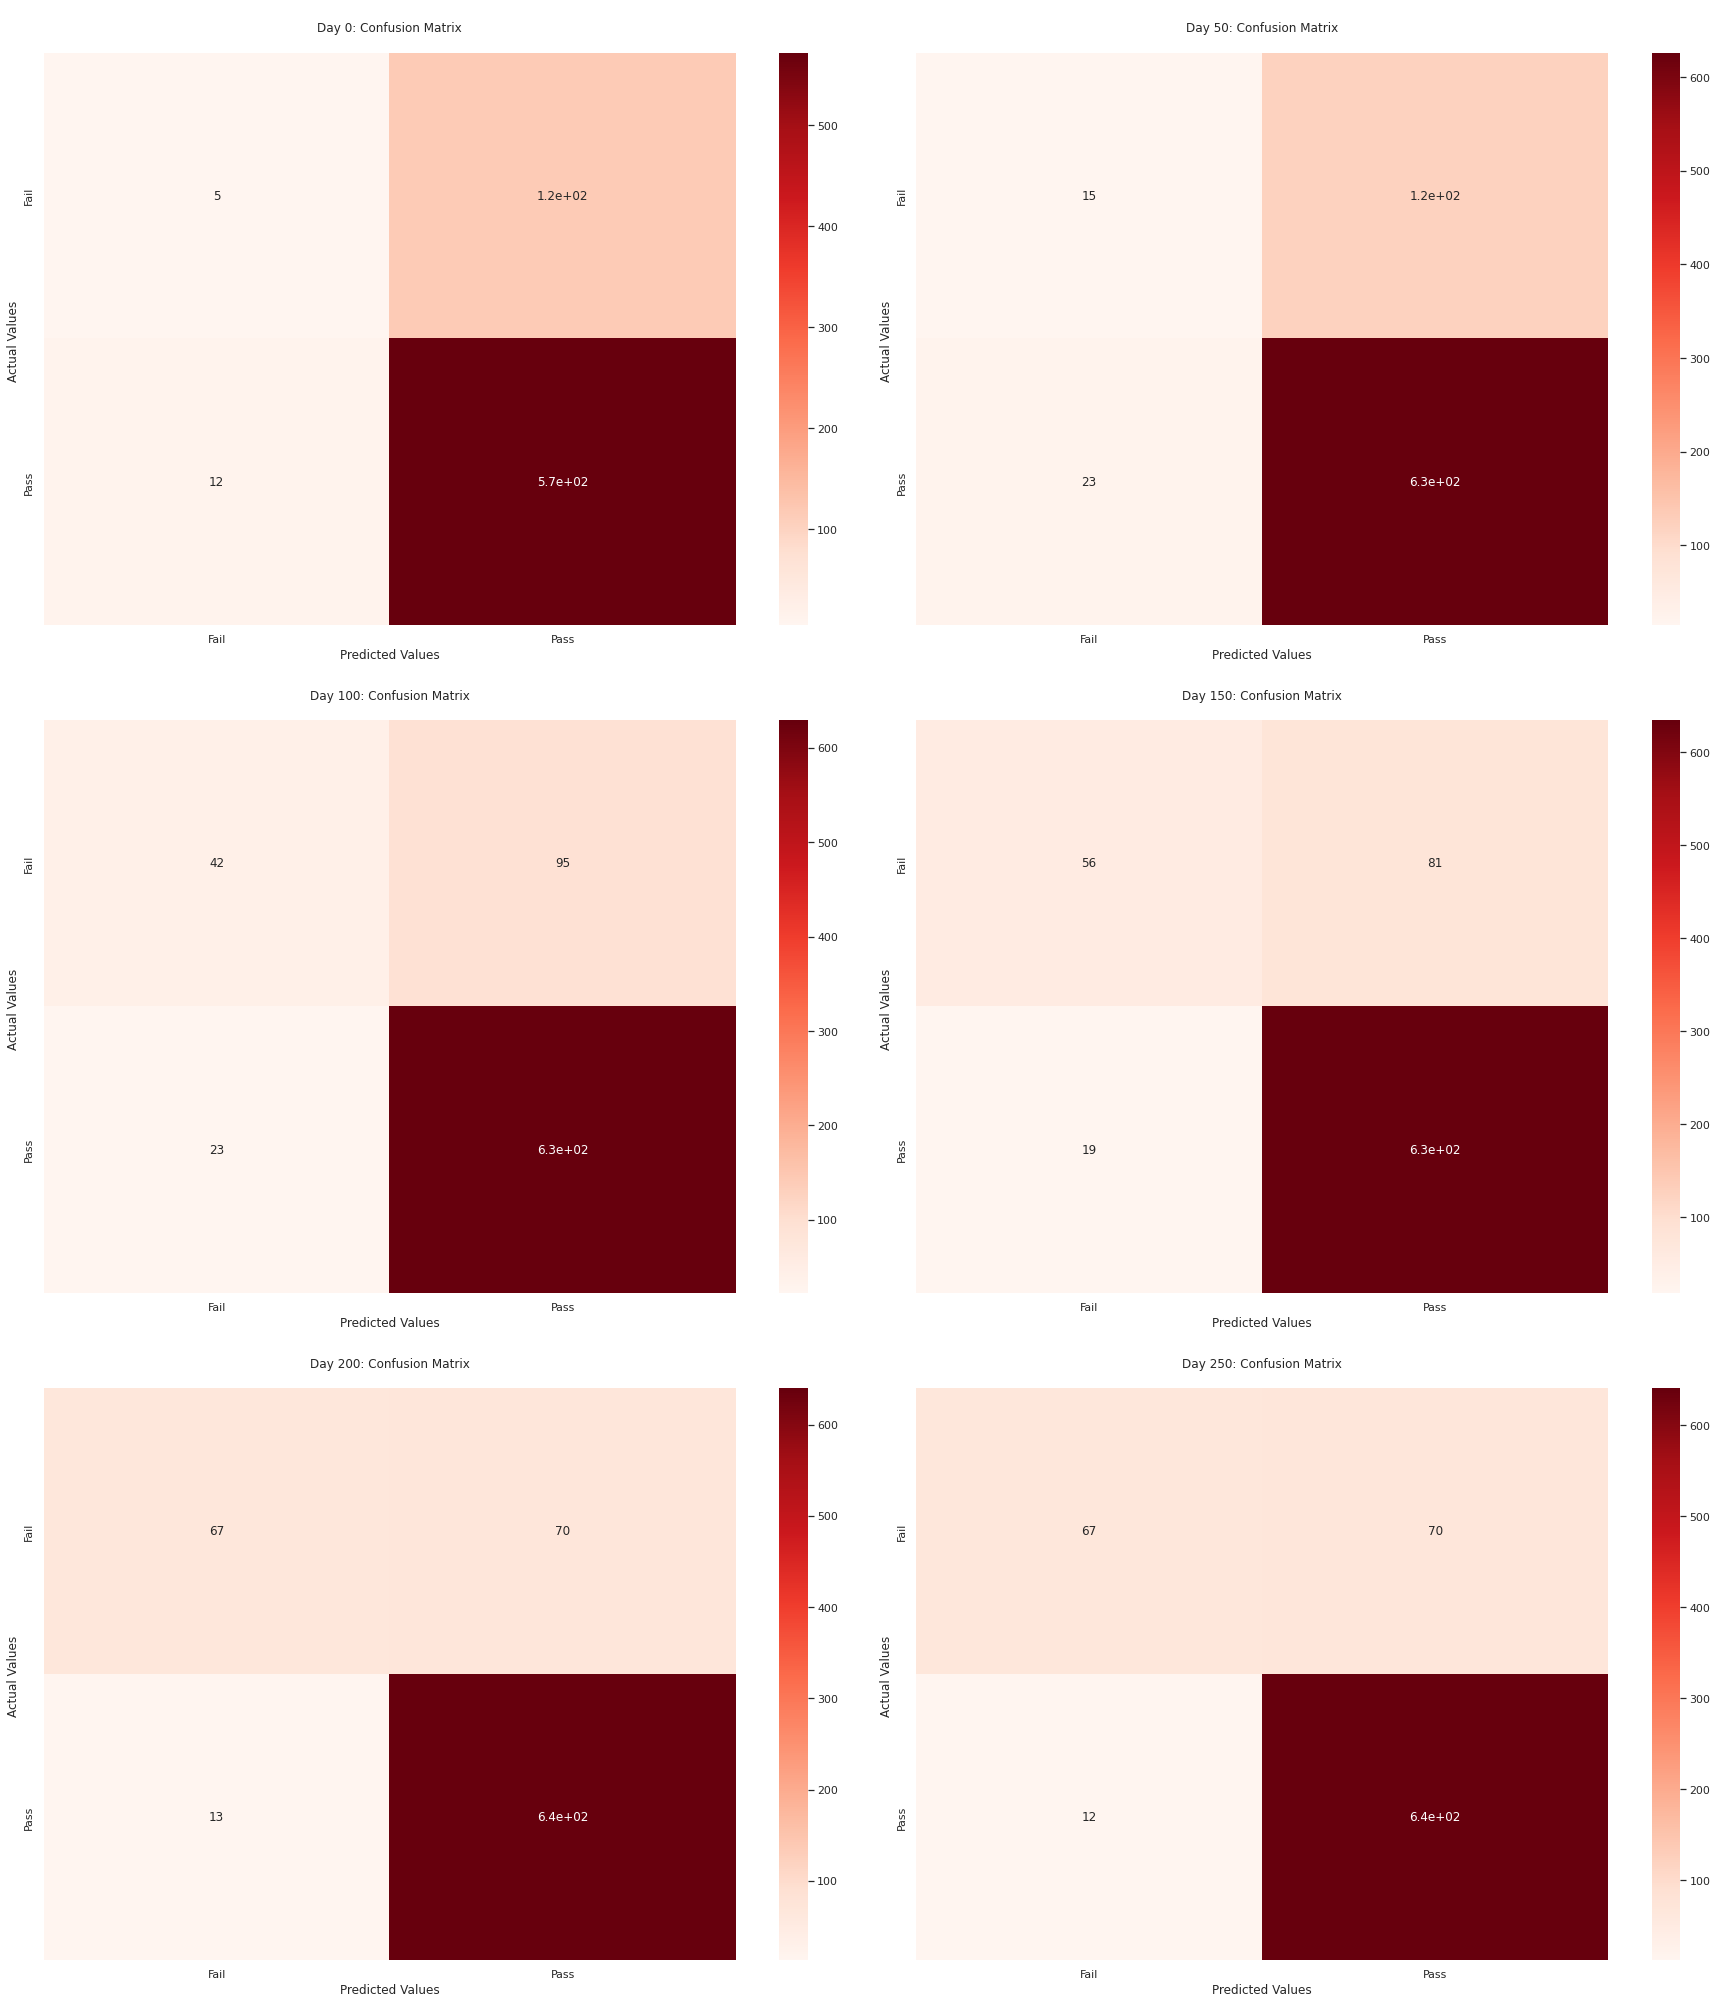

In [123]:
plot_confusion_matrix(all_results_rf)

##### AdaBoost

In [124]:
from sklearn.ensemble import AdaBoostClassifier

all_results_ab = []
all_results_predict_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_ab.append([acc, f1, prec, recall, conf])
  all_results_predict_ab.append(predictions)
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.533
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.8070921985815603, F1 Score: 0.8918918918918919, Precision: 0.8323442136498517, Recall: 0.9606164383561644


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.669
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.8140127388535032, F1 Score: 0.8957142857142857, Precision: 0.8348868175765646, Recall: 0.9661016949152542


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.744
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.8415716096324461, F1 

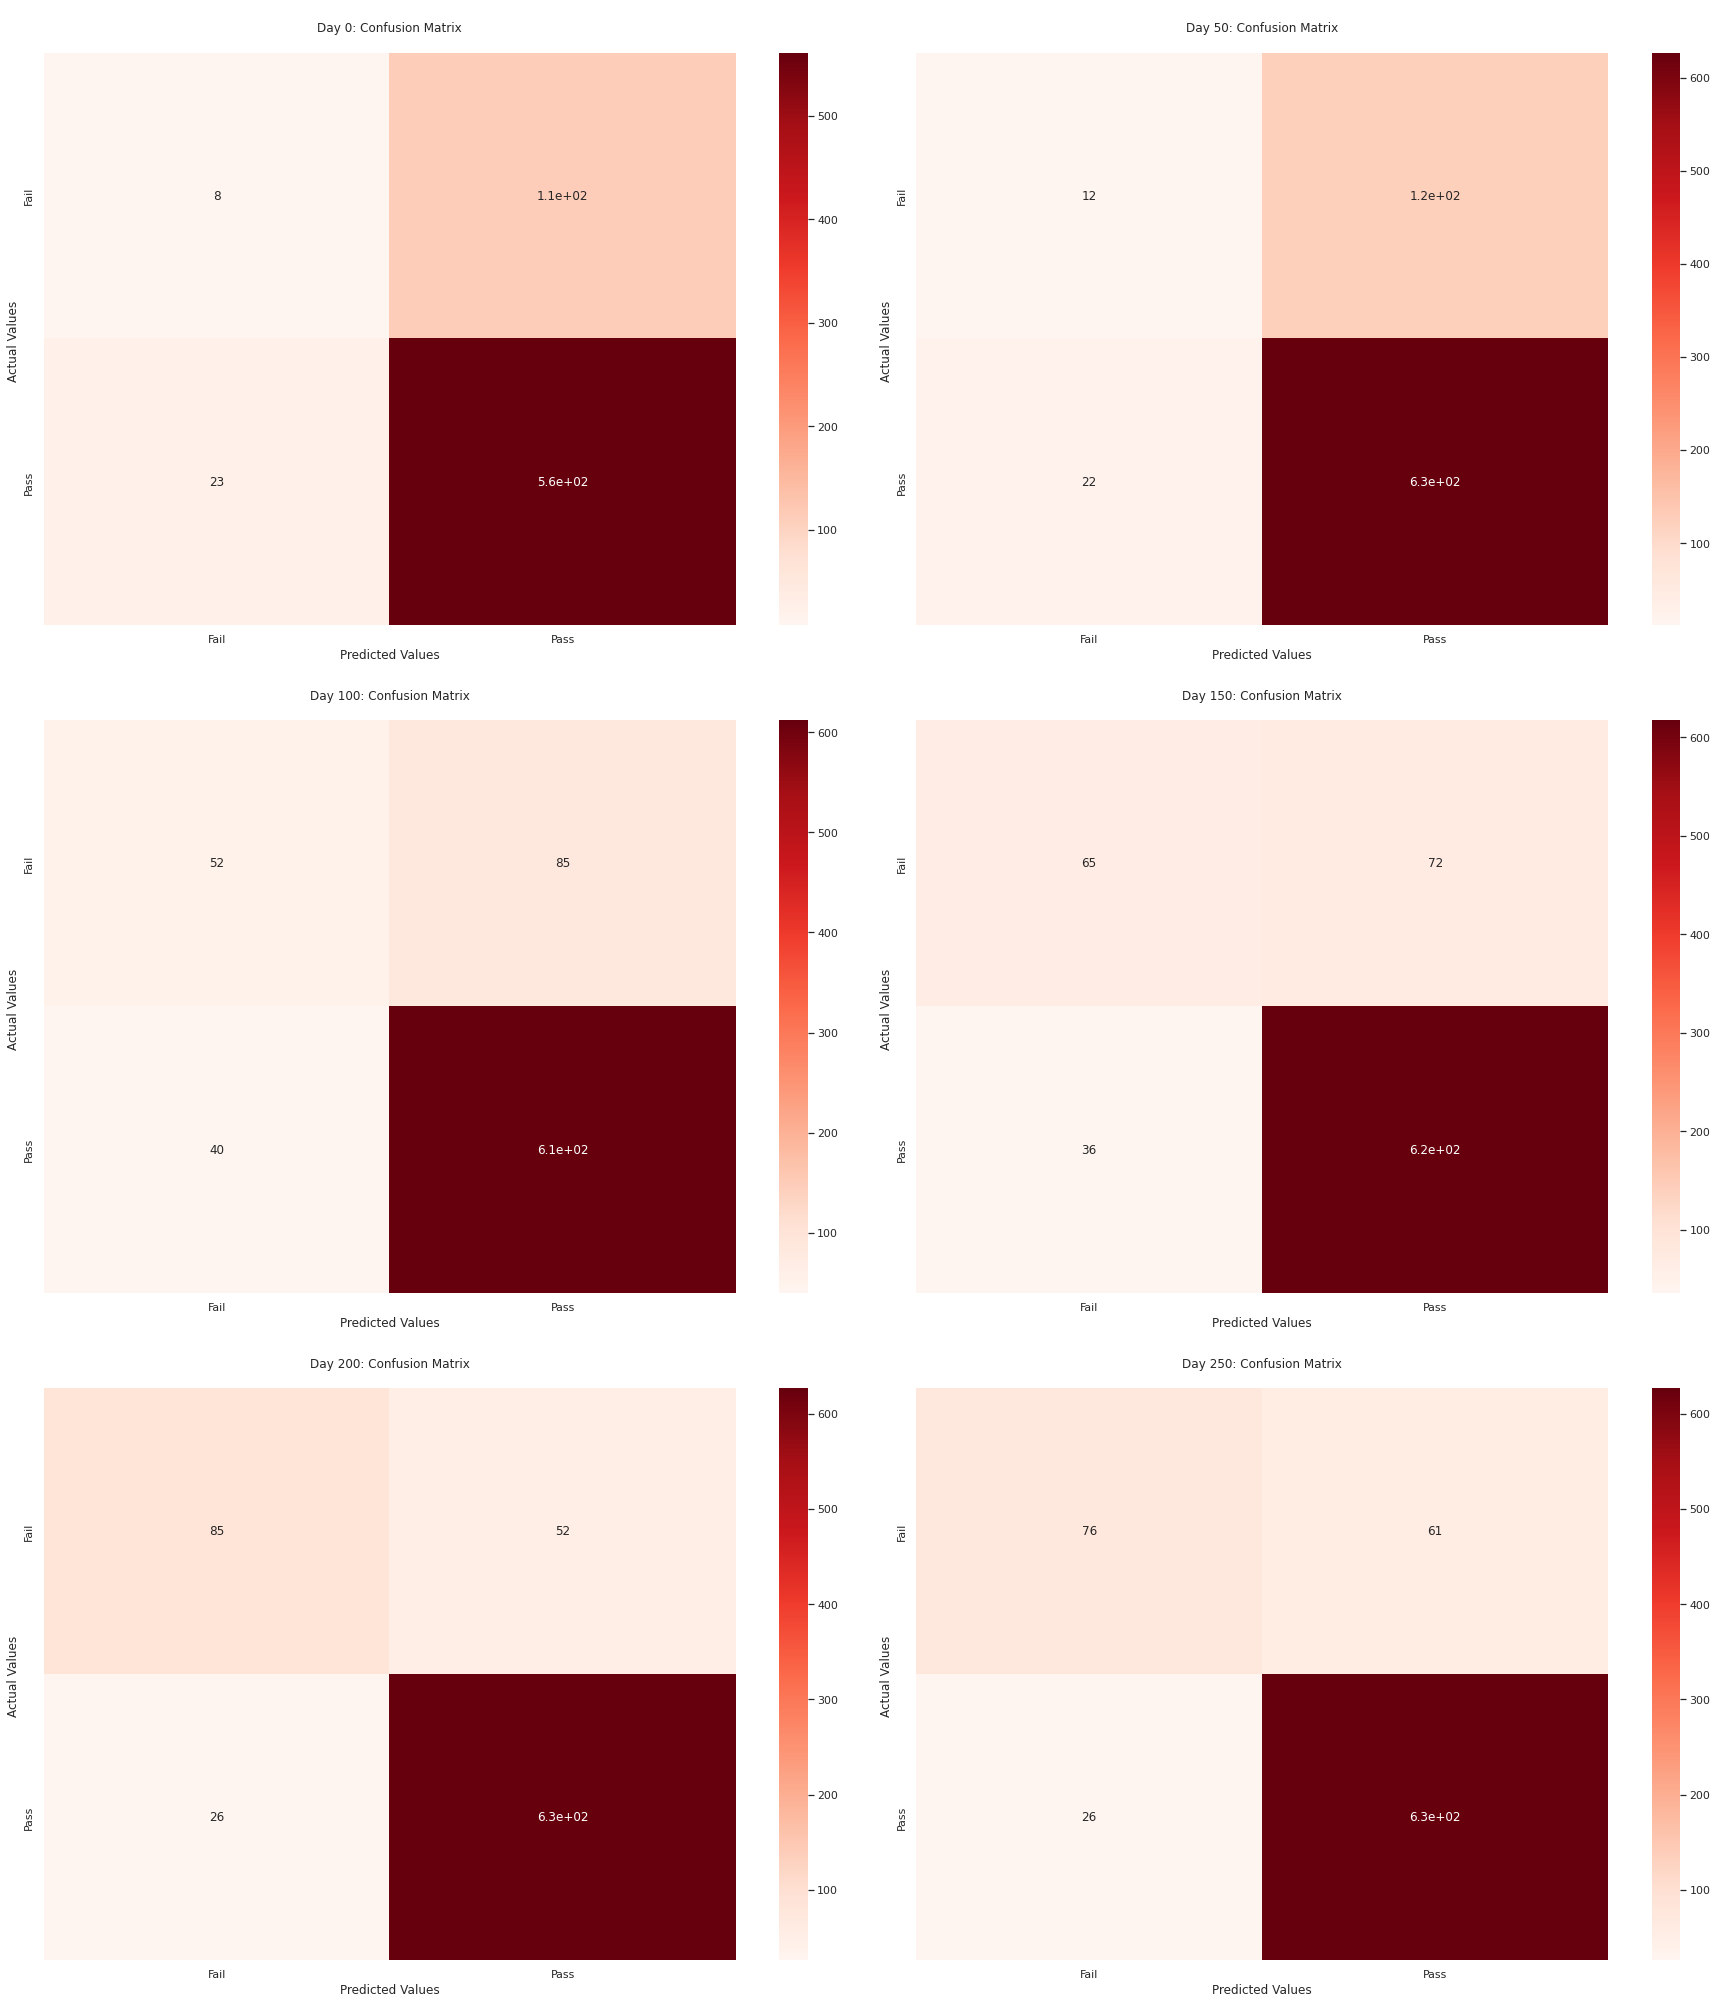

In [125]:
plot_confusion_matrix(all_results_ab)

##### Plot results overview

In [126]:
all_classifier_results = [all_results_du, all_results_nb, all_results_lr, all_results_lrw, all_results_rf, all_results_ab]
all_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-o

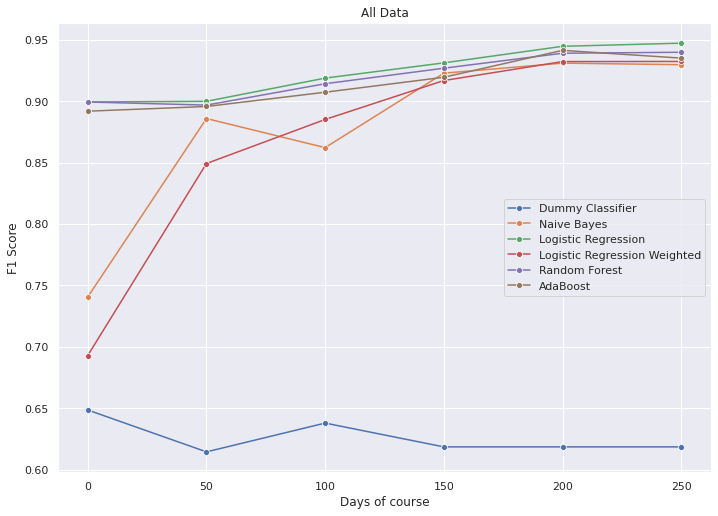

In [127]:
plot_days_compare(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

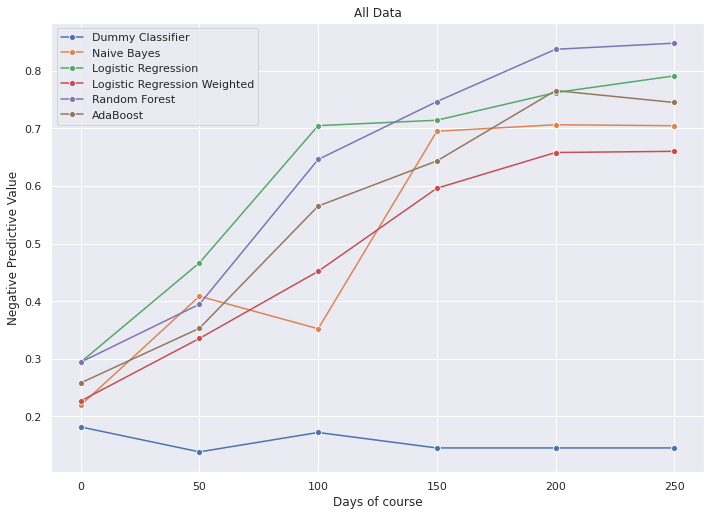

In [128]:
plot_days_compare_npv(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

#### Three classifiers

In [129]:
confusion_matrix_combine_three = []
keys= list(df)

for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine_three.append(np.zeros([2,2]))

  for j in range(len(all_results_predict_lr[i])):
    sum_predict = all_results_predict_lr[i][j] + all_results_predict_rf[i][j] + all_results_predict_ab[i][j]
    if sum_predict <= 1:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine_three[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,1] += 1
    else:
      confusion_matrix_combine_three[i][1,1] += 1


0
1
2
3
4
5


In [130]:
for i in range(len(confusion_matrix_combine_three)):
  print(confusion_matrix_combine_three[i])

[[  4. 117.]
 [  8. 576.]]
[[ 14. 122.]
 [ 18. 631.]]
[[ 43.  94.]
 [ 21. 631.]]
[[ 66.  71.]
 [ 23. 630.]]
[[ 87.  50.]
 [ 20. 633.]]
[[ 83.  54.]
 [ 19. 634.]]


#### Combine Classifier Results

In [131]:
confusion_matrix_combine = []
performance_weight = [0,0,0,0.0,0.5,0.5]
keys= list(df)


for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine.append(np.zeros([2,2]))
  for j in range(len(all_results_predict_proba_lr[i])):
    all_result = all_results_predict_proba_lr[i][j] * (1-performance_weight[i])

    if performance_weight[i] != 0:
      performance_result = performance_predict_proba_nb[i-1][j] * (performance_weight[i])
    else:
      performance_result = 0
    
    final_result = all_result + performance_result
    
    if final_result[0]>0.55:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine[i][0,1] += 1
    else:
      confusion_matrix_combine[i][1,1] += 1


0
1
2
3
4
5


In [132]:
for i in range(len(confusion_matrix_combine)):
  print(confusion_matrix_combine[i])

[[  3. 118.]
 [  6. 578.]]
[[ 19. 117.]
 [ 13. 636.]]
[[ 43.  94.]
 [ 18. 634.]]
[[ 75.  62.]
 [ 24. 629.]]
[[ 87.  50.]
 [ 23. 630.]]
[[ 85.  52.]
 [ 16. 637.]]
